In [2]:
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', 500)

df = pd.read_excel('final_dataset_20-21.xlsx')

df.rename(columns=lambda x: x.replace(" (20/21)", ""), inplace=True)

df.head(), df.columns



(           Player                 Club  Age Position   Nation      Value  \
 0   Kylian Mbappe  Paris Saint-Germain   22   attack   France  144000000   
 1  Erling Haaland    Borussia Dortmund   21   attack   Norway  117000000   
 2      Harry Kane    Tottenham Hotspur   28   attack  England  108000000   
 3    Jadon Sancho    Manchester United   21   attack  England   90000000   
 4   Mohamed Salah         Liverpool FC   29   attack    Egypt   90000000   
 
   Contract Years Left          League      Squad    MP  ...  Offsides  \
 0                   1         Ligue 1  Paris S-G  31.0  ...      17.0   
 1                   3      Bundesliga   Dortmund  28.0  ...      15.0   
 2                   3  Premier League  Tottenham  35.0  ...      12.0   
 3                   5  Premier League   Dortmund  26.0  ...       9.0   
 4                   2  Premier League  Liverpool  37.0  ...      13.0   
 
    Crosses  Interceptions  Penalty Kicks Won  Penalties Conceded  Own Goals  \
 0     68.

In [3]:

df['Contract Years Left'] = pd.to_numeric(df['Contract Years Left'], errors='coerce')
df['Value'] = df['Value'] / 1000000


# df_useful = df.drop(['Total Mins/90', 'Non-Penalty Goals', 'Penalties Attempted','(G+A)/90', 'Non-Penalty Goals/90', '(Gls+Ast-Scored Penalties)/90', 'Non-Penalty xG', 'Non-penalty xG+ xA', 'xG/90', 'xA/90', '(xG+xA)/90', 'Non-Penalty xG/90', '(Non-Penalty xG+xA)/90', 'Shots on Target%', 'Non-Penalty Goals Scored minus Non-Penalty xG', ], axis=1)

df_useful = df


In [4]:
for col in df.columns:
    print(col)


    

Player
Club
Age
Position
Nation
Value
Contract Years Left
League
Squad
MP
Starts
Min
Total Mins/90
Gls
Ast
Non-Penalty Goals
Penalties Scored
Penalties Attempted
Yellow Cards
Red Cards
Gls/90
Ast/90
(G+A)/90
Non-Penalty Goals/90
(Gls+Ast-Scored Penalties)/90
xG
Non-Penalty xG
xA
Non-penalty xG+ xA
xG/90
xA/90
(xG+xA)/90
Non-Penalty xG/90
(Non-Penalty xG+xA)/90
Total Shots
Total Shots on Target
Shots on Target%
Shots/90
Shots on Target/90
Goals/Shots
Goals/Shots on Target
Avg Shot Distance (yds)
Freekick Shots
Non-Penalty xG/Shots
Goals Scored minus xG
Non-Penalty Goals Scored minus Non-Penalty xG
Shot-Creating Actions
Shot-Creating Actions/90
Passes Leading to Shot Attempt
Set-Piece Leading to Shot Attempt
Dribbles Leading to Shot Attempt
Shots Leading to Shot Attempt
Fouls Drawn Leading to Shot Attempt
Defensive Actions Leading to Shot Attempt
Goal Creating Actions
Goal Creating Actions/90
Passes Leading to Goals
Set-Piece Leading to Goals
Dribbles Leading to Goals
Shots Leading to Go

143

In [5]:

import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

# Usuwamy bramkarzy
df_useful = df_useful[df_useful["Position"] !='Goalkeeper']

# Usunięcie kolumn nieliczbowych oprócz kolumn 'League' i 'Position'
df_numeric = df_useful.select_dtypes(include=[np.number])
df_categorical = df_useful[['League', 'Position']]  # DataFrame z kolumnami kategorycznymi

# Inicjalizacja OneHotEncoder
encoder = OneHotEncoder()  

categorical_encoded = encoder.fit_transform(df_categorical).toarray()

categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out())

df_final = pd.concat([df_numeric, categorical_encoded_df], axis=1)

df_final = df_final.dropna()

# Budowanie modelu OLS
X = df_final.drop('Value', axis=1)
y = df_final['Value'] 

# Dodanie stałej do modelu
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     18.71
Date:                Tue, 14 May 2024   Prob (F-statistic):          1.59e-214
Time:                        20:06:29   Log-Likelihood:                -5163.2
No. Observations:                1406   AIC:                         1.058e+04
Df Residuals:                    1277   BIC:                         1.126e+04
Df Model:                         128                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

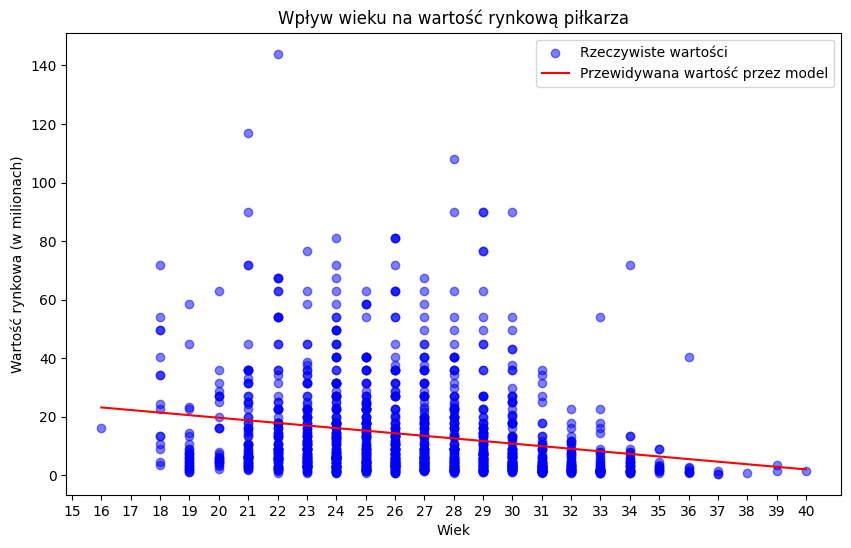

In [6]:

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

age_range = np.linspace(X['Age'].min(), X['Age'].max(), 100)
X_pred = pd.DataFrame({'const': 1, 'Age': age_range}) 
for col in X.columns:
    if col not in ['const', 'Age']:
        X_pred[col] = X[col].mean() 

predicted_values = model.predict(X_pred)

plt.figure(figsize=(10, 6))
plt.scatter(X['Age'], y, color='blue', alpha=0.5, label='Rzeczywiste wartości')
plt.plot(age_range, predicted_values, color='red', label='Przewidywana wartość przez model')
plt.title('Wpływ wieku na wartość rynkową piłkarza')
plt.xlabel('Wiek')
plt.ylabel('Wartość rynkowa (w milionach)')
plt.xticks(np.arange(15, 41, 1))
plt.legend()
plt.show()

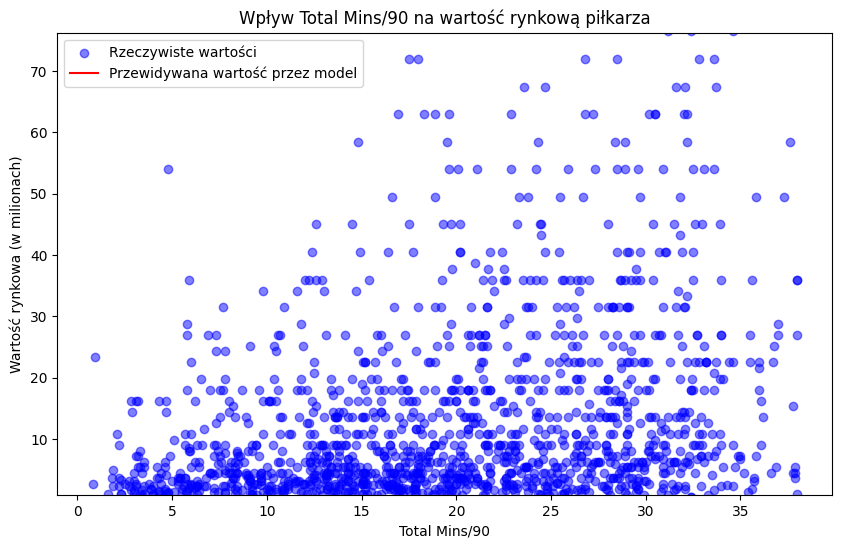

In [7]:


variable_range = np.linspace(df_final['Total Mins/90'].min(), df_final['Total Mins/90'].max(), 100)
X_pred = pd.DataFrame({'const': 1, 'Total Mins/90': variable_range})  # Dodanie kolumny const do przewidywania

for col in X.columns:
    if col not in ['const', 'Total Mins/90']:
        X_pred[col] = X[col].mean()  

predicted_values = model.predict(X_pred)


plt.figure(figsize=(10, 6))
plt.scatter(df_final['Total Mins/90'], df_final['Value'], color='blue', alpha=0.5, label='Rzeczywiste wartości')
plt.plot(variable_range, predicted_values, color='red', label='Przewidywana wartość przez model')
plt.title('Wpływ Total Mins/90 na wartość rynkową piłkarza')
plt.xlabel('Total Mins/90')
plt.ylabel('Wartość rynkowa (w milionach)')
plt.ylim([df_final['Value'].quantile(0.01), df_final['Value'].quantile(0.99)])  # Ograniczenie osi Y do 1-99 percentyla
plt.legend()
plt.show()

# przy wielu zmiennych podawanychj na 90 minut, funckja liniowa jest daleko pod wartosciami rzeczywistymi

Wykresy Wartosci rynkowej od wszystkich zmiennych. 

Jest problem z wiekszoscia zmiennych gdyz wykres funkcji liniowej jest bardzo mocno pod wartosciami rzeczywistymi

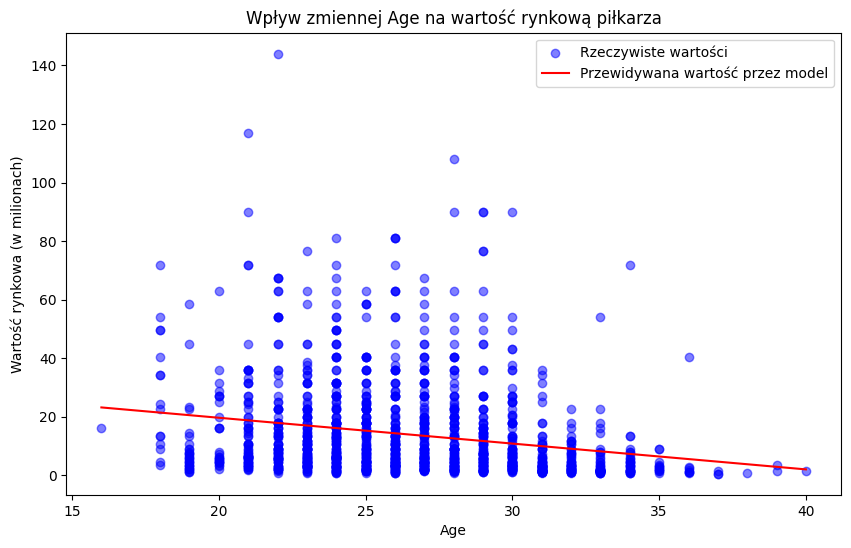

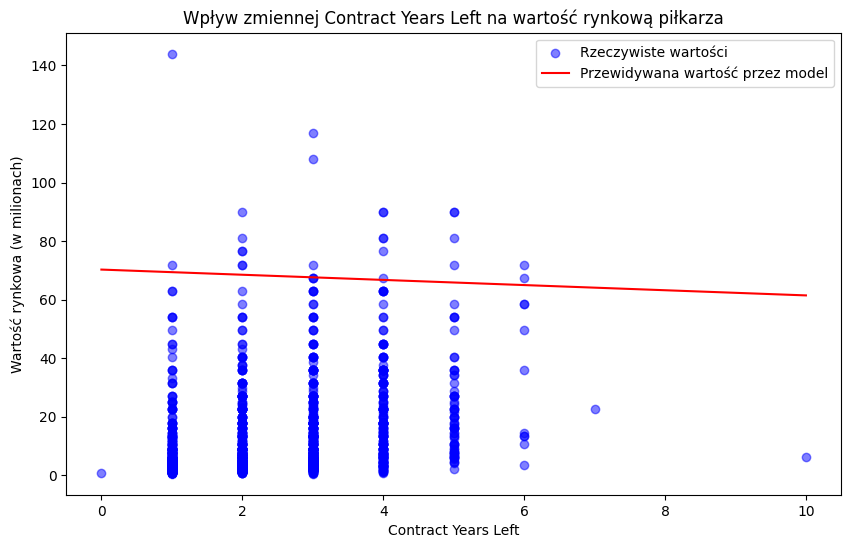

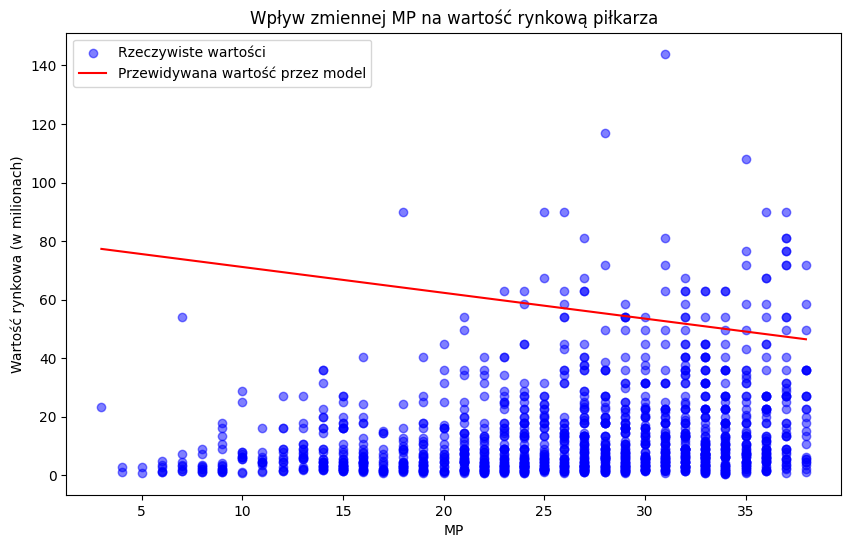

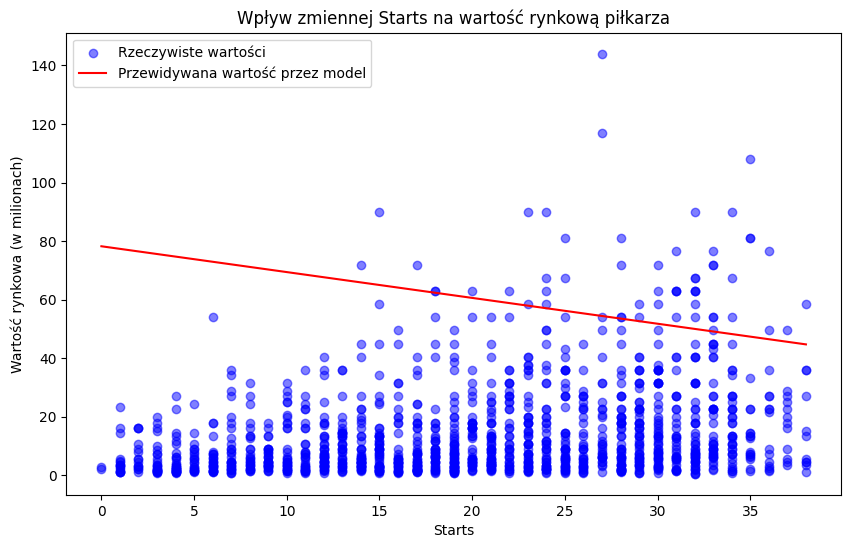

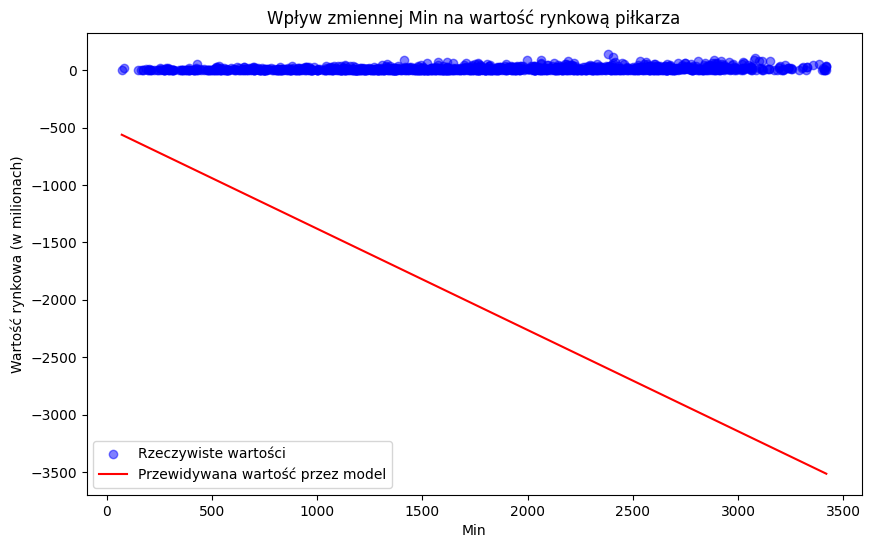

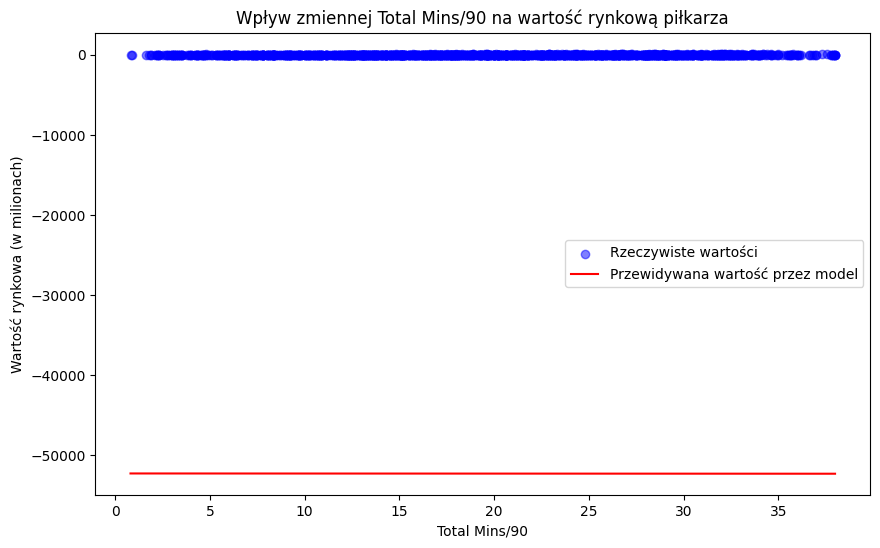

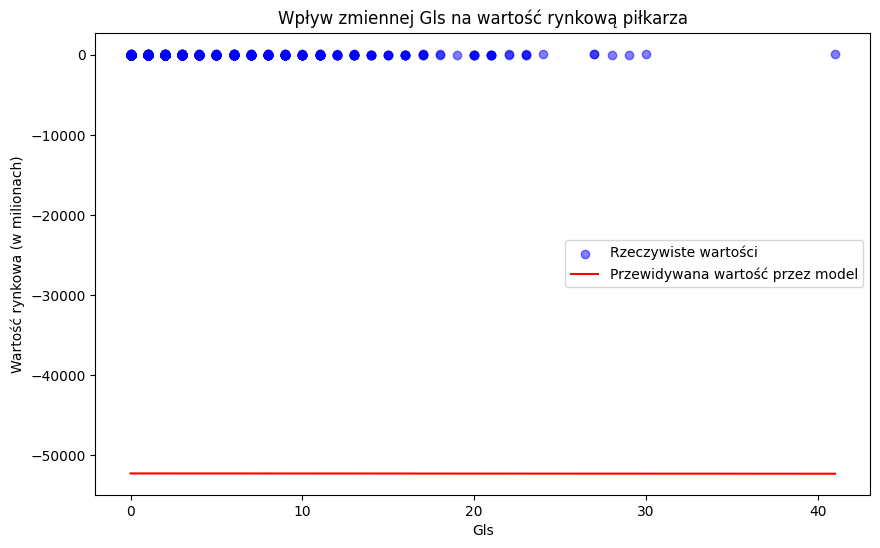

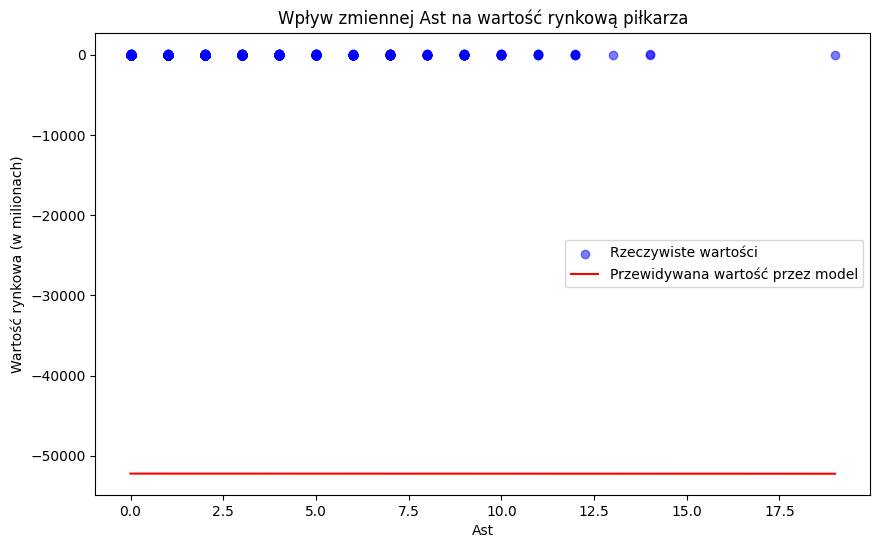

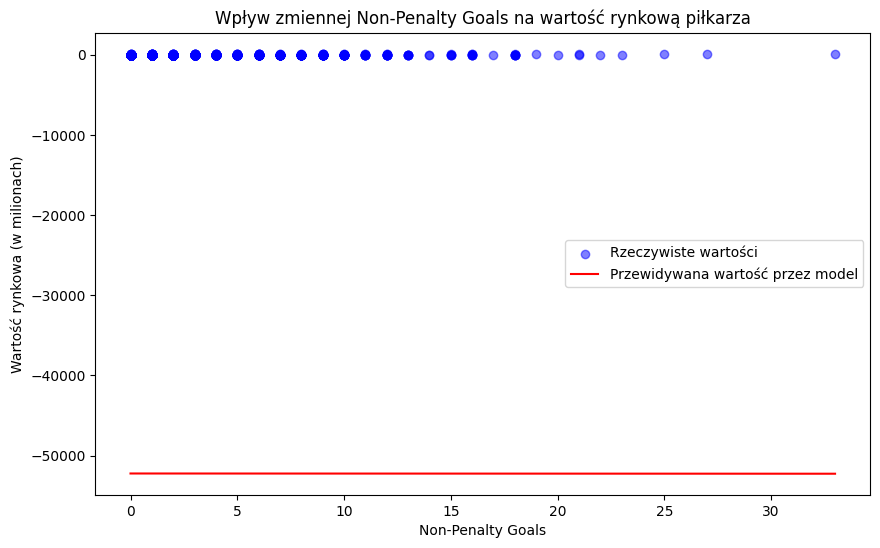

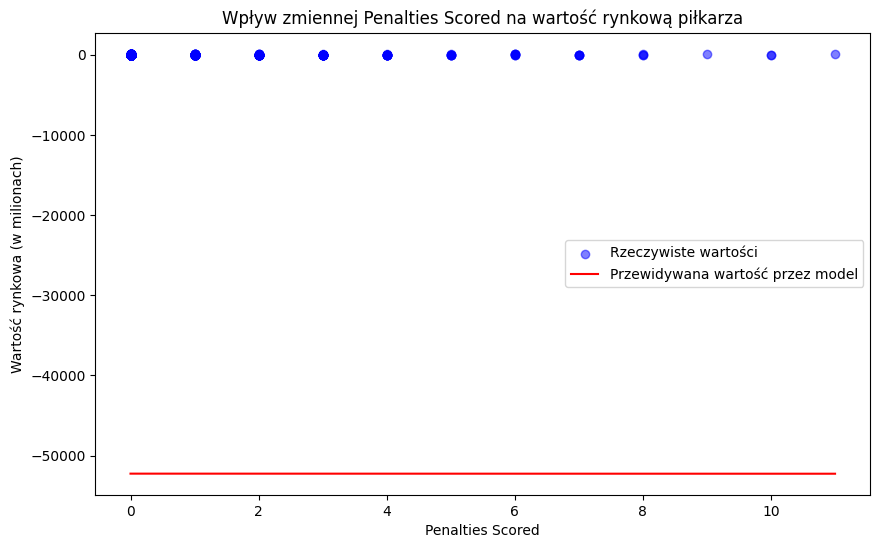

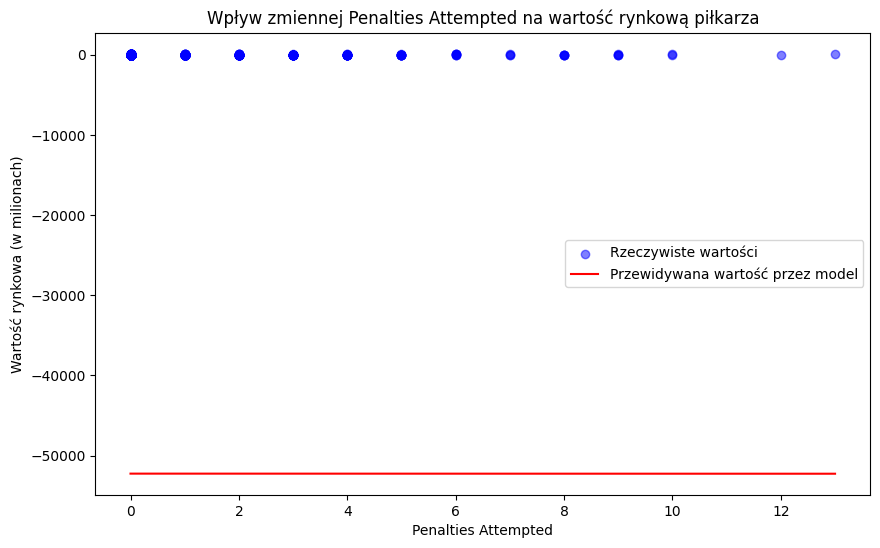

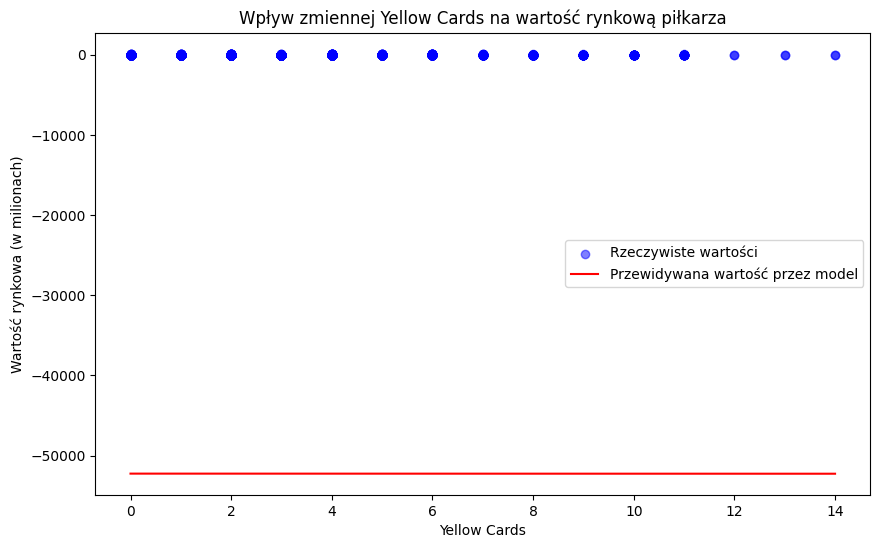

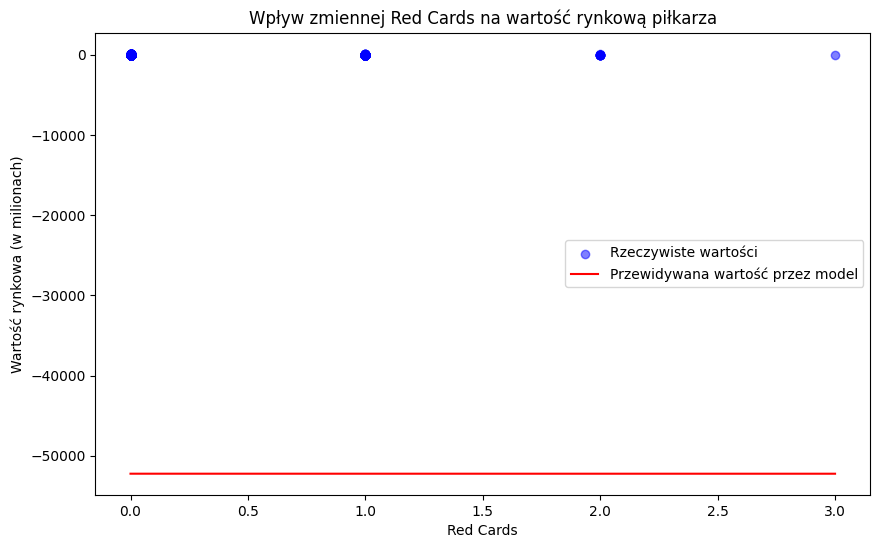

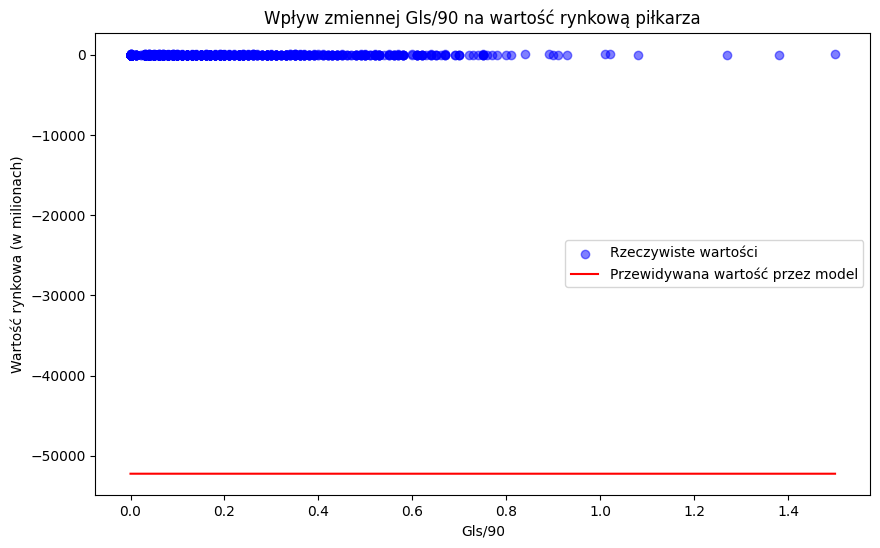

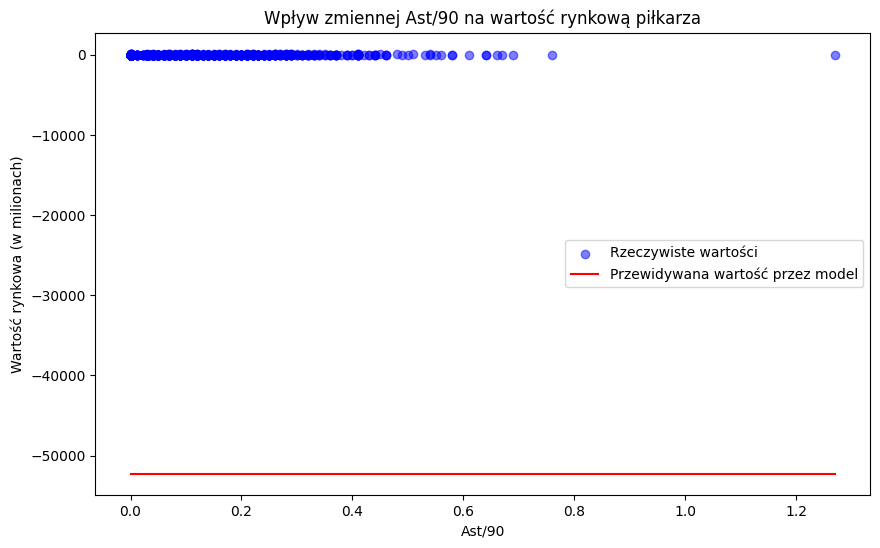

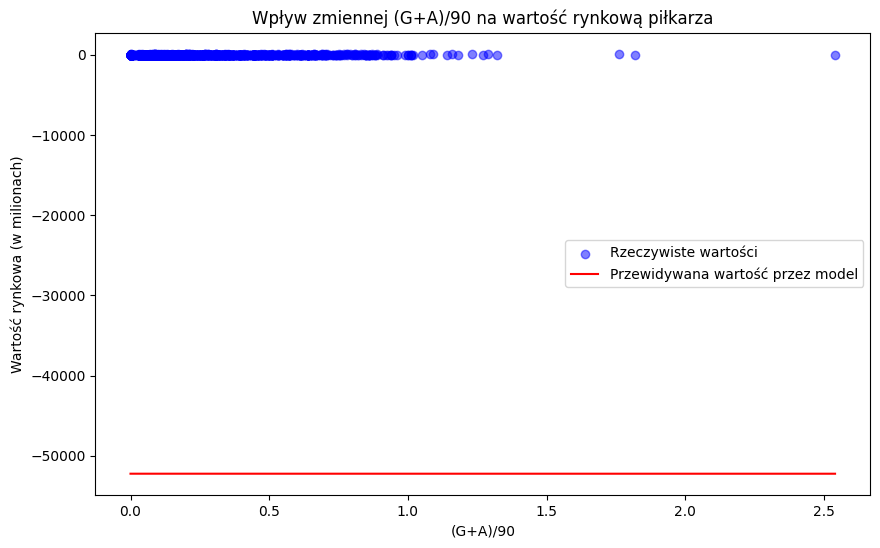

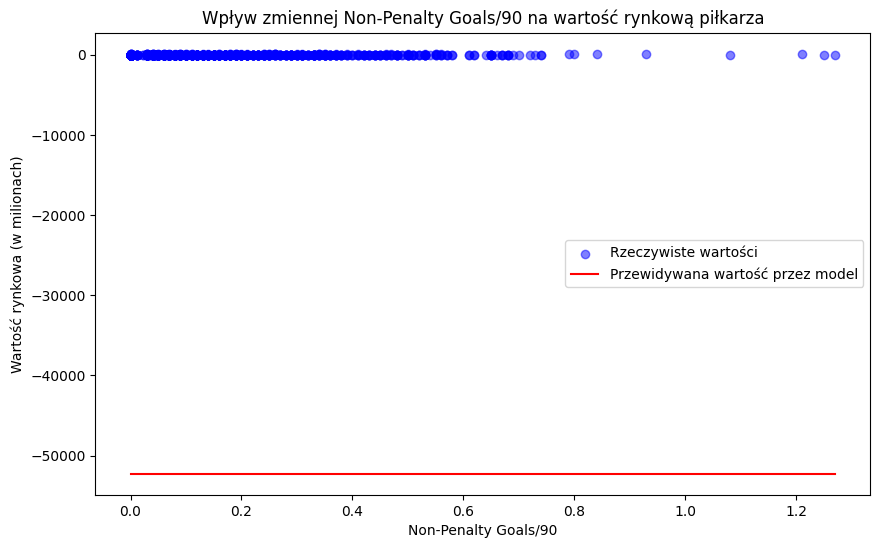

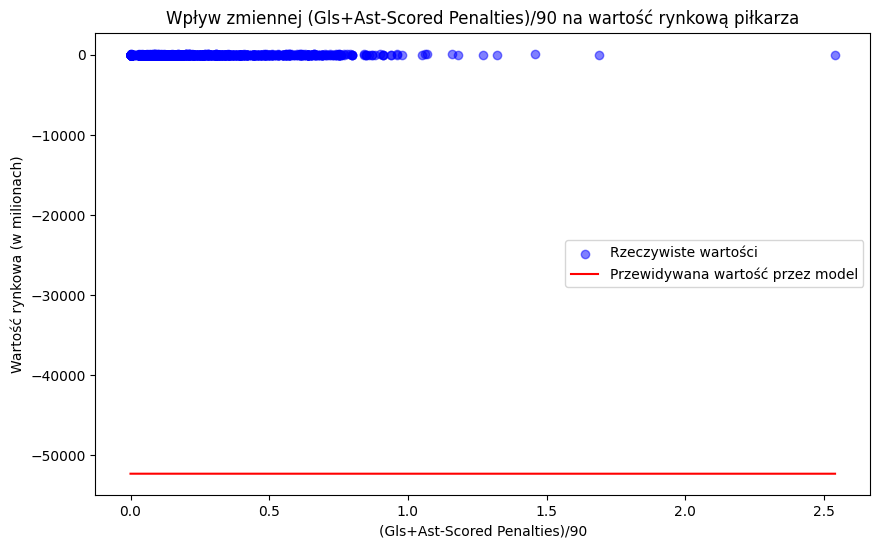

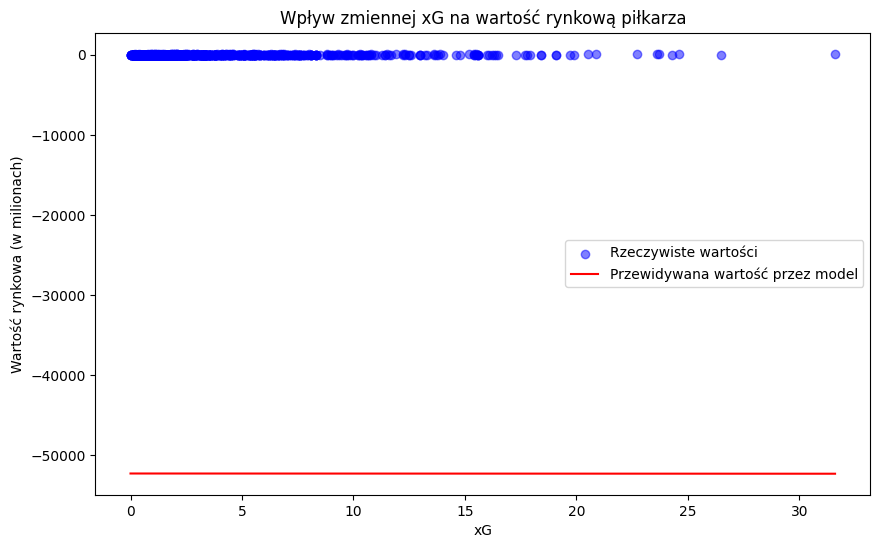

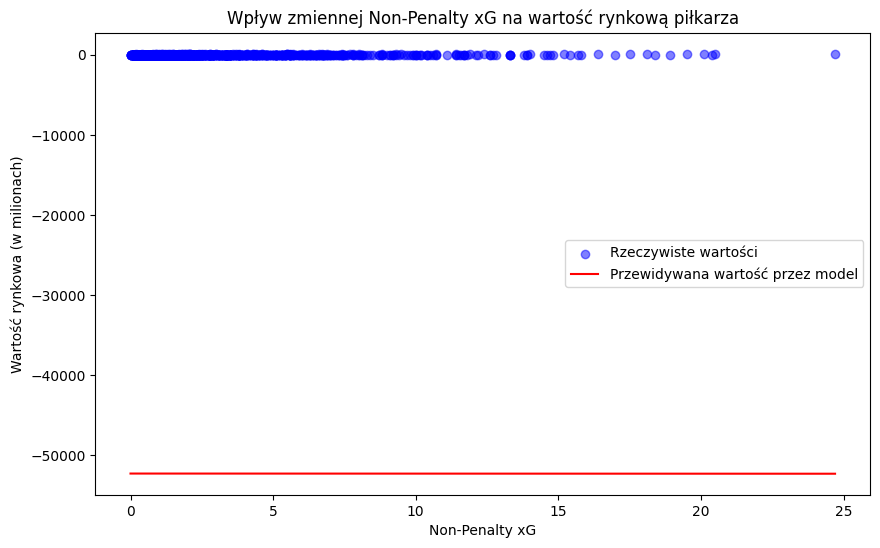

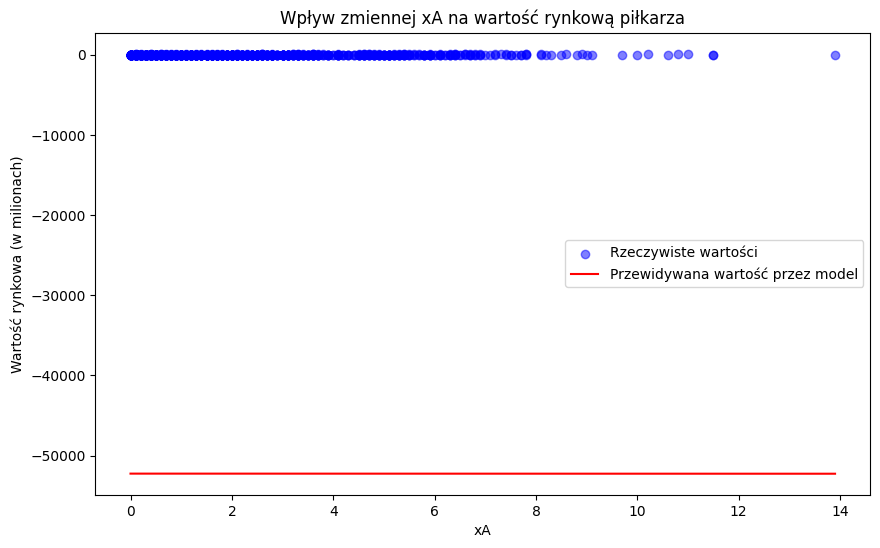

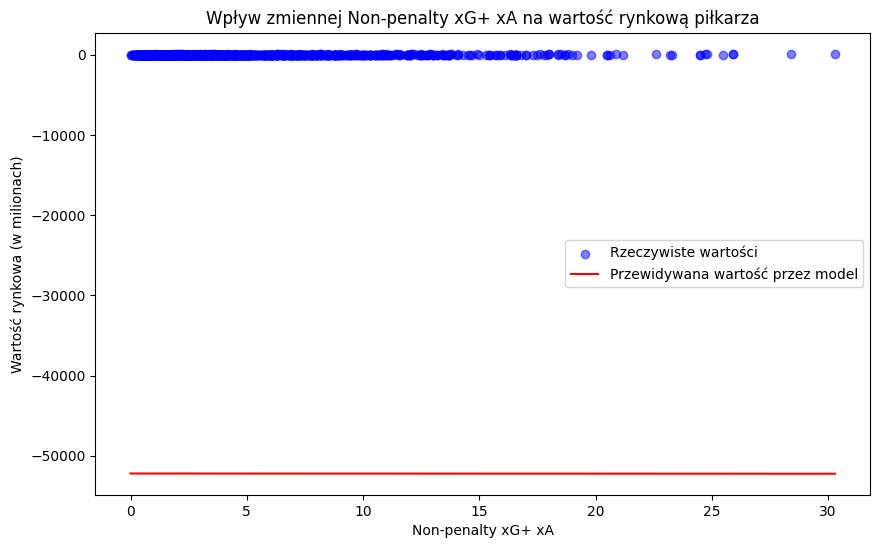

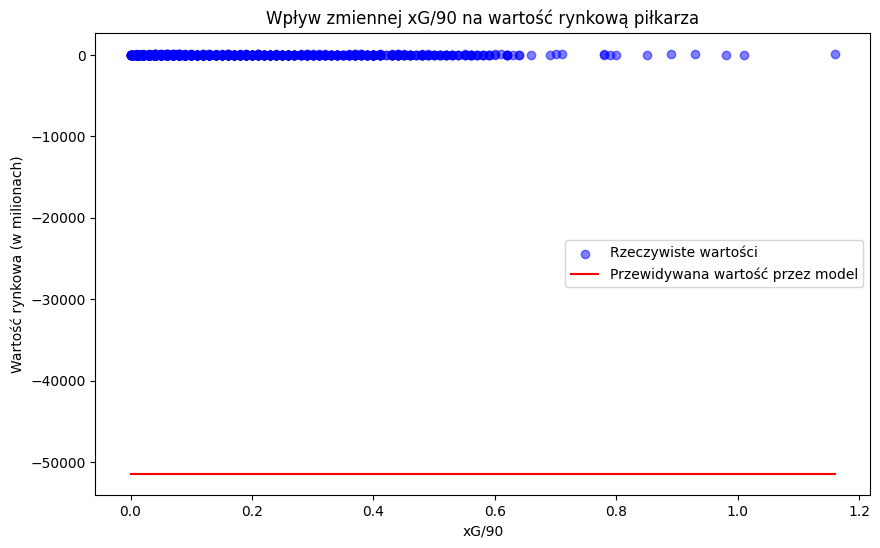

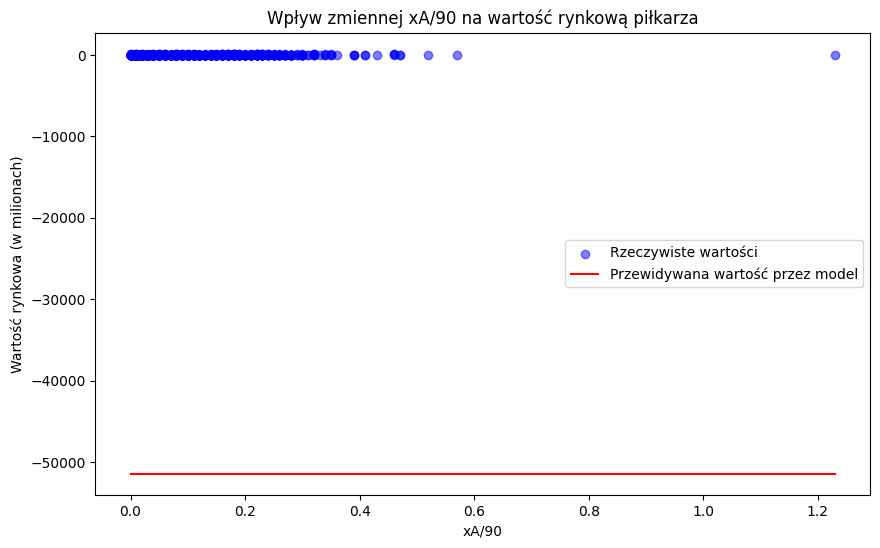

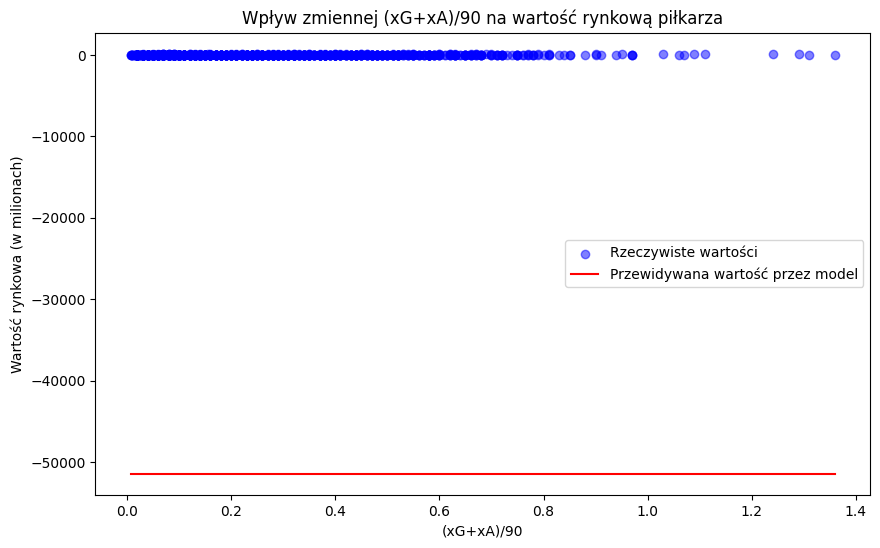

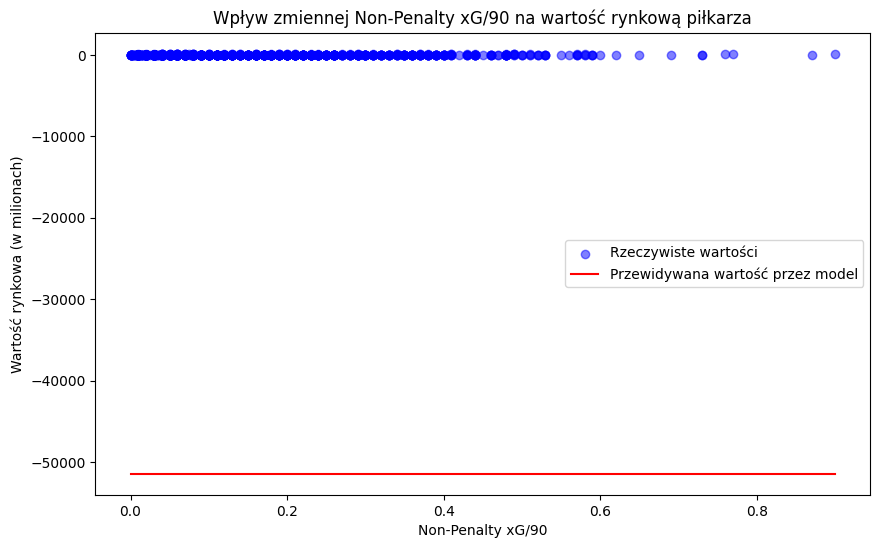

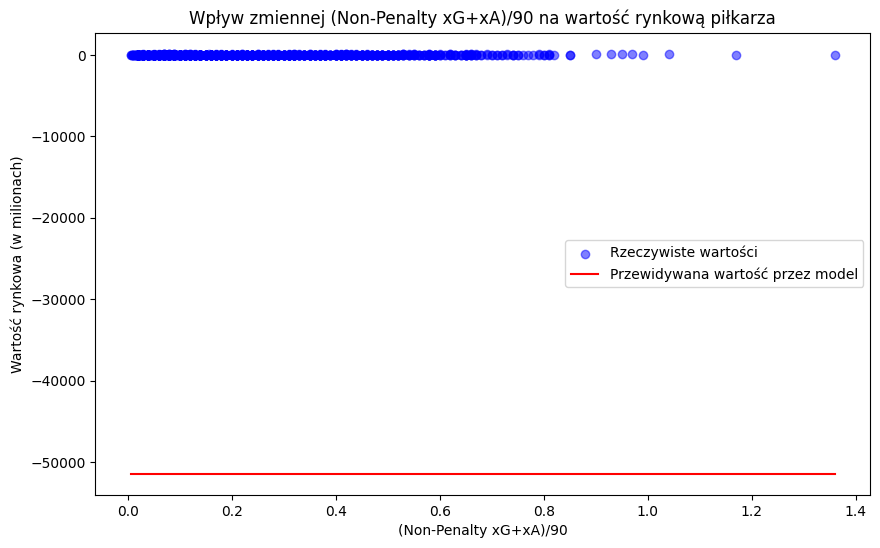

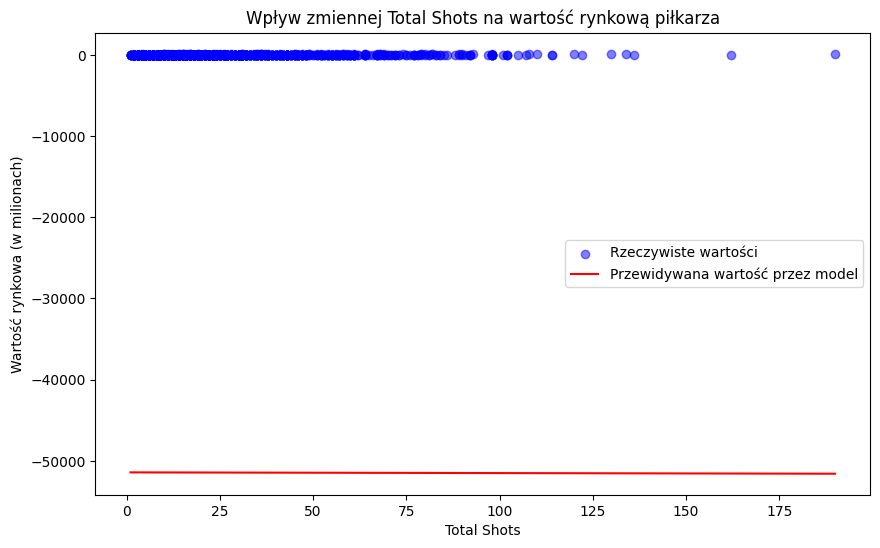

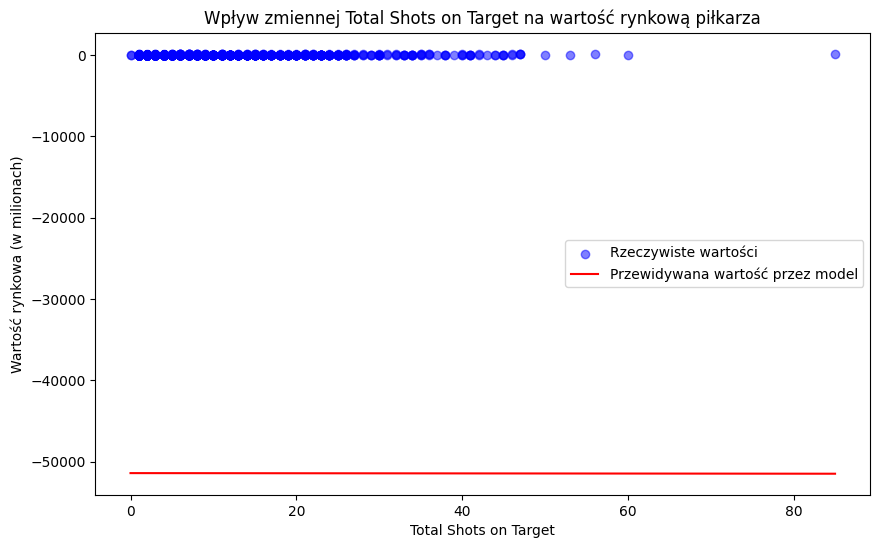

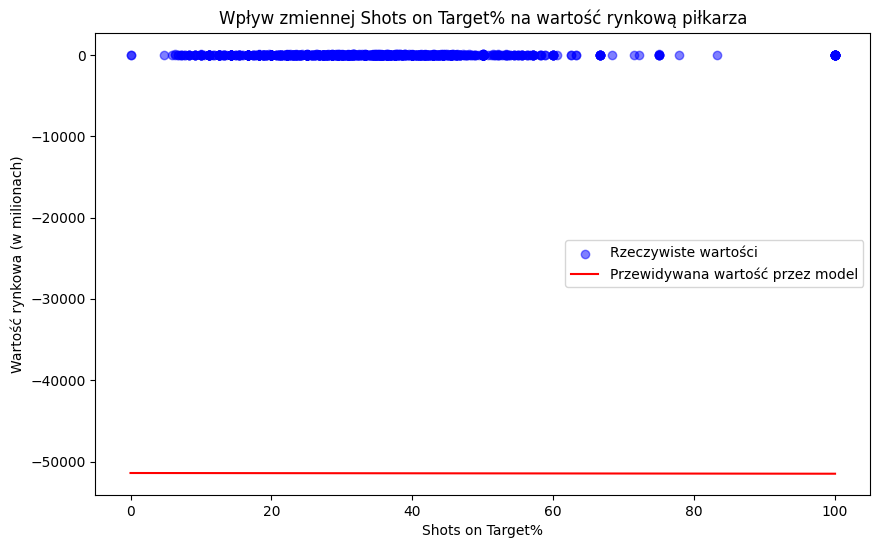

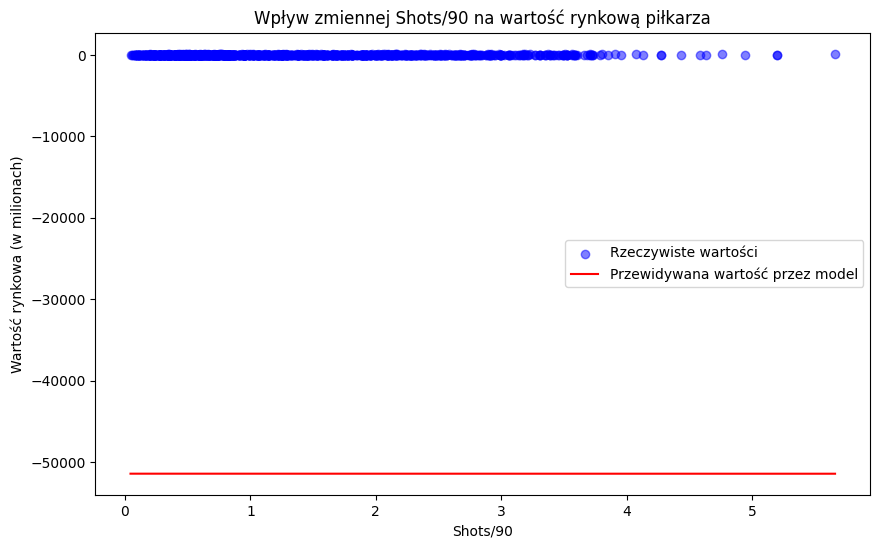

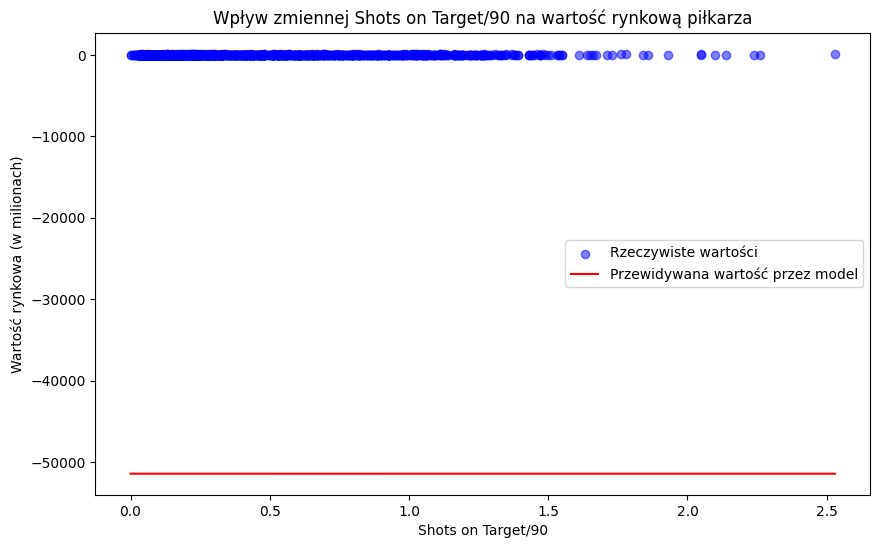

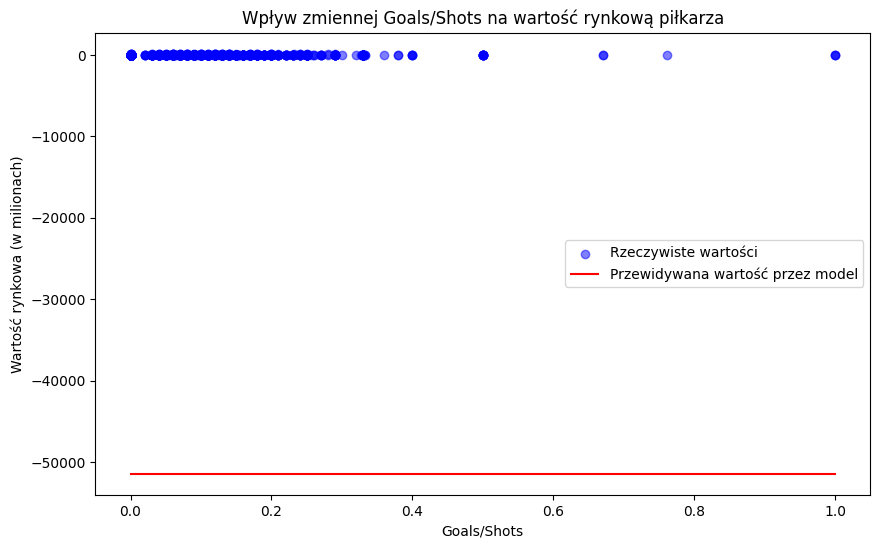

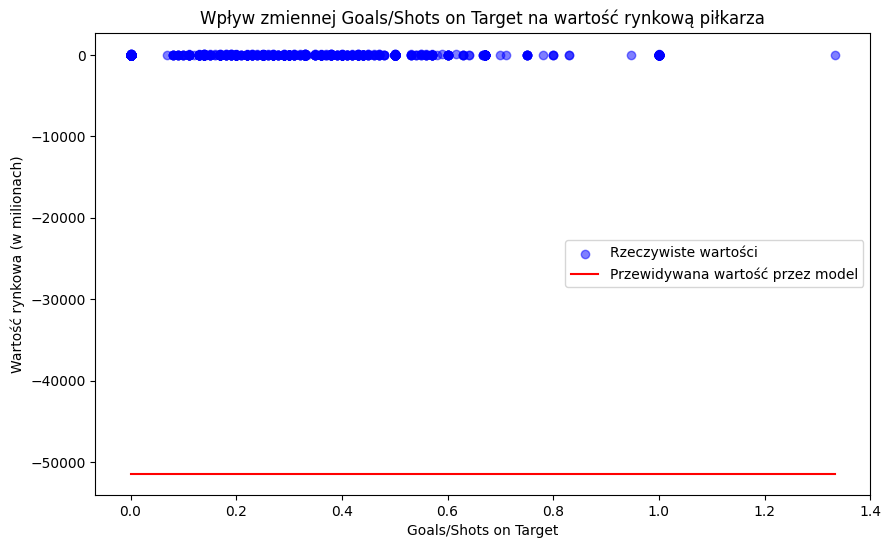

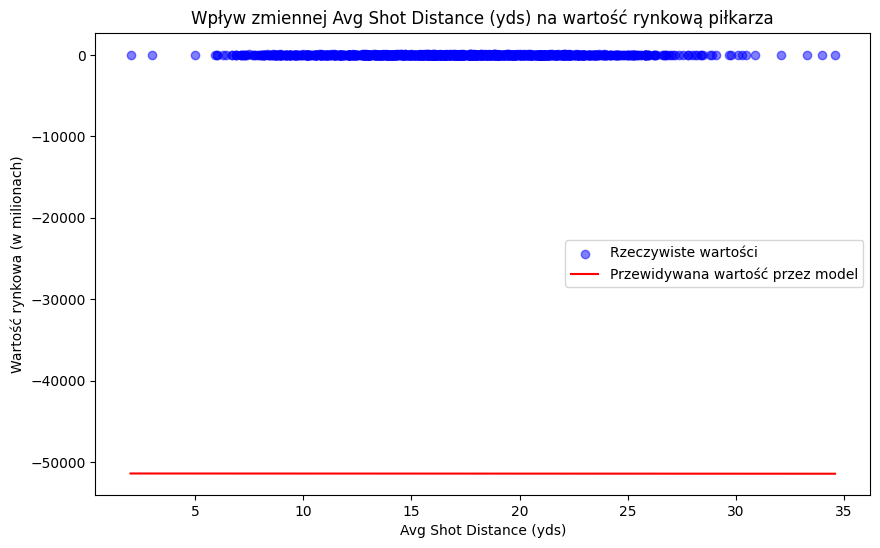

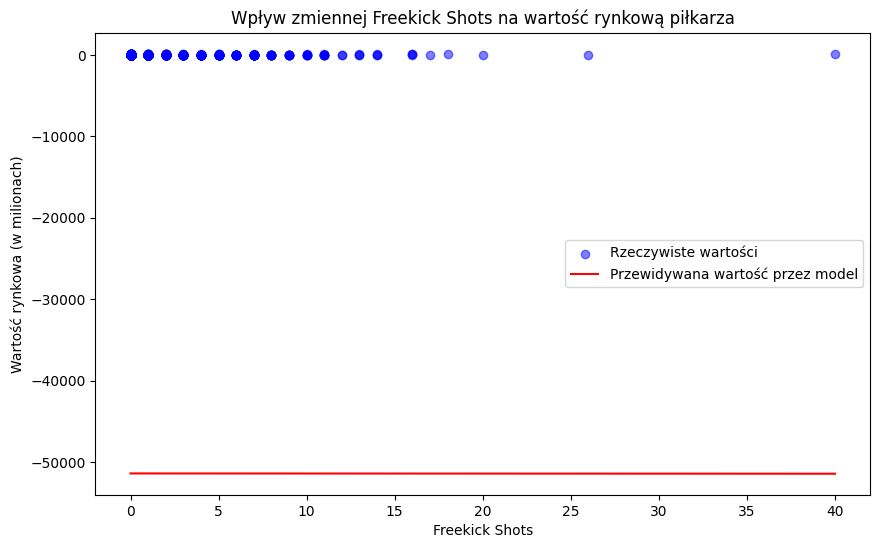

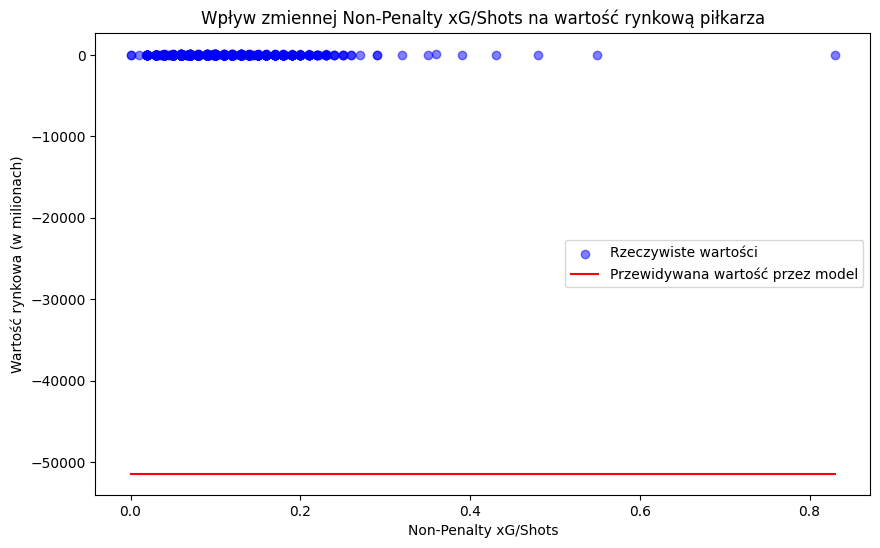

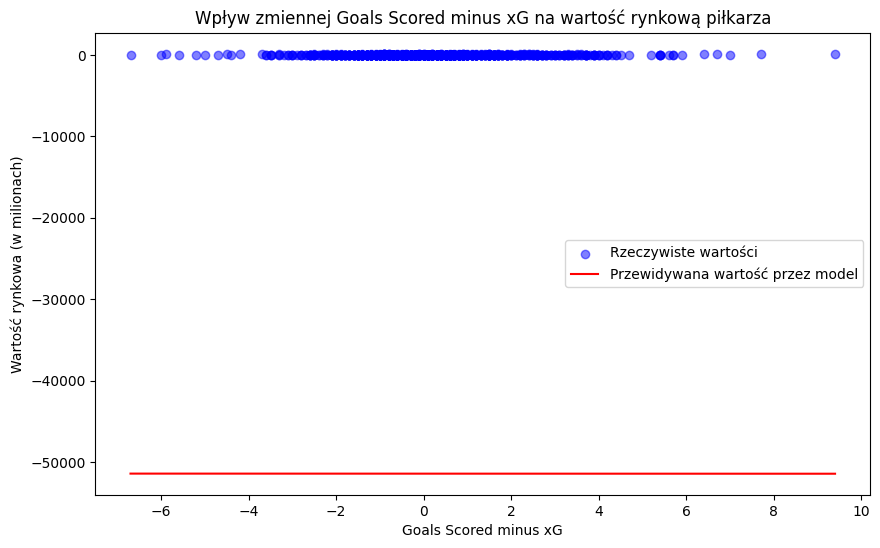

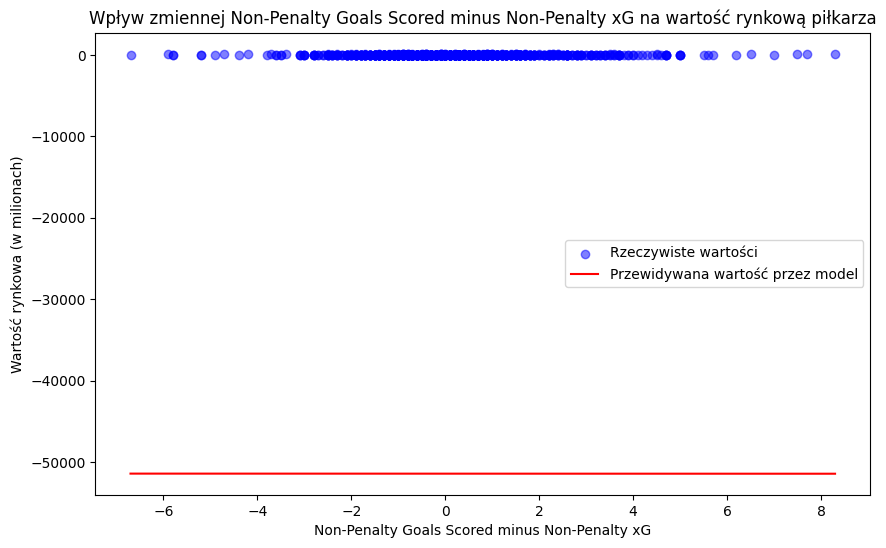

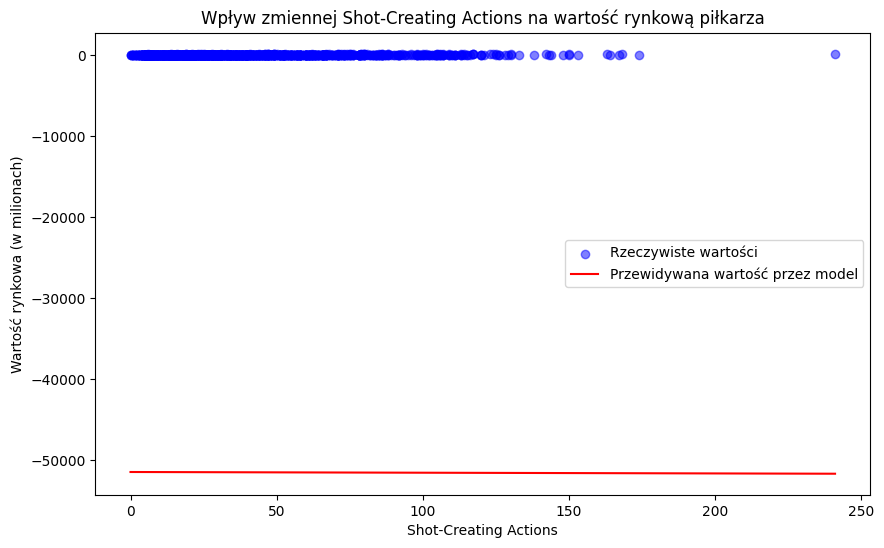

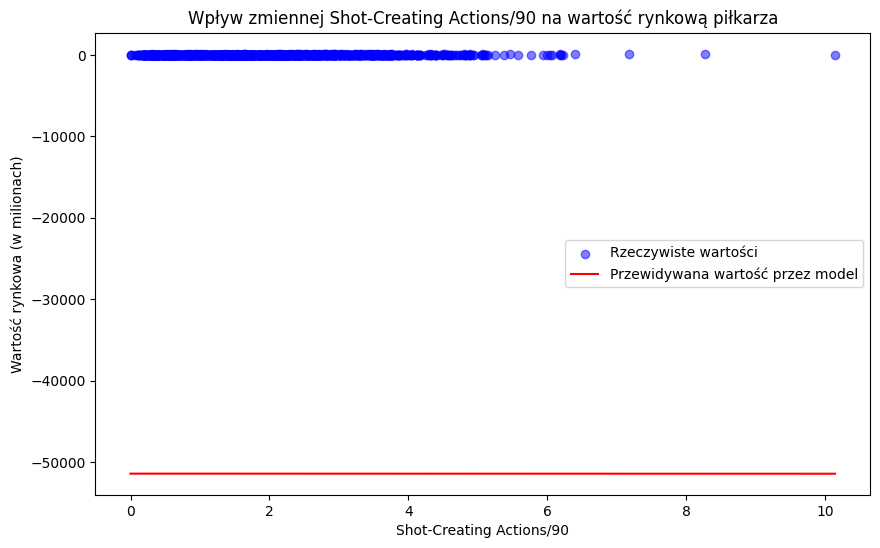

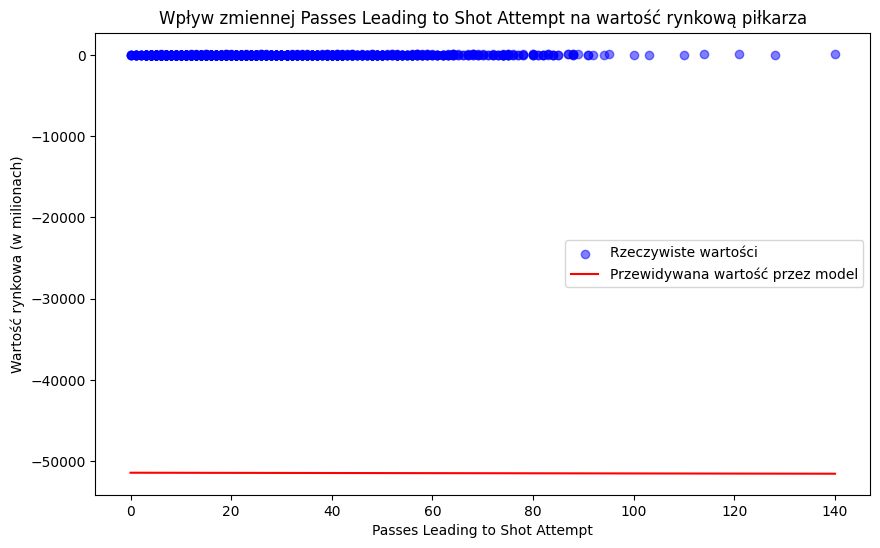

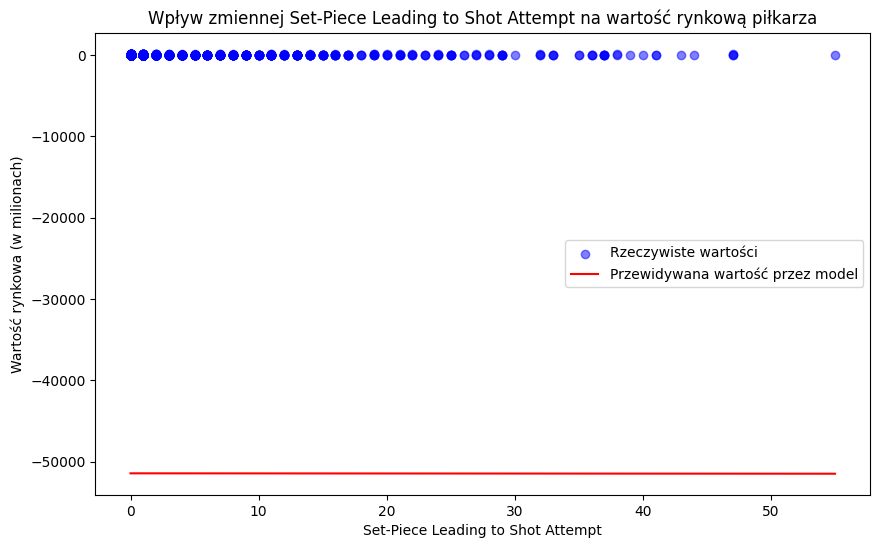

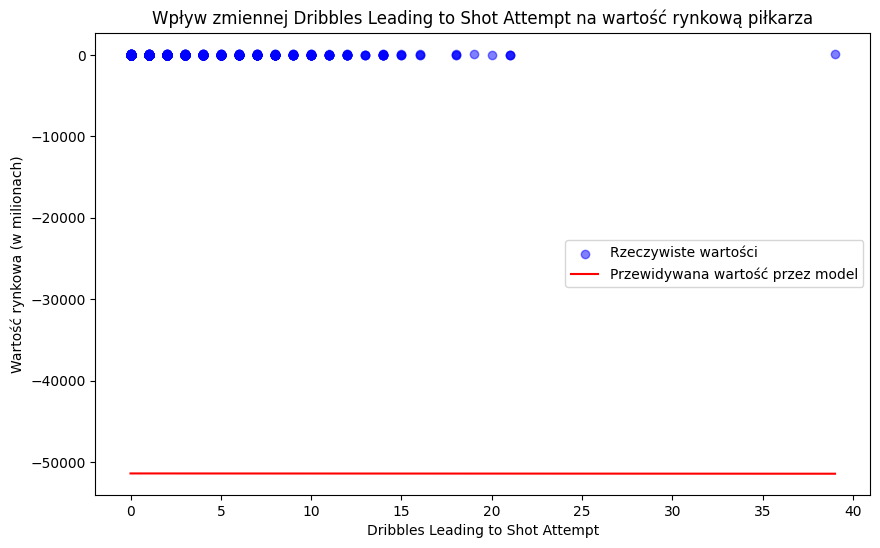

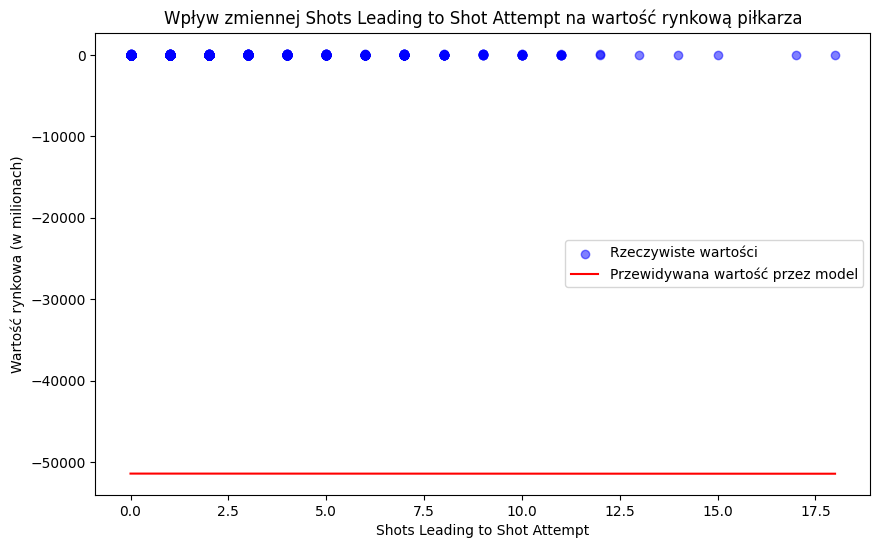

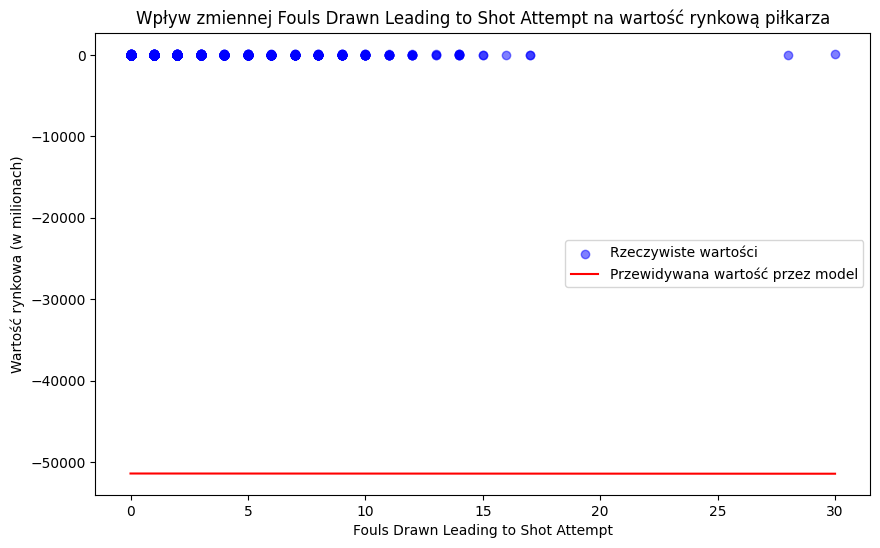

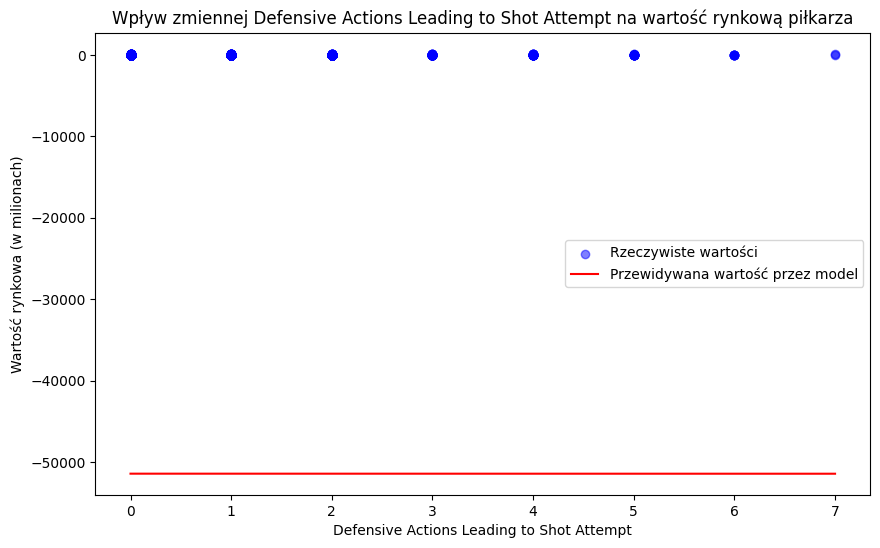

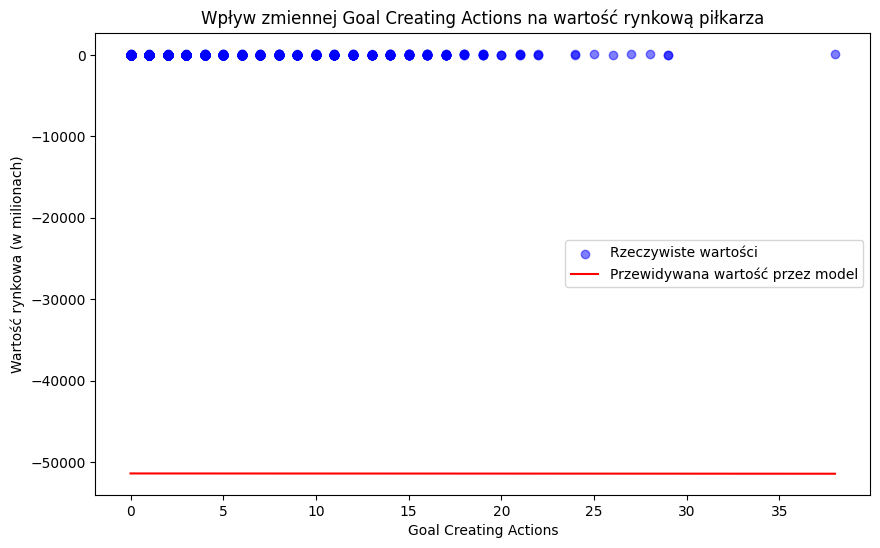

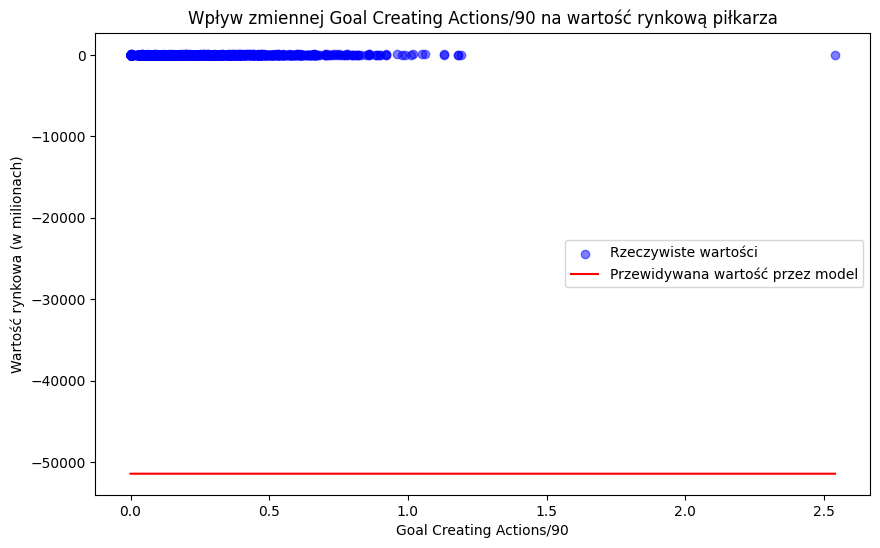

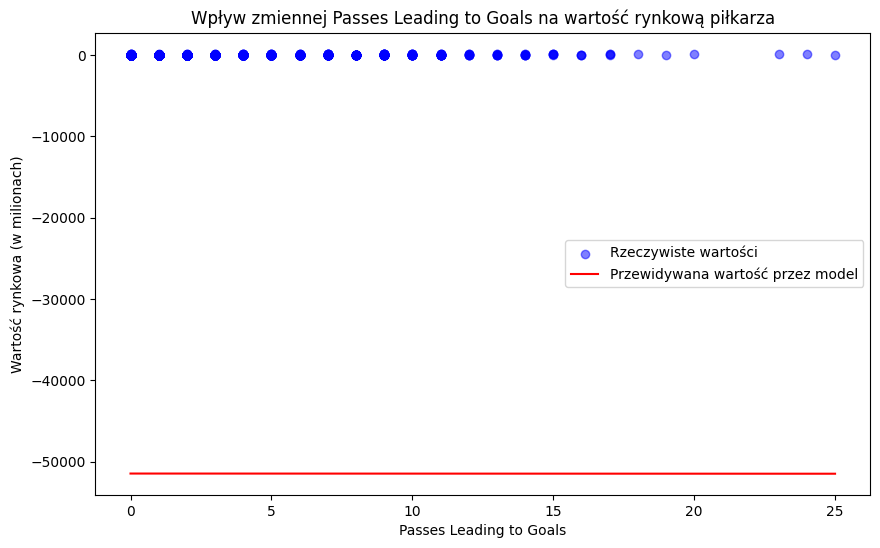

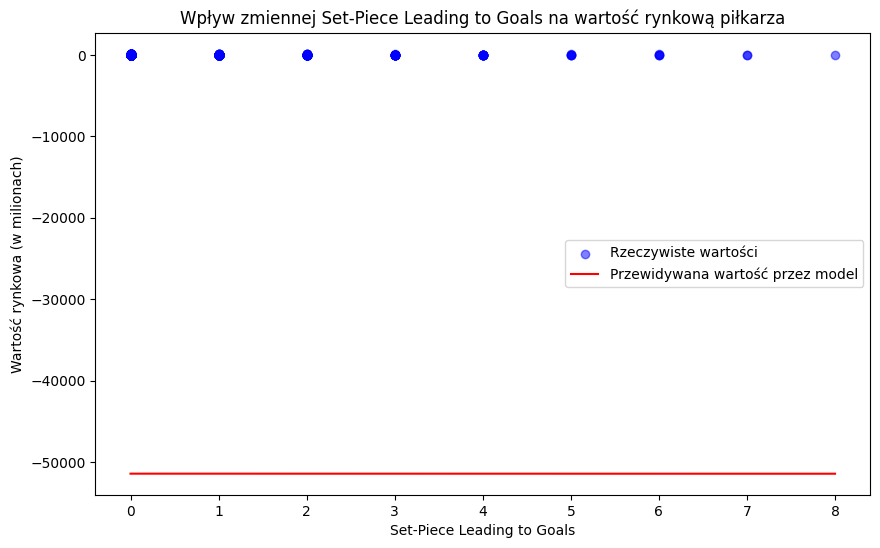

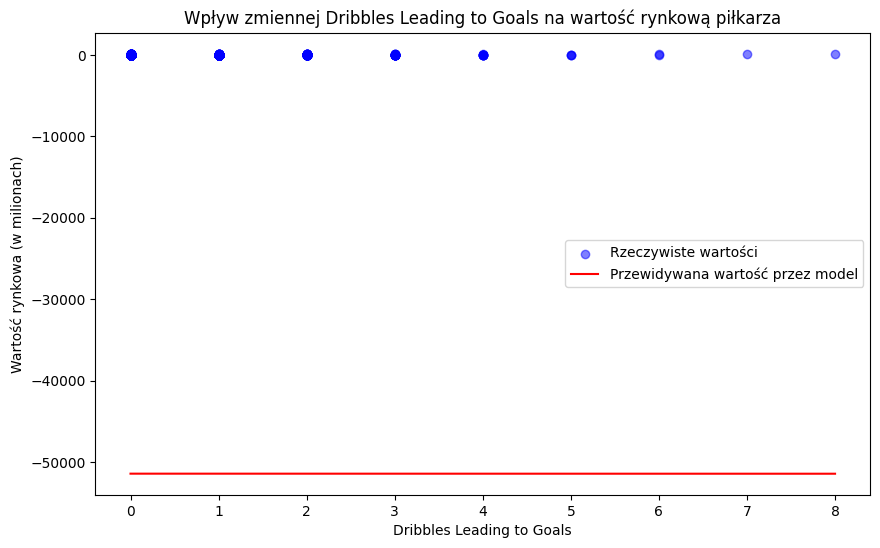

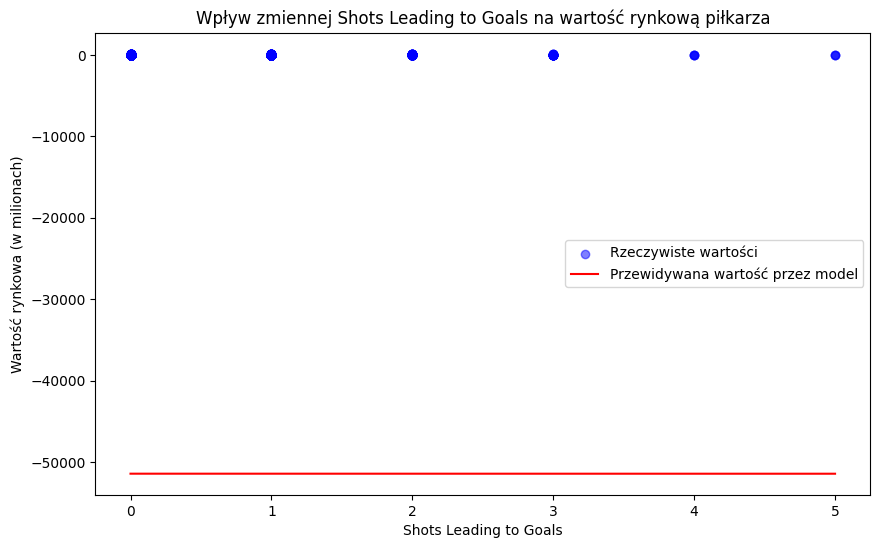

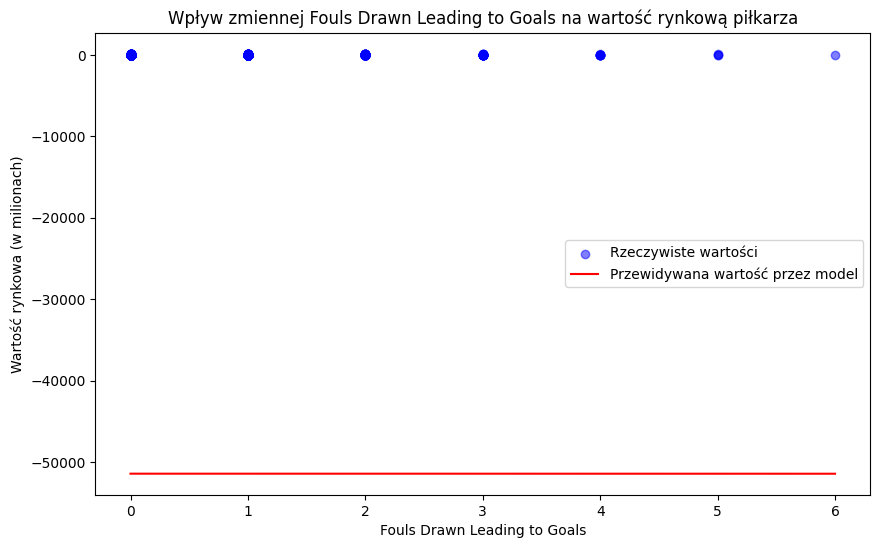

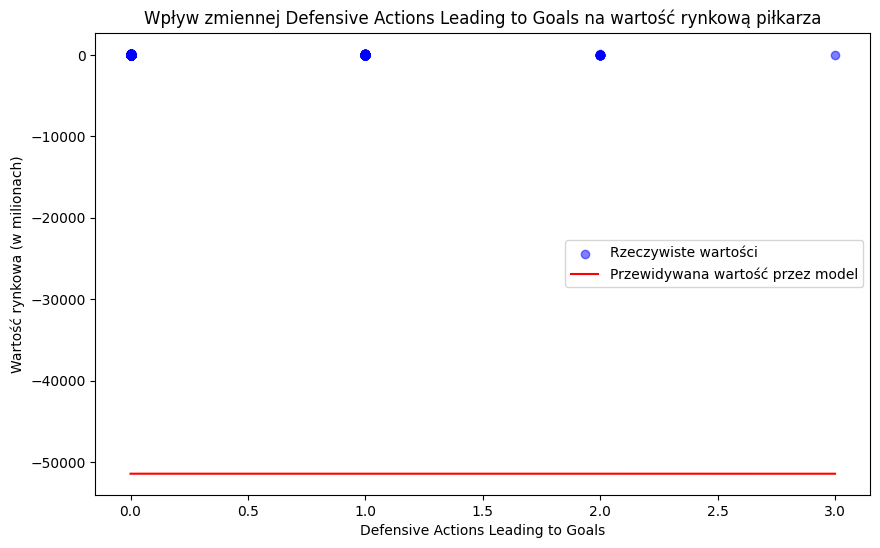

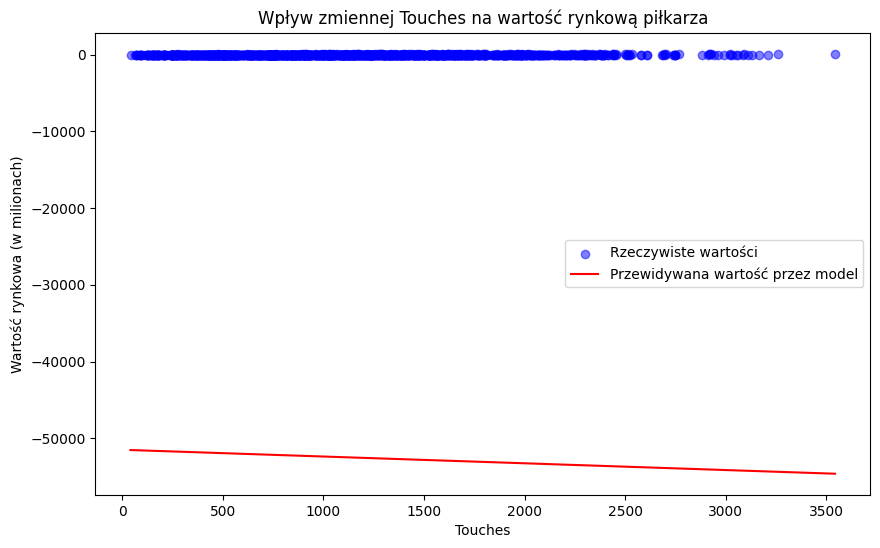

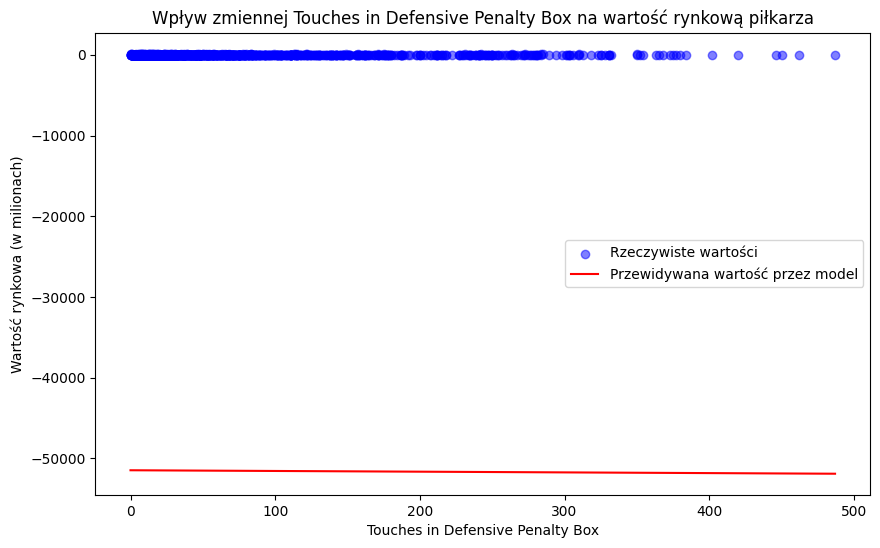

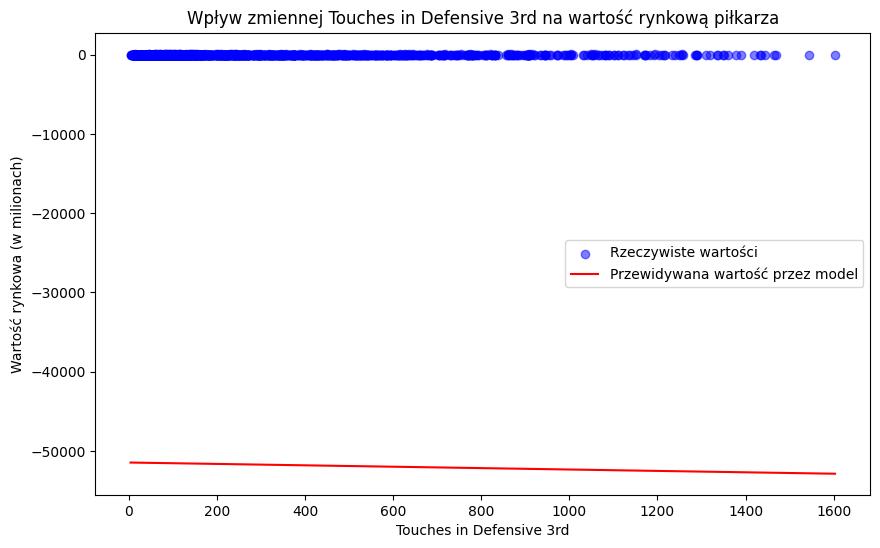

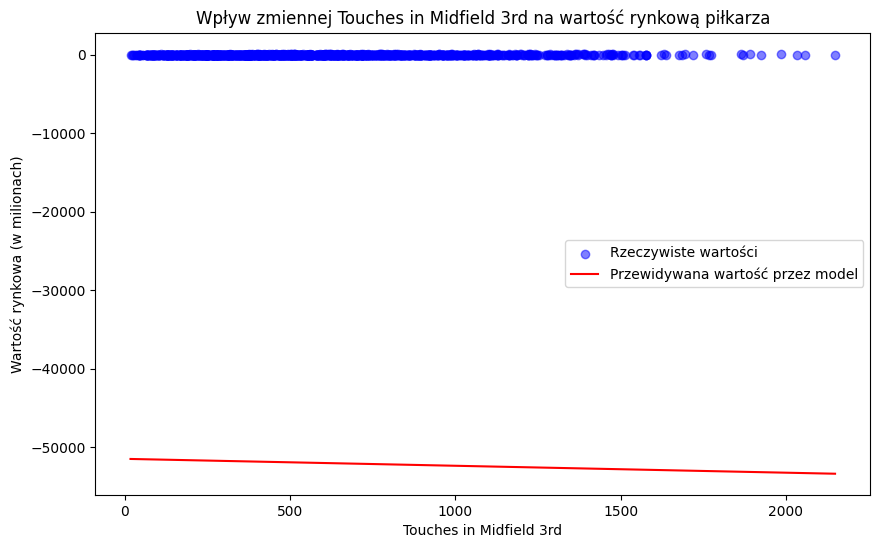

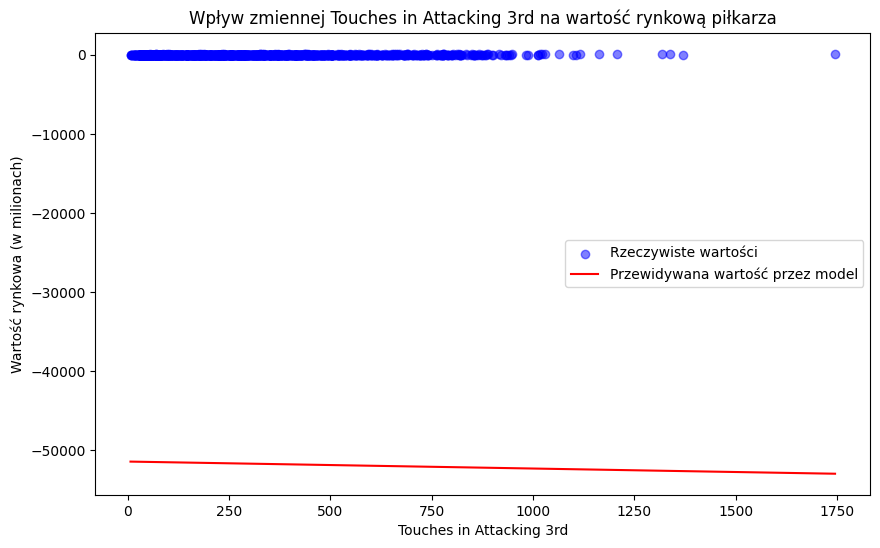

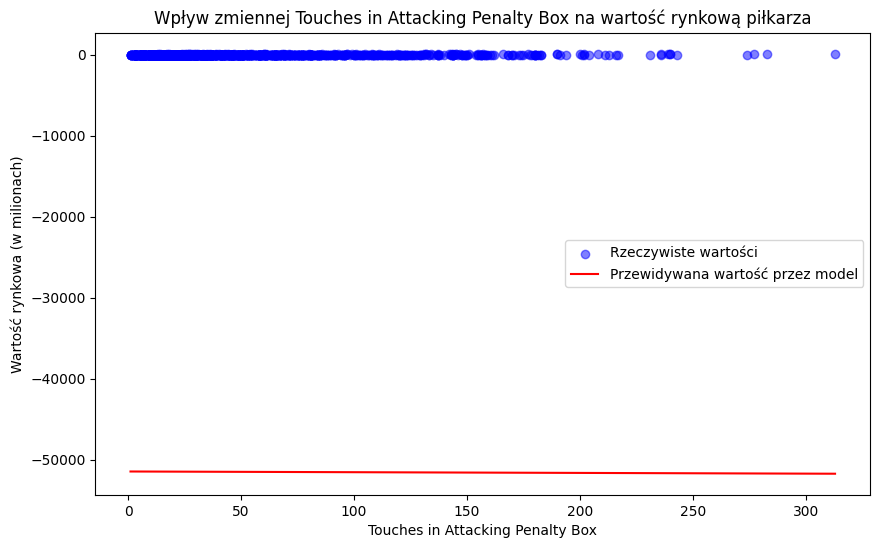

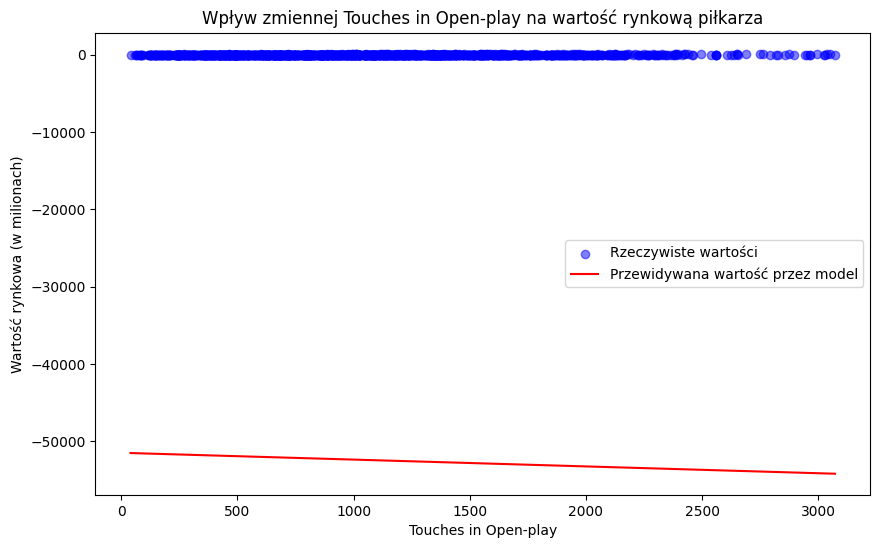

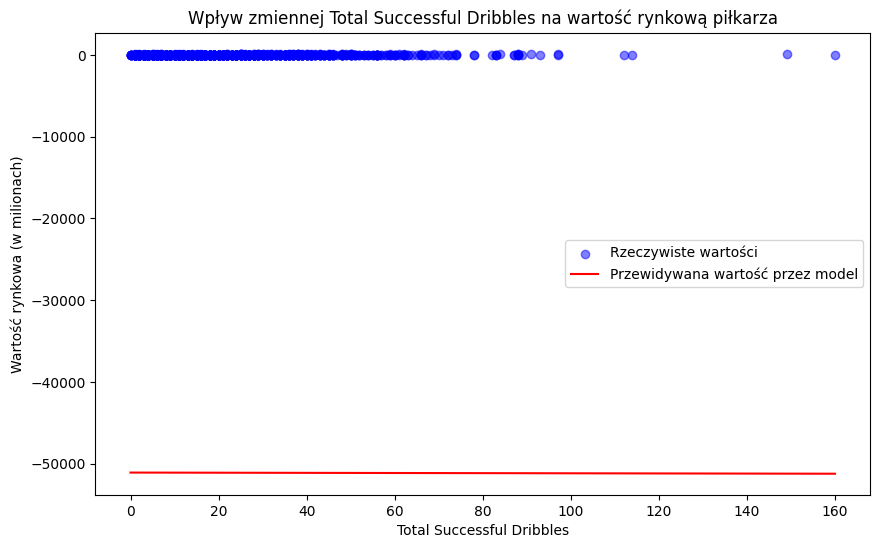

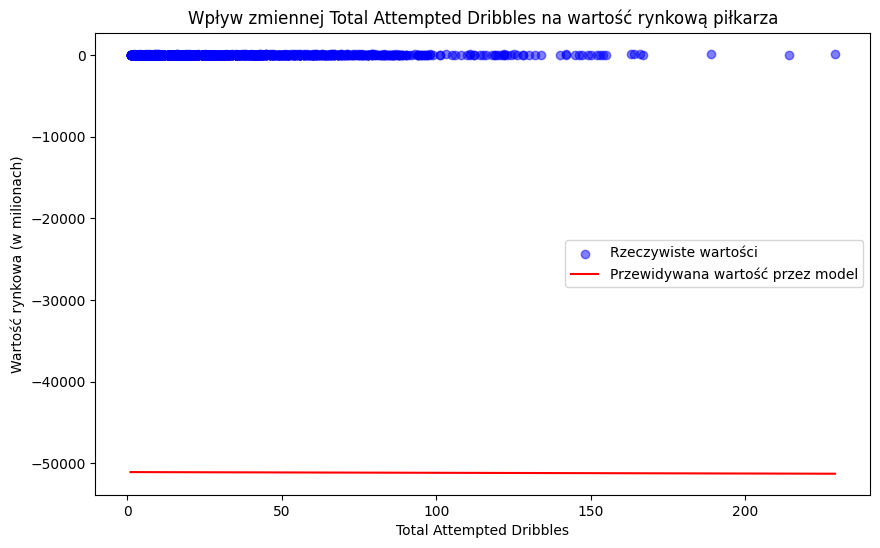

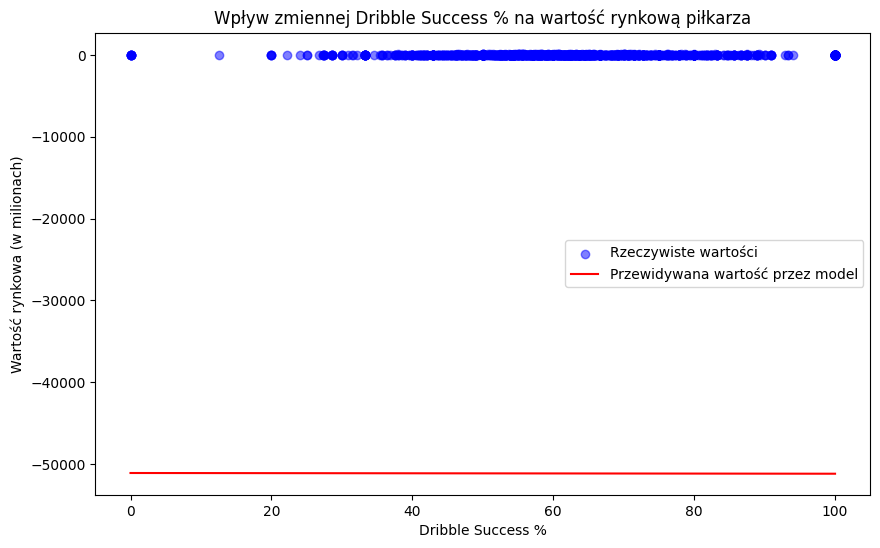

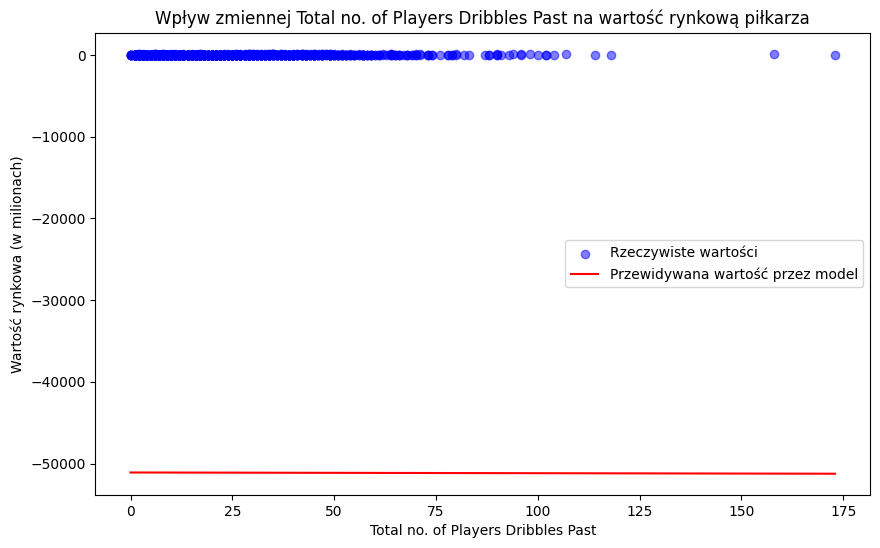

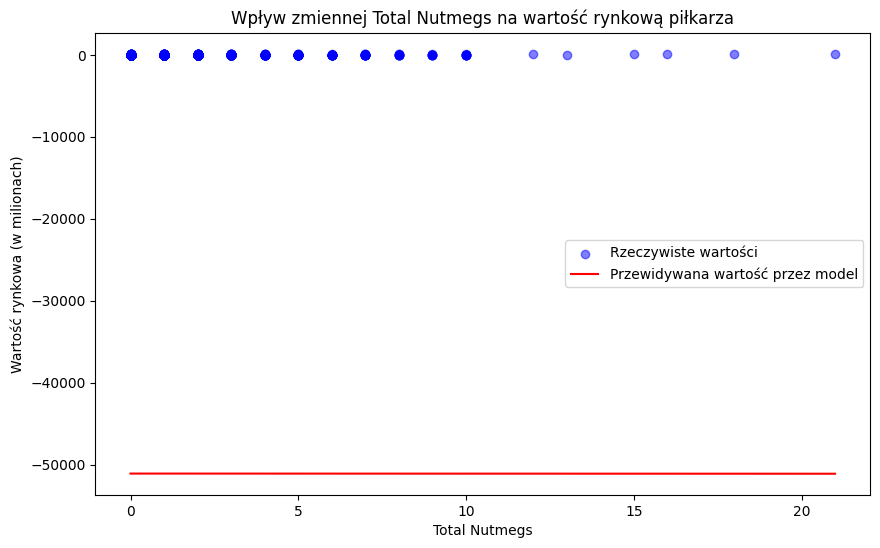

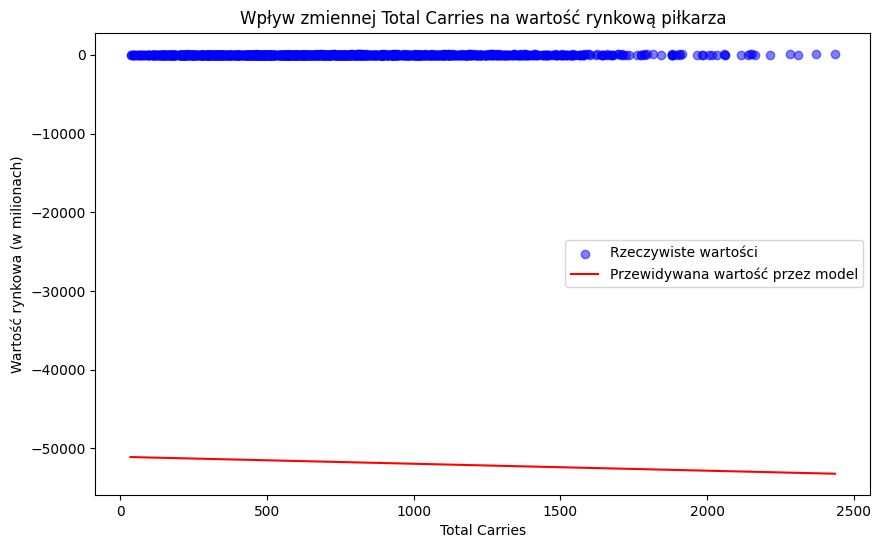

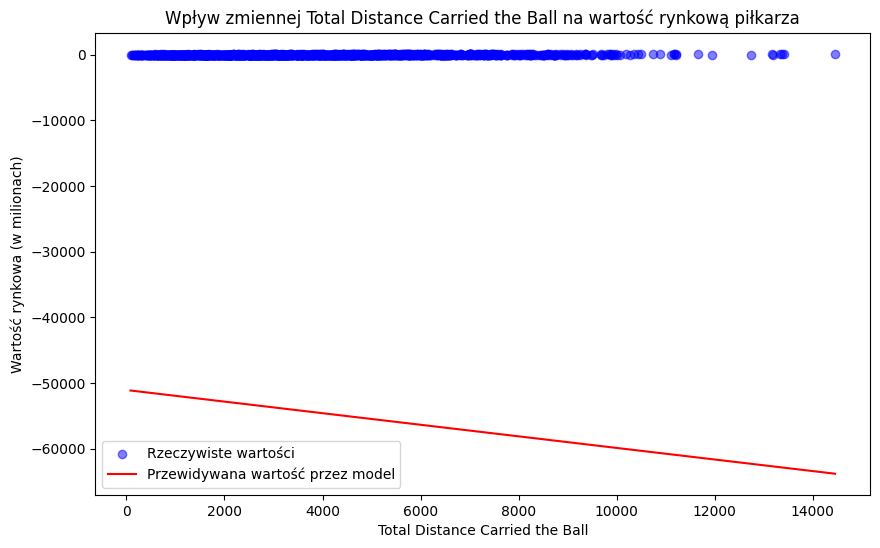

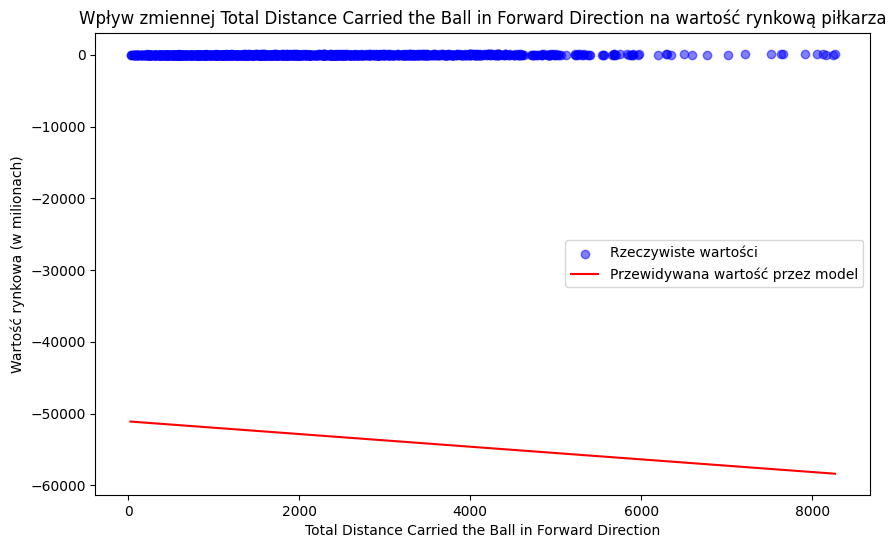

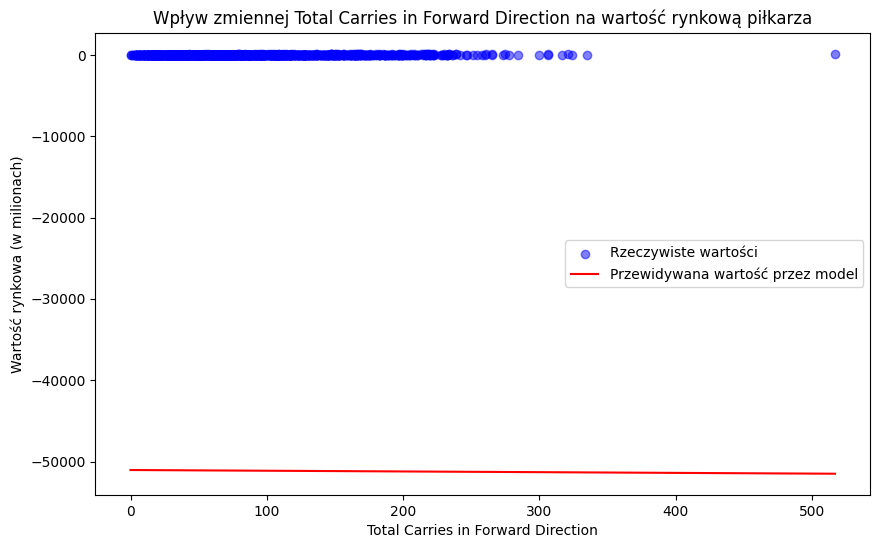

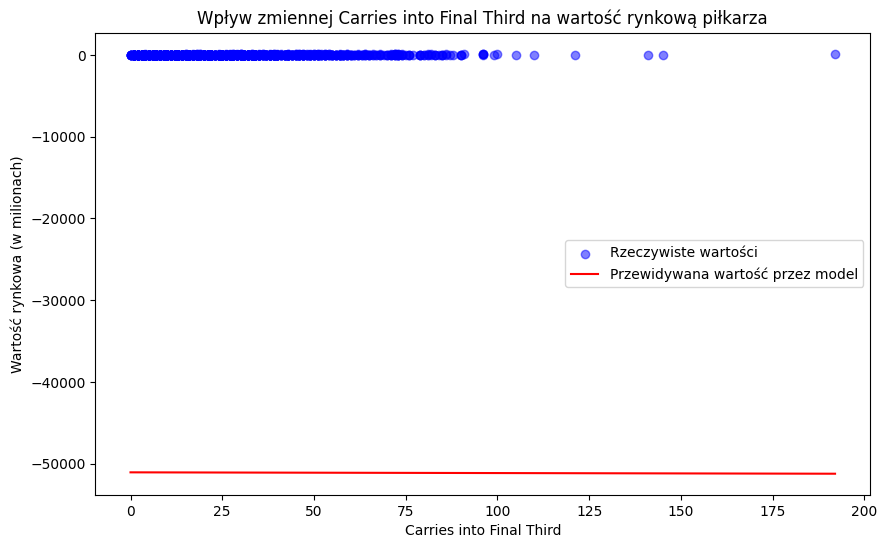

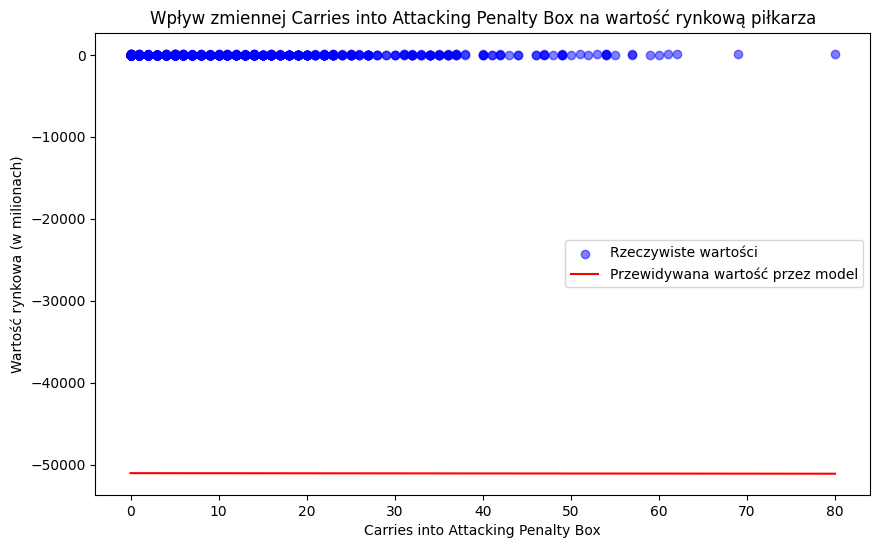

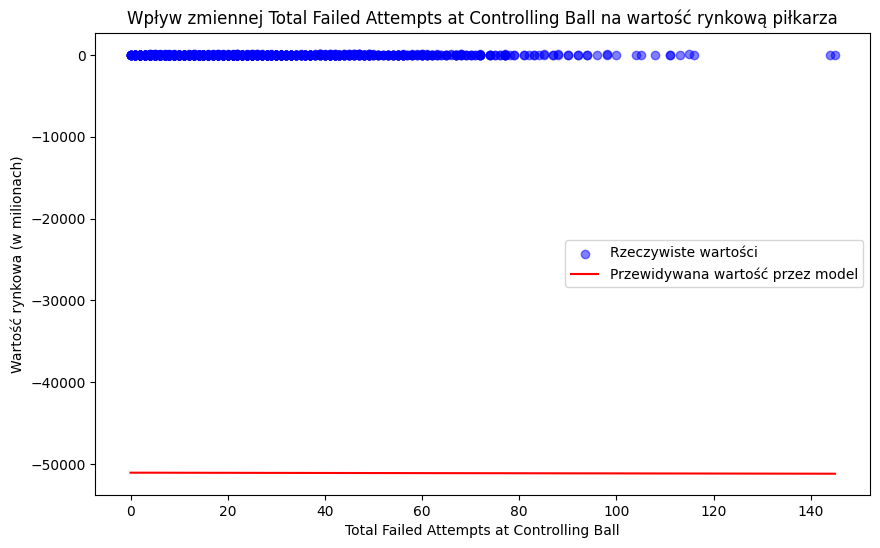

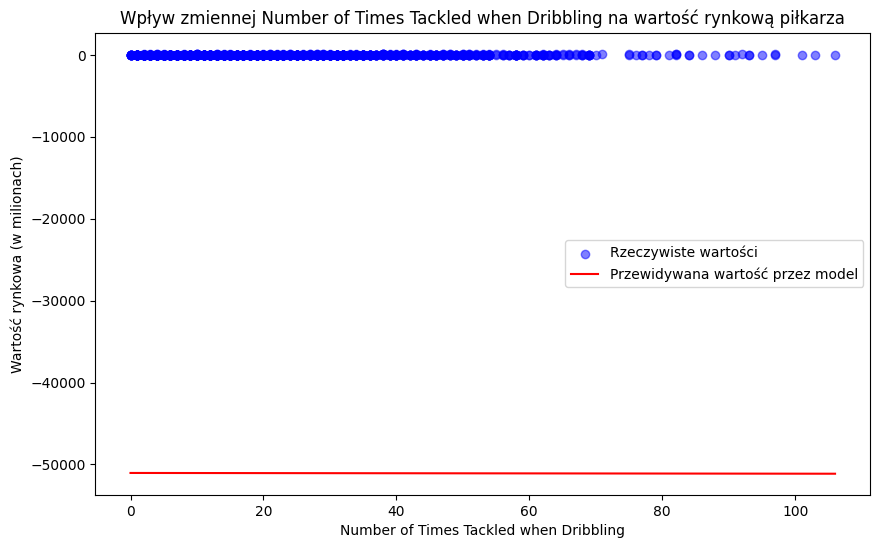

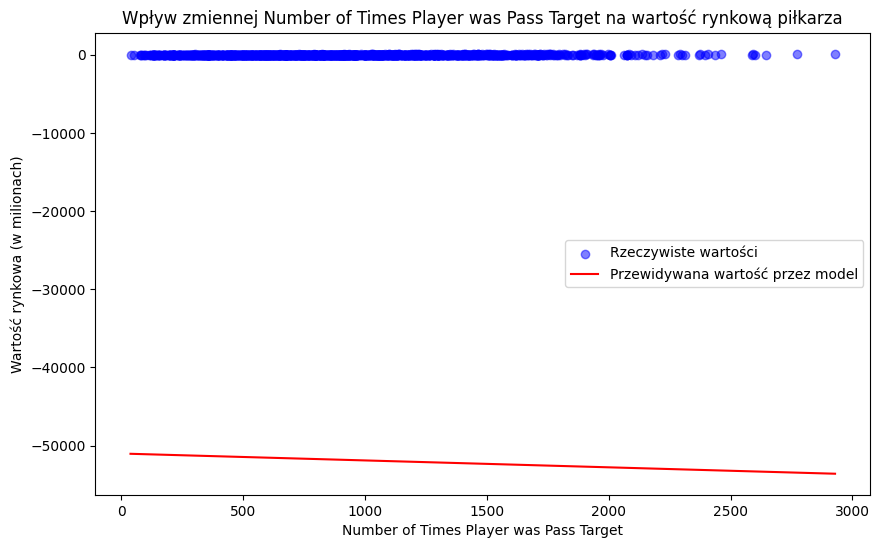

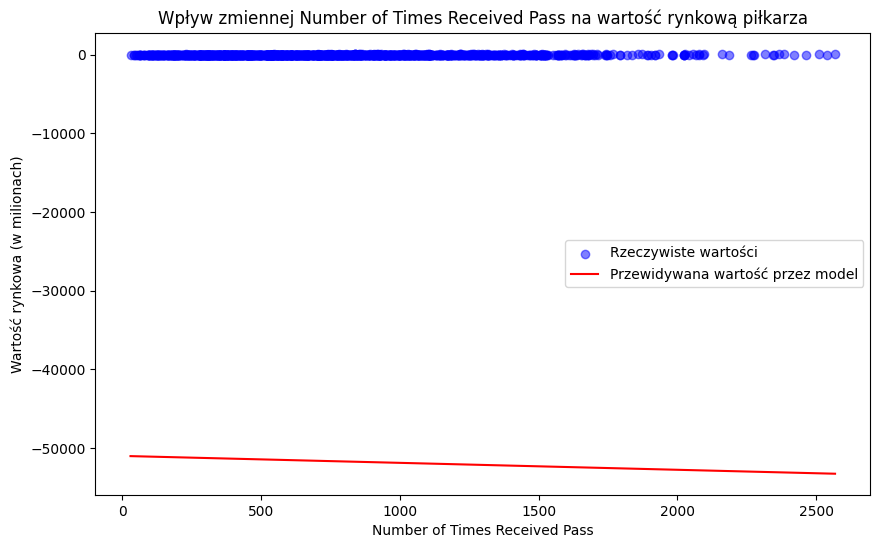

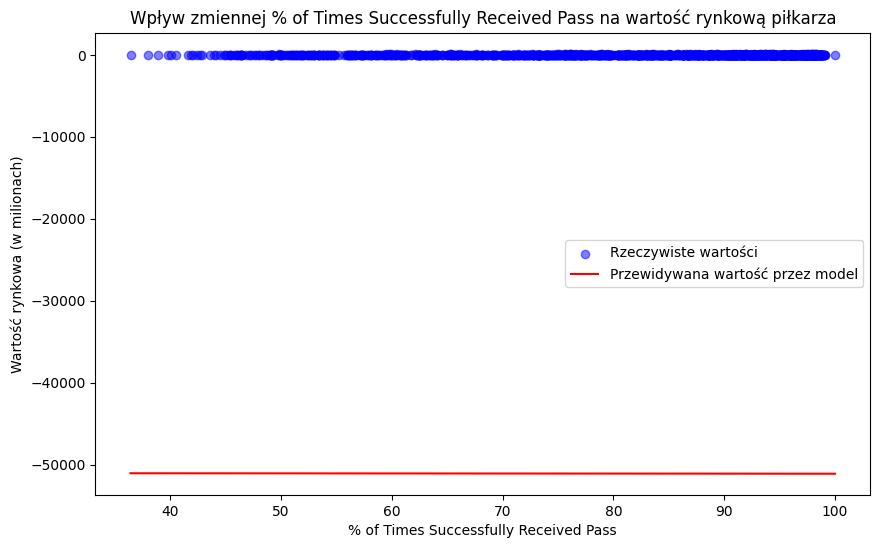

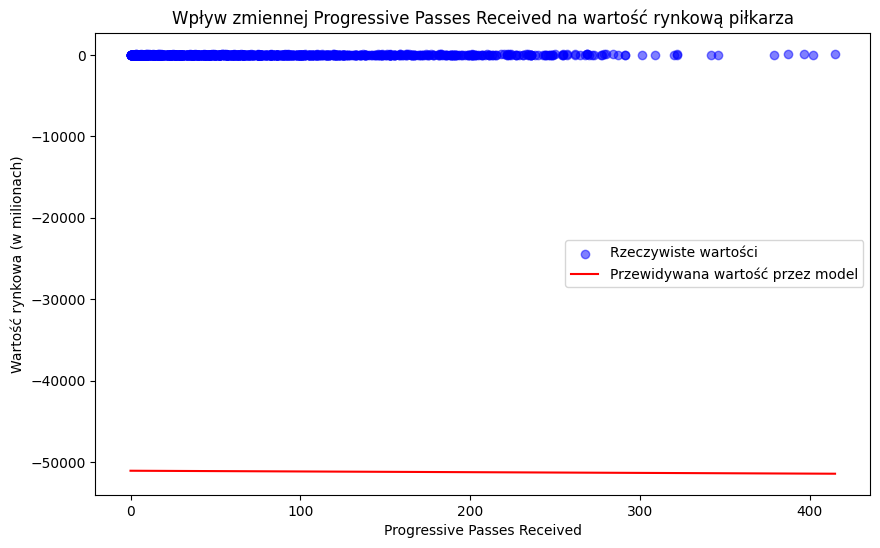

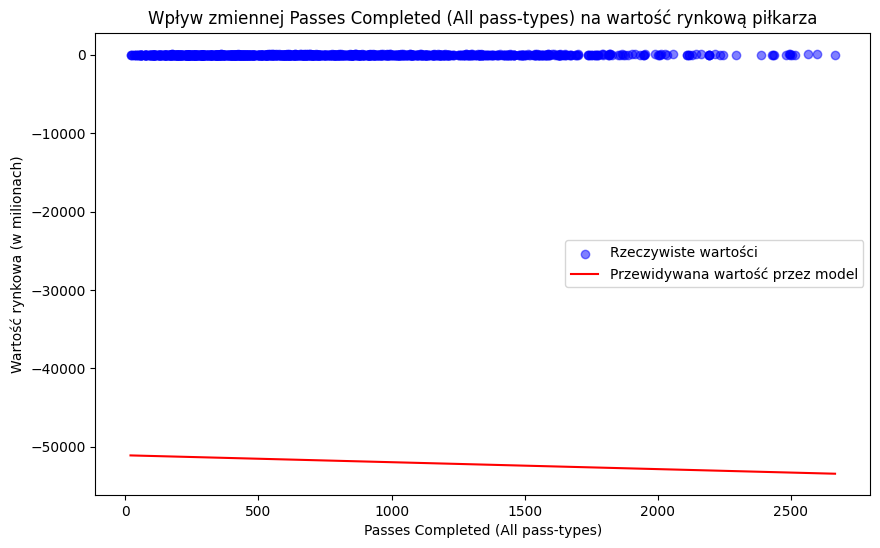

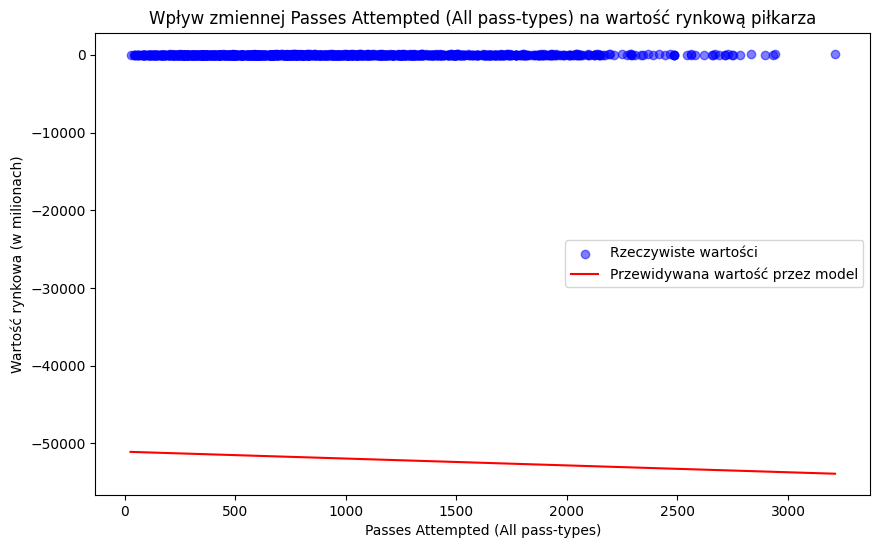

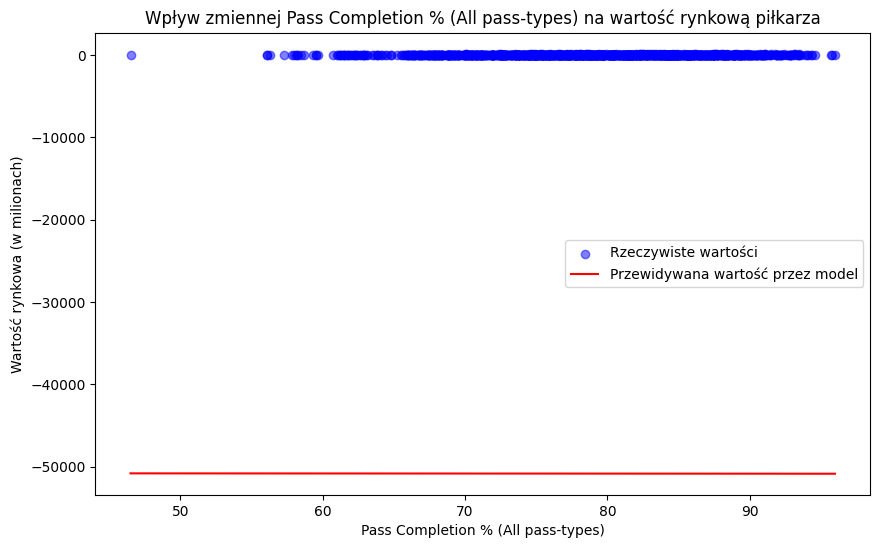

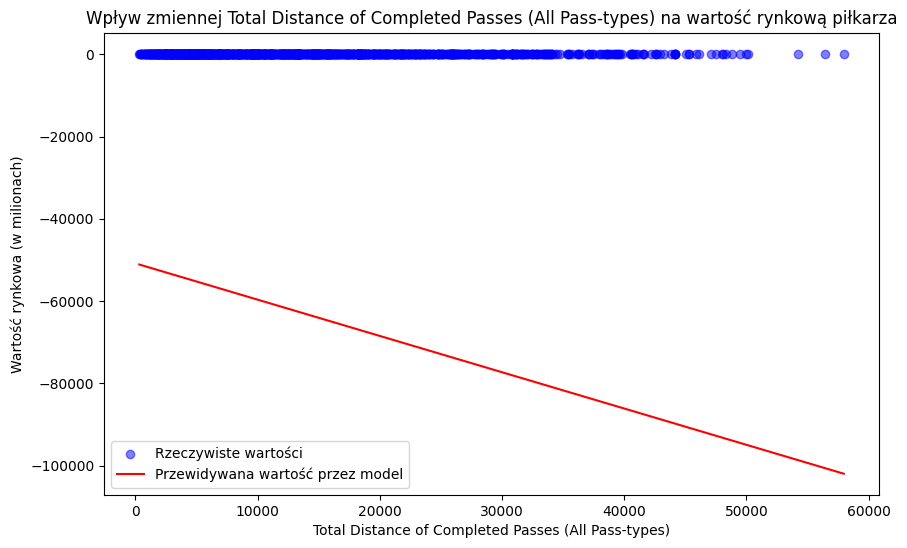

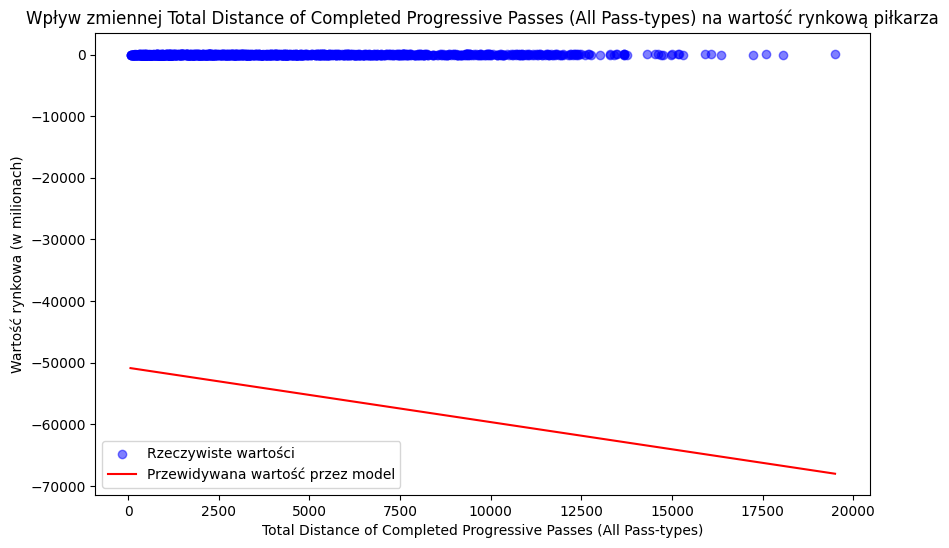

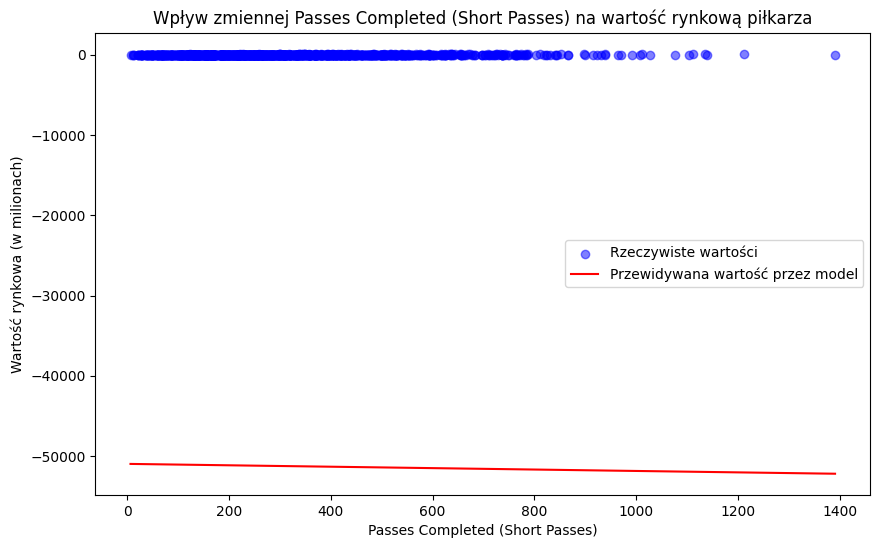

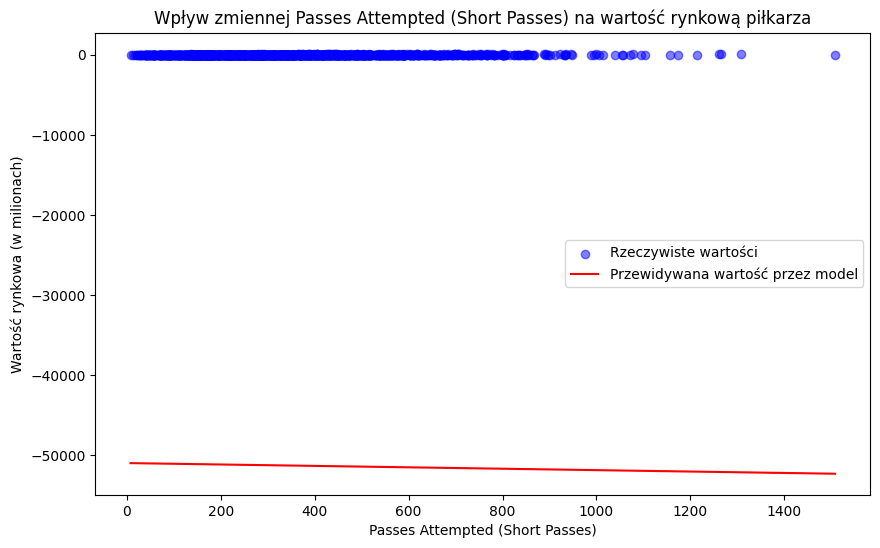

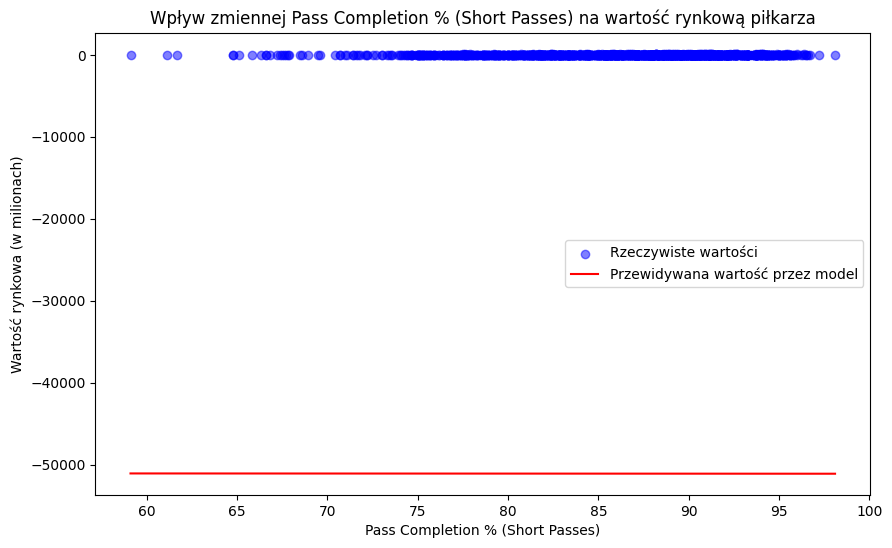

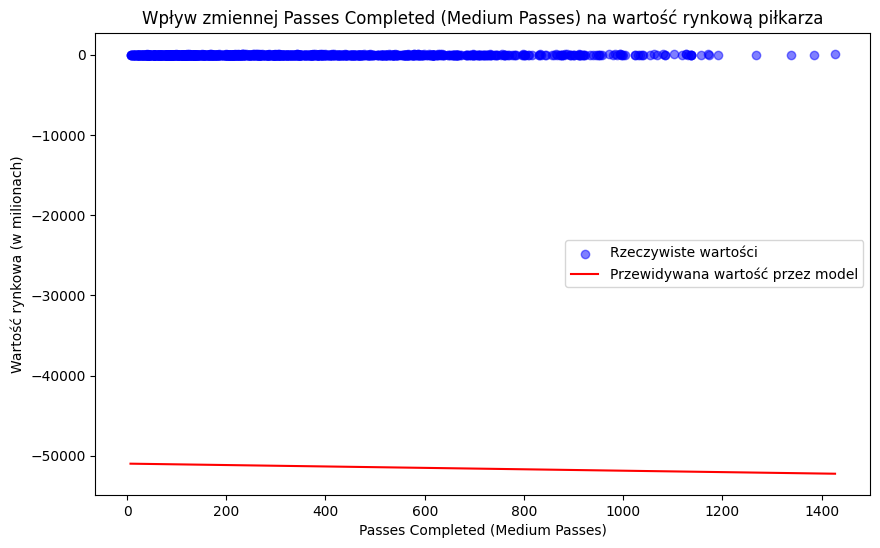

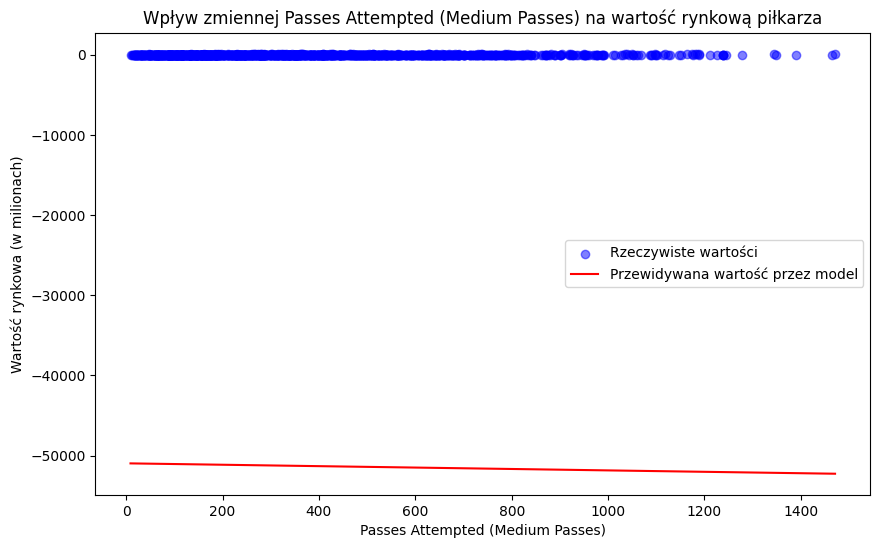

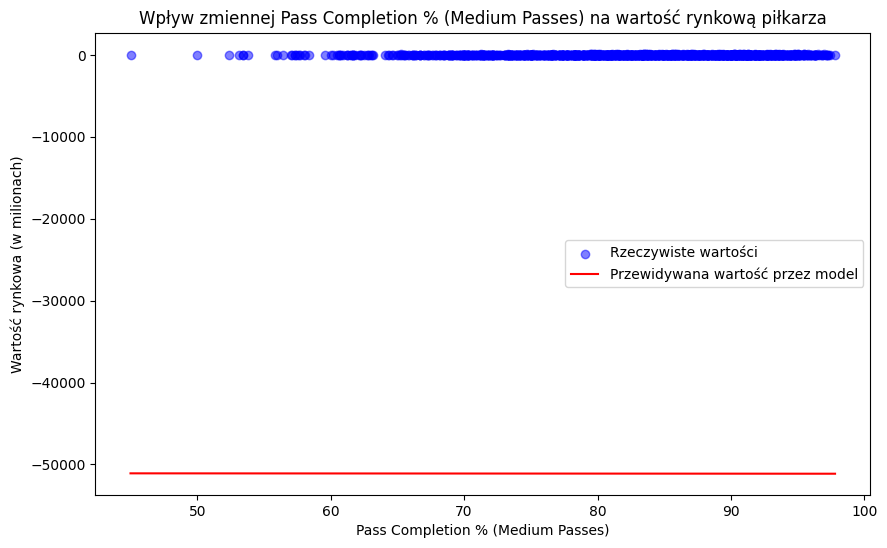

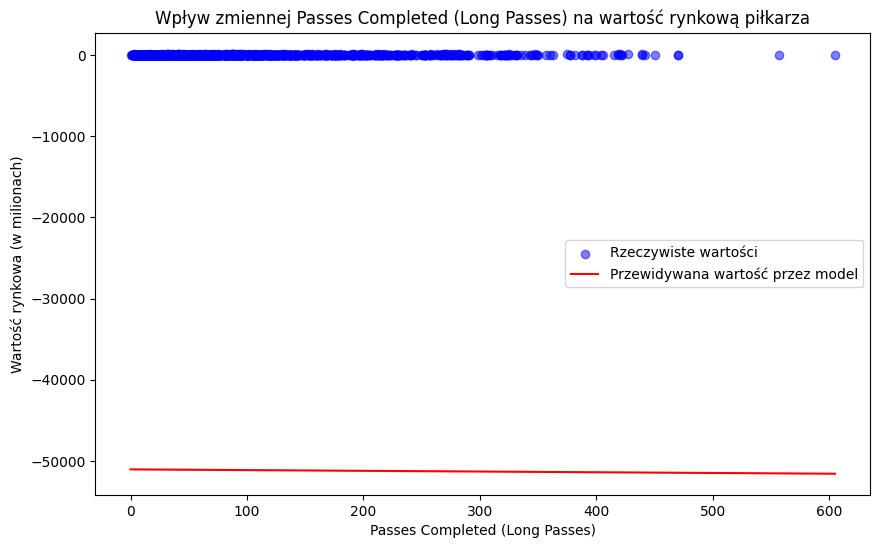

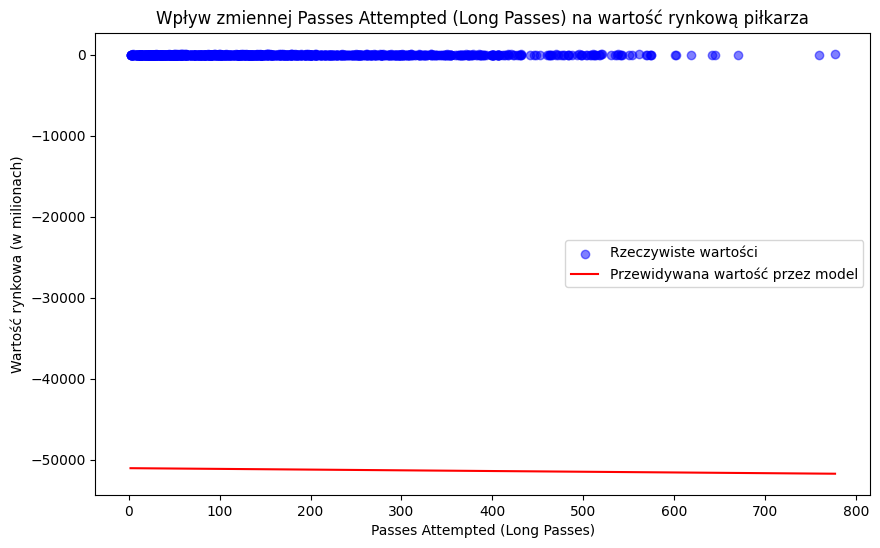

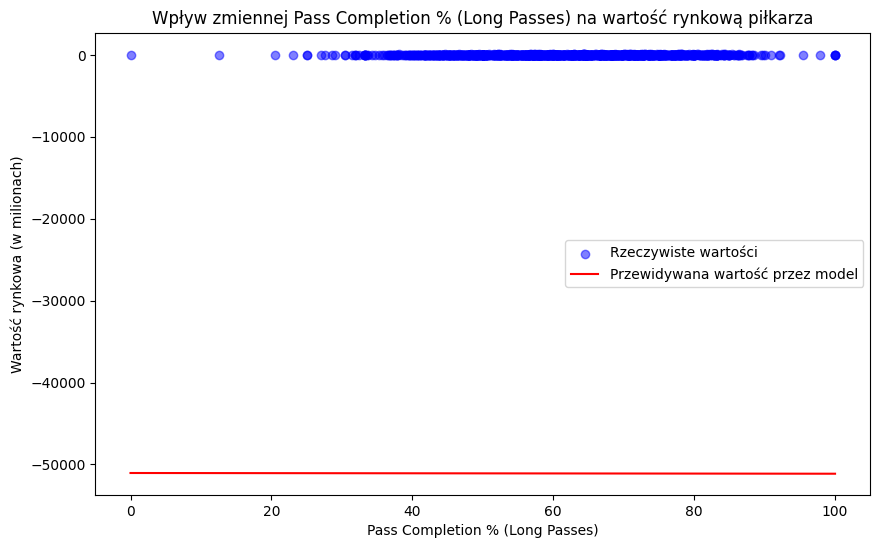

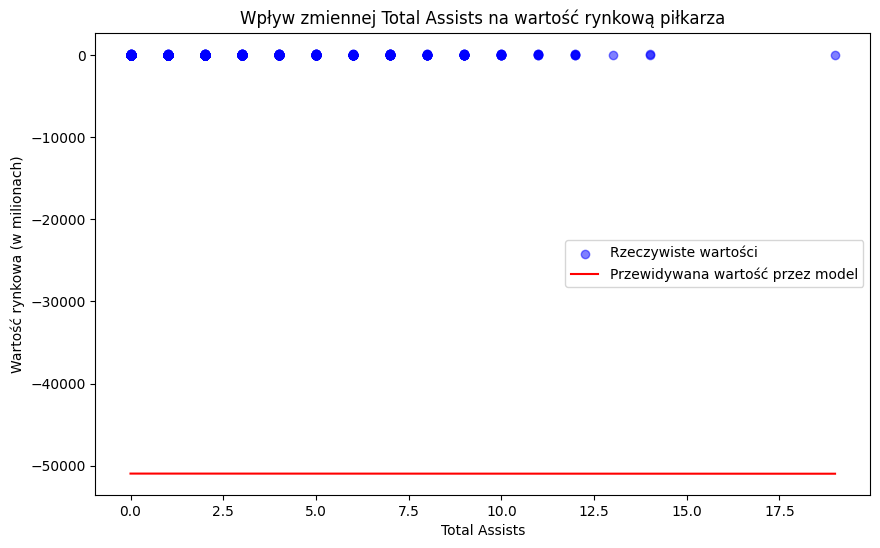

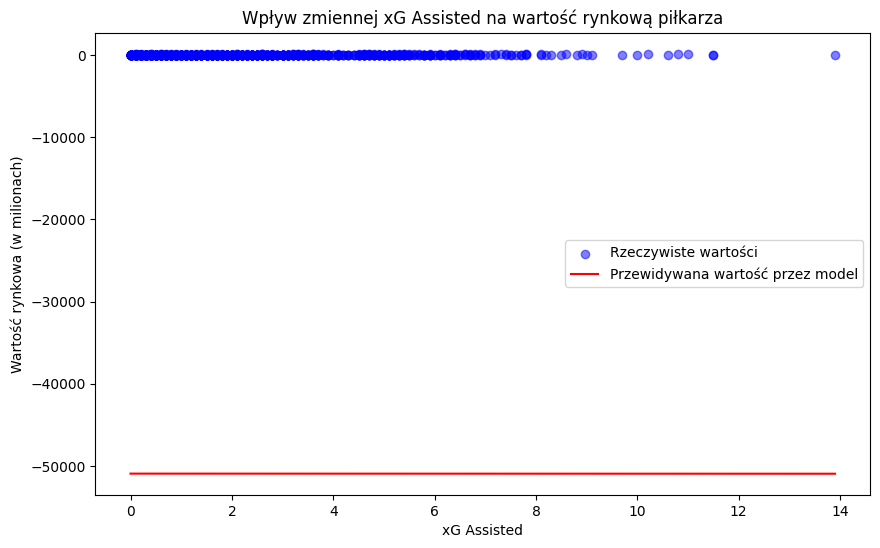

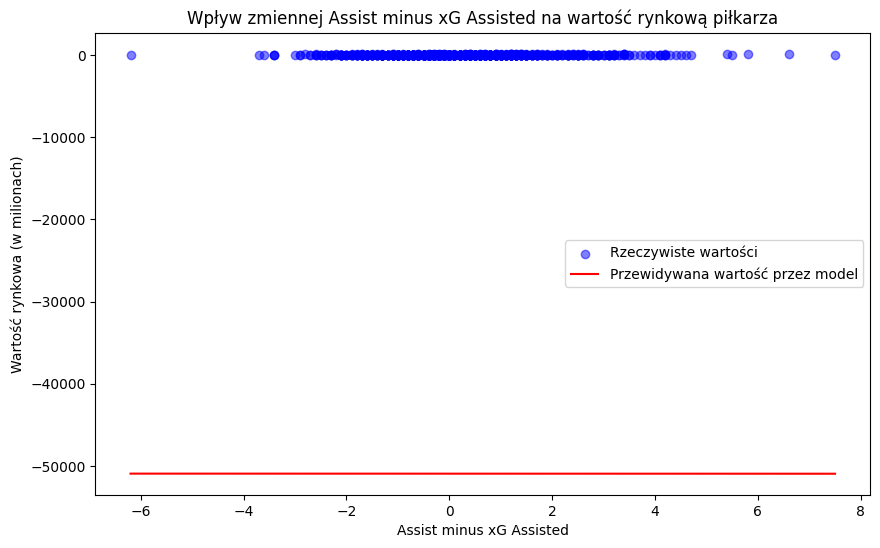

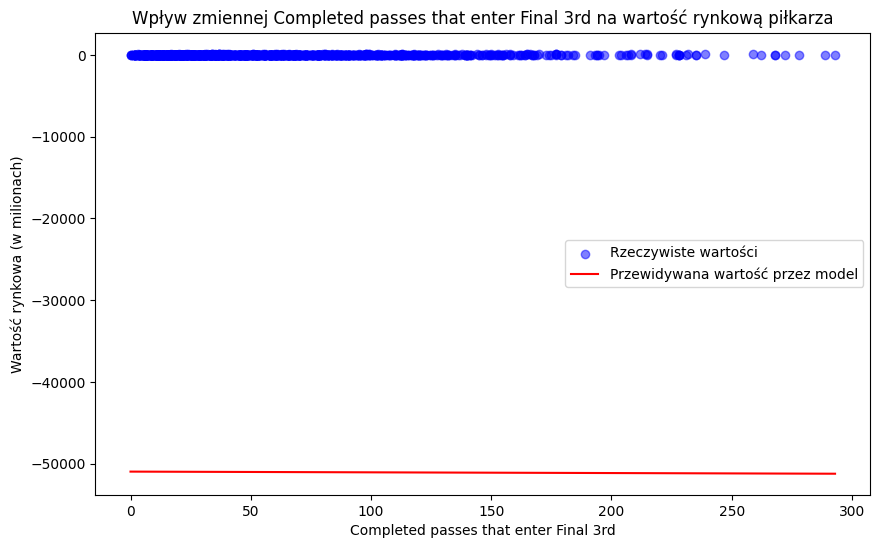

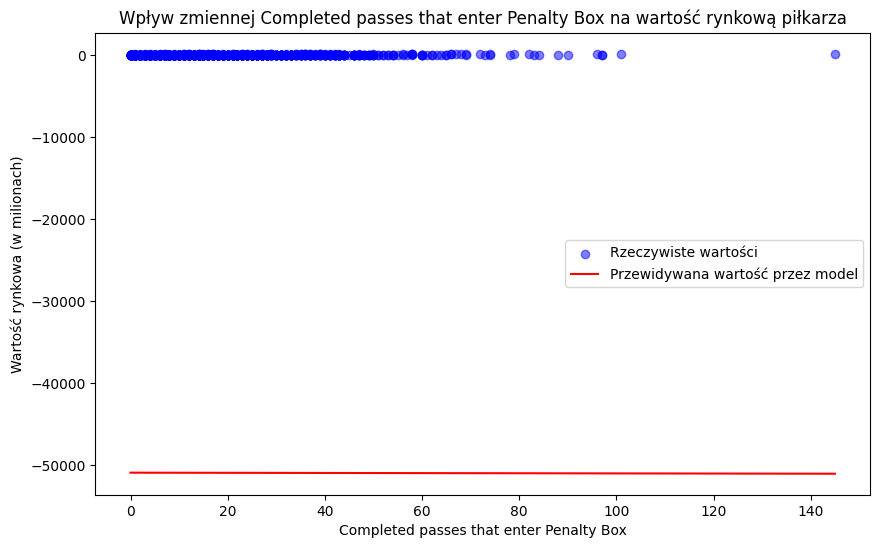

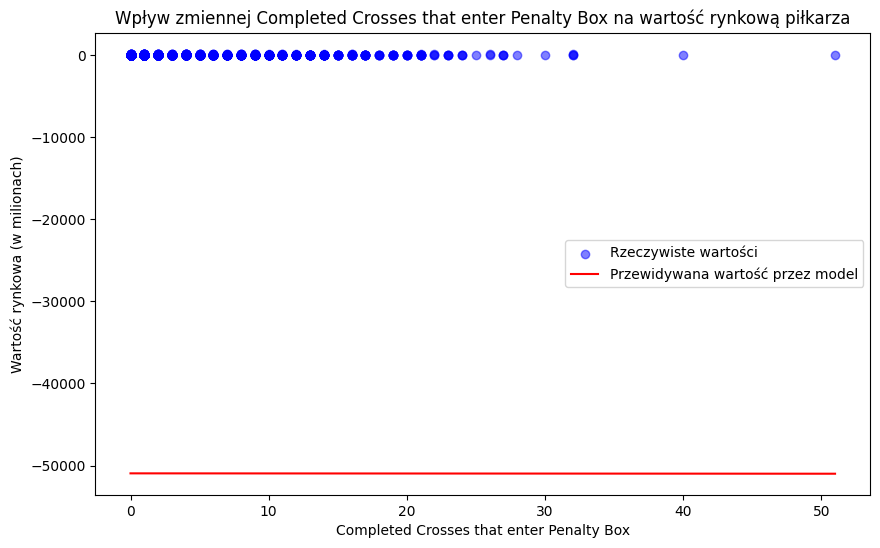

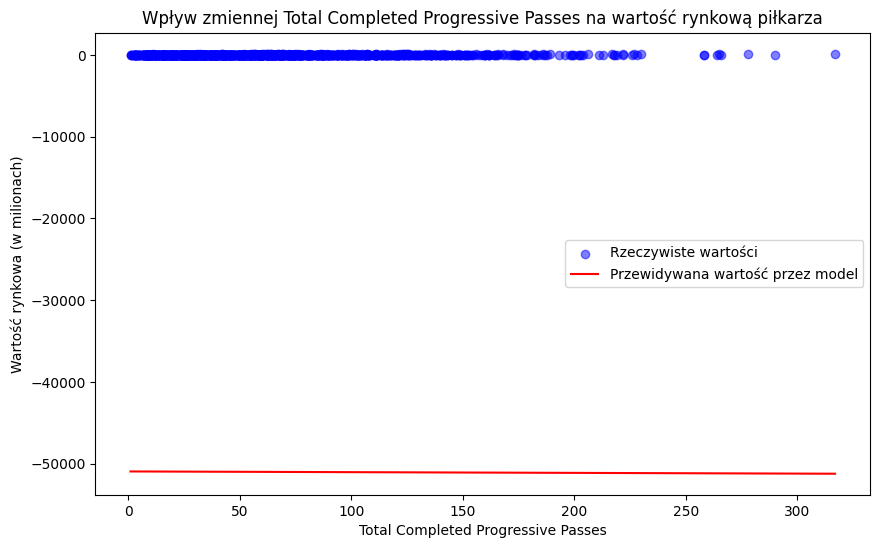

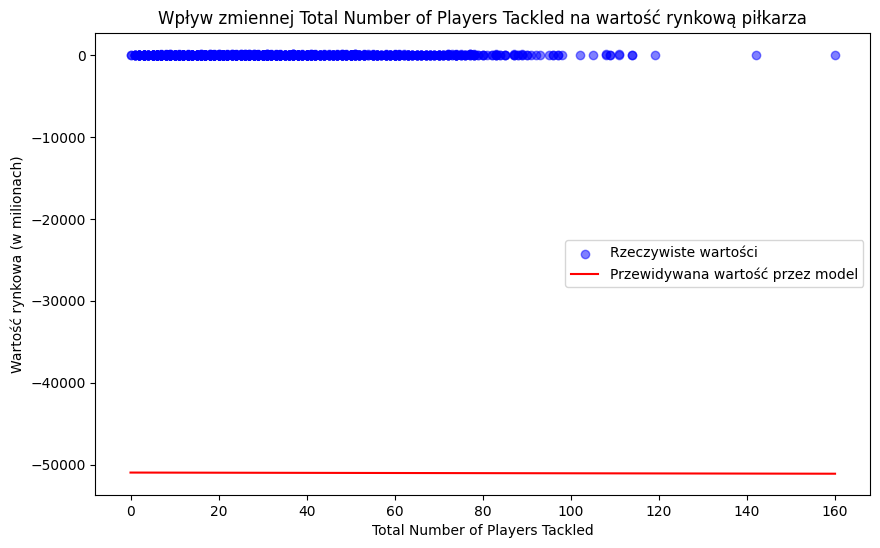

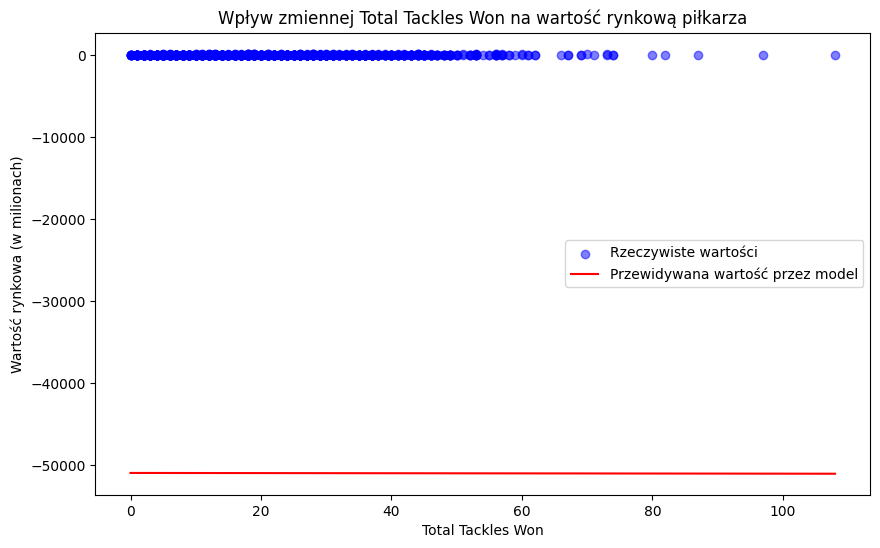

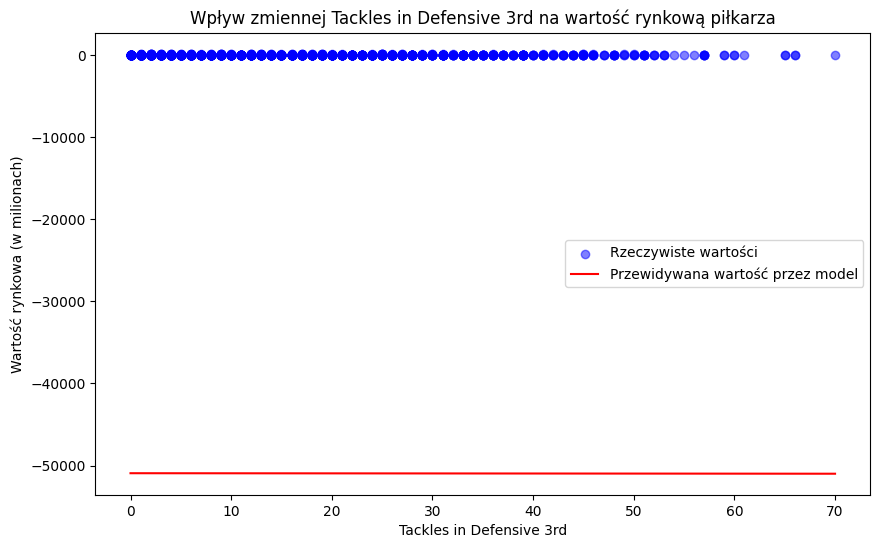

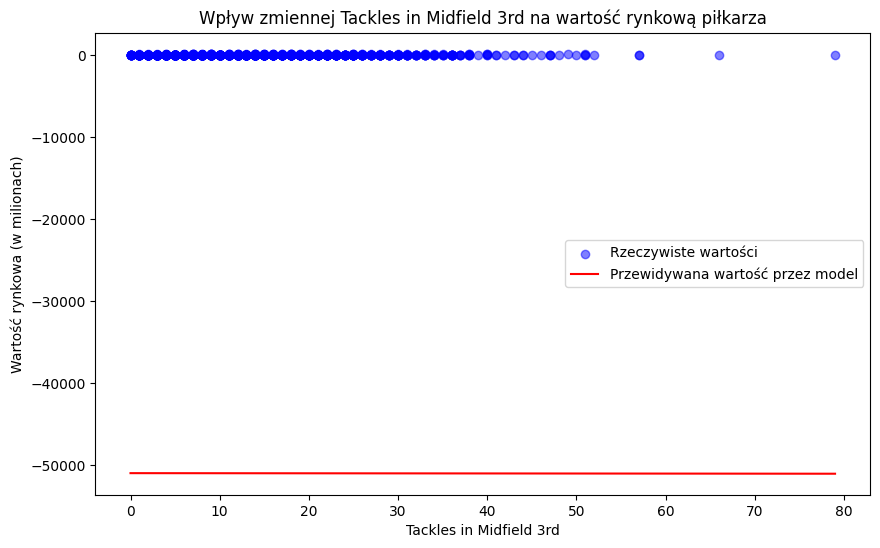

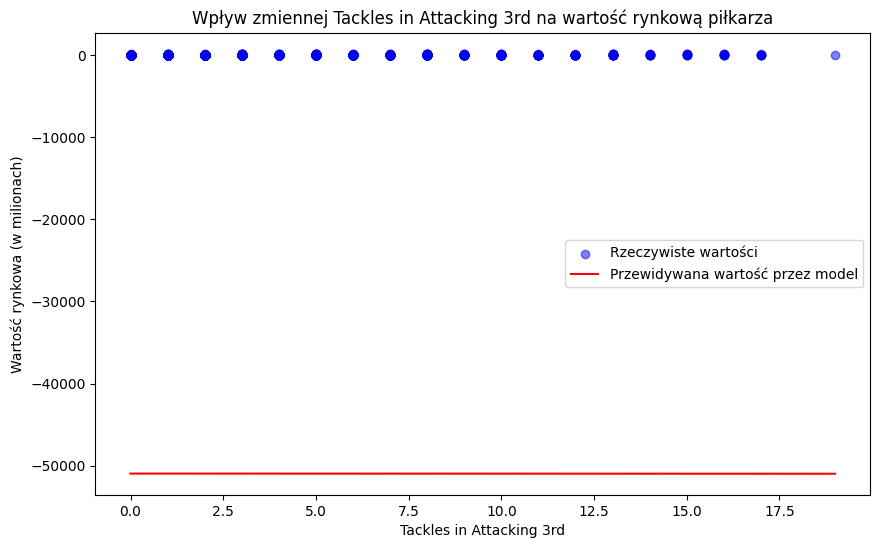

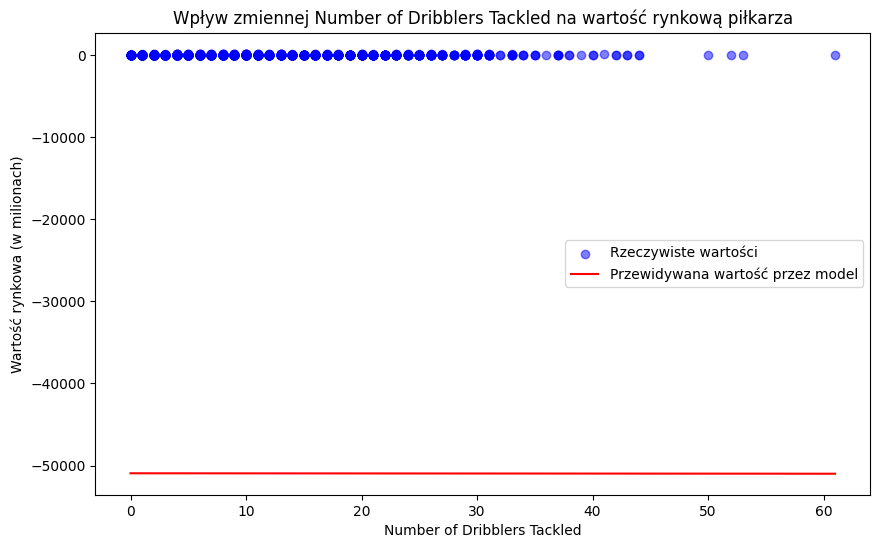

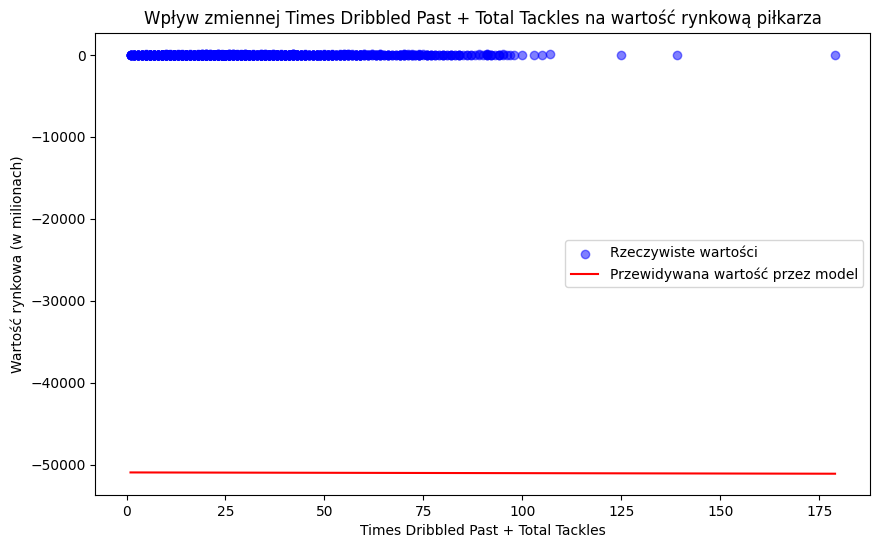

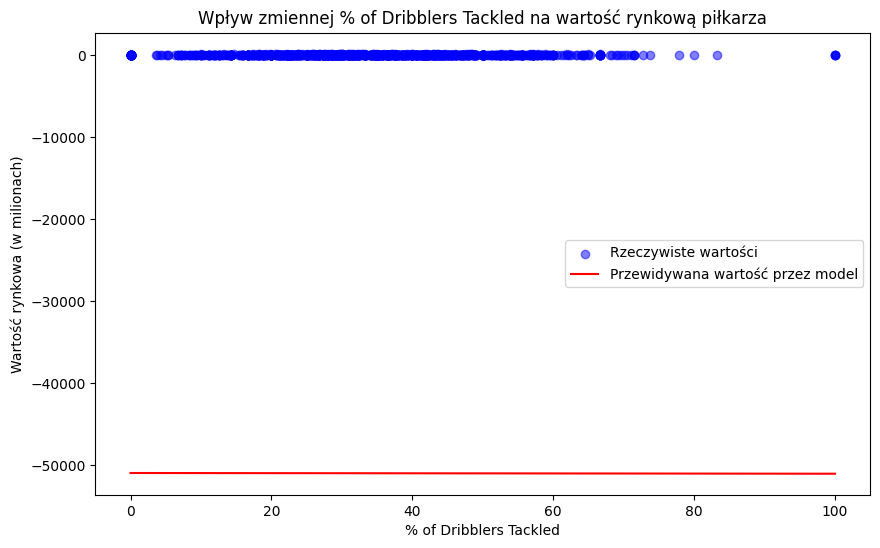

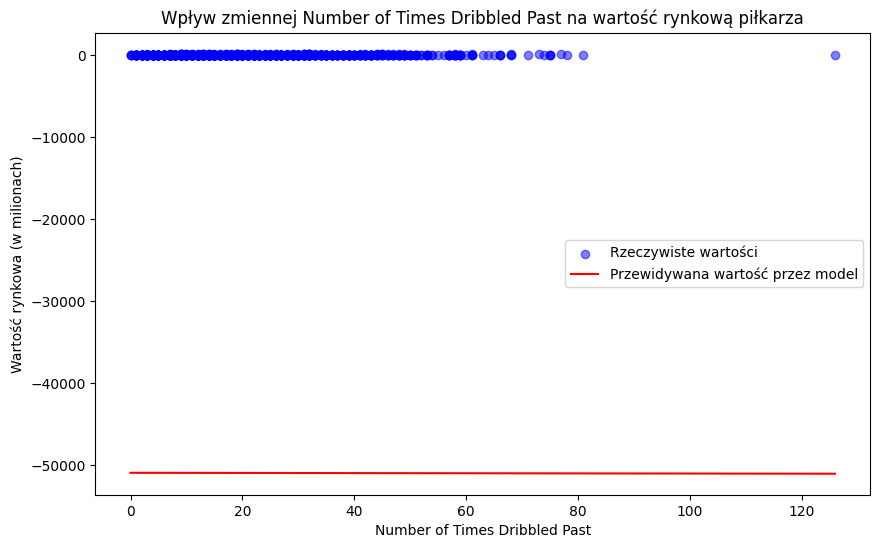

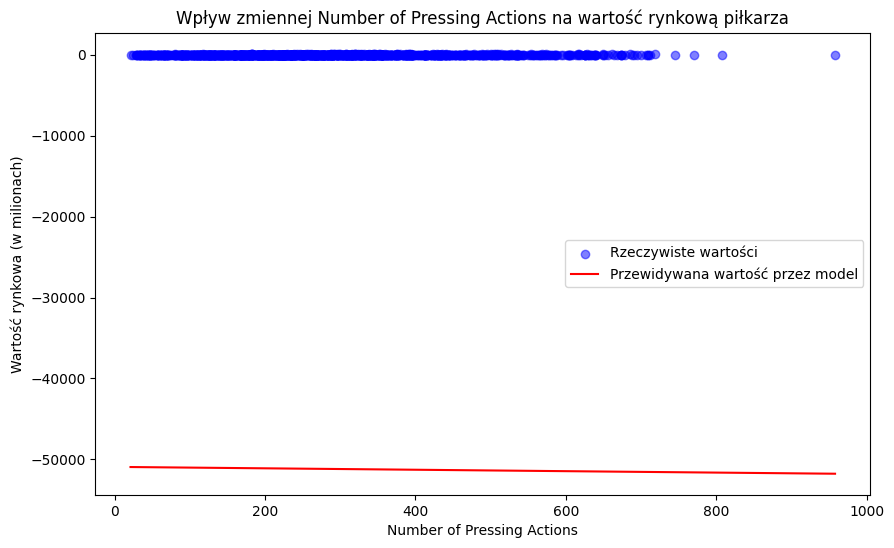

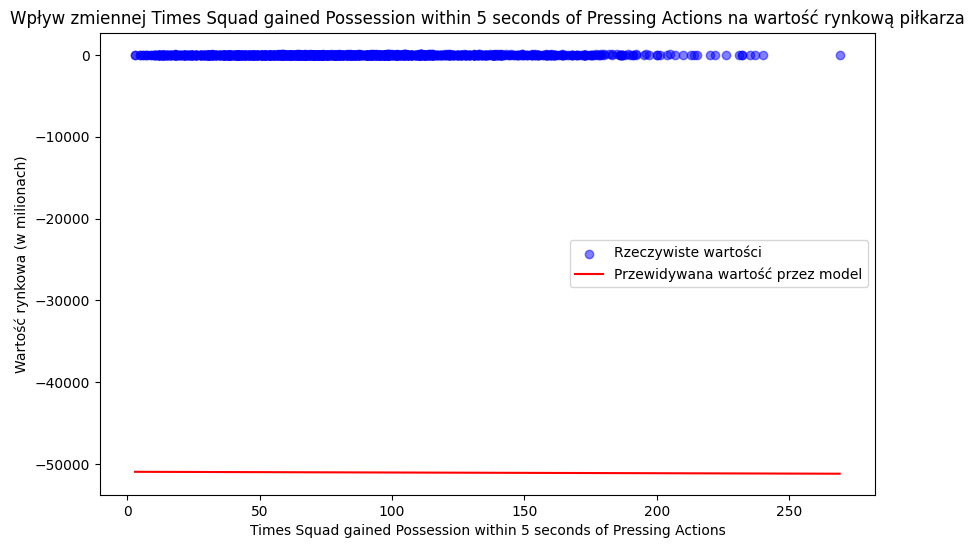

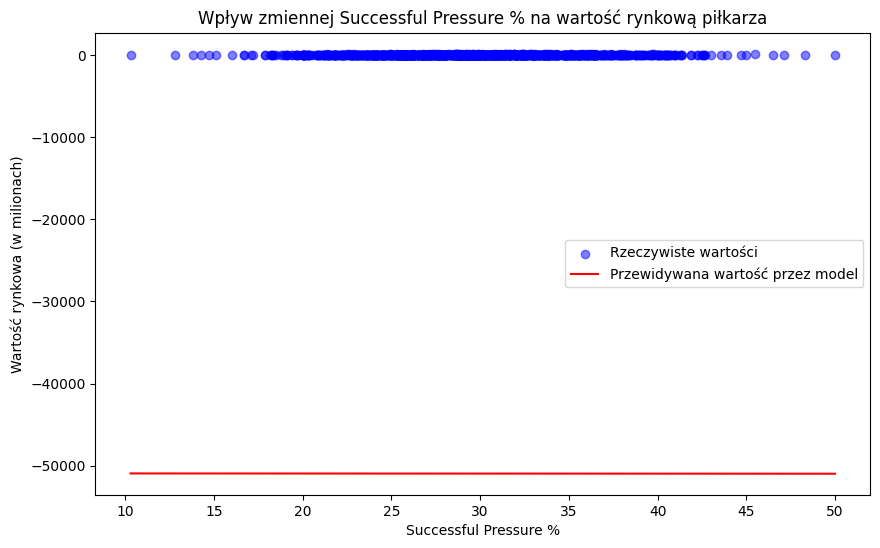

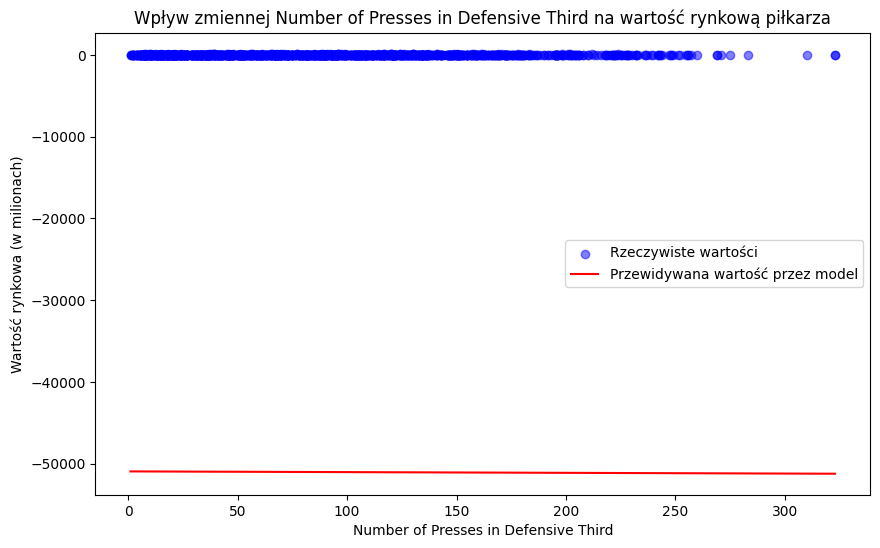

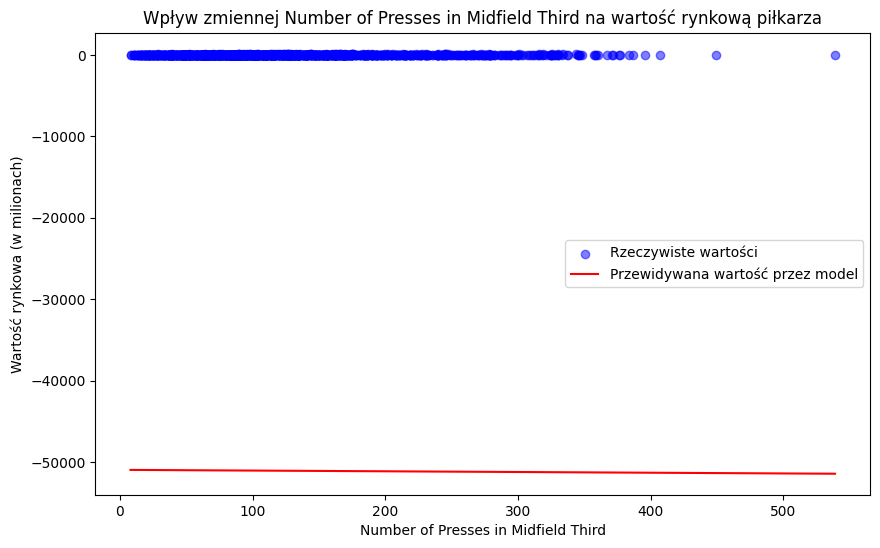

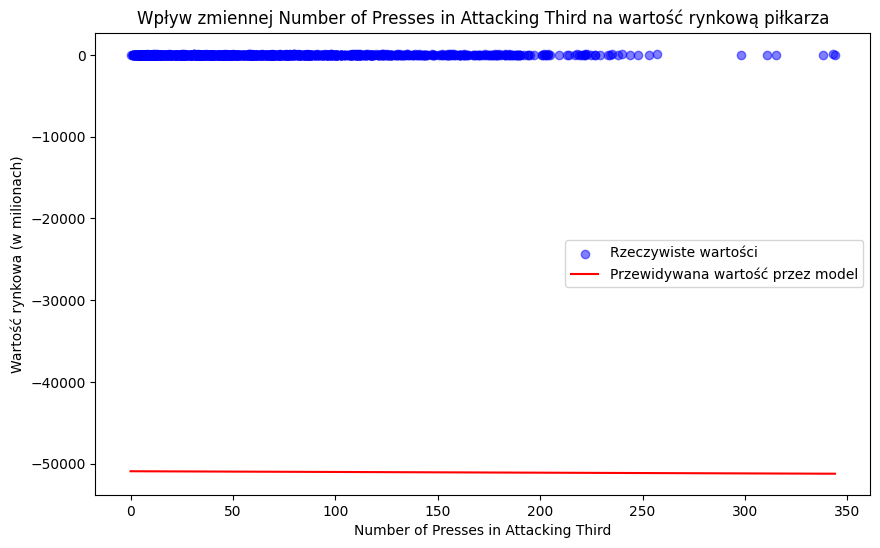

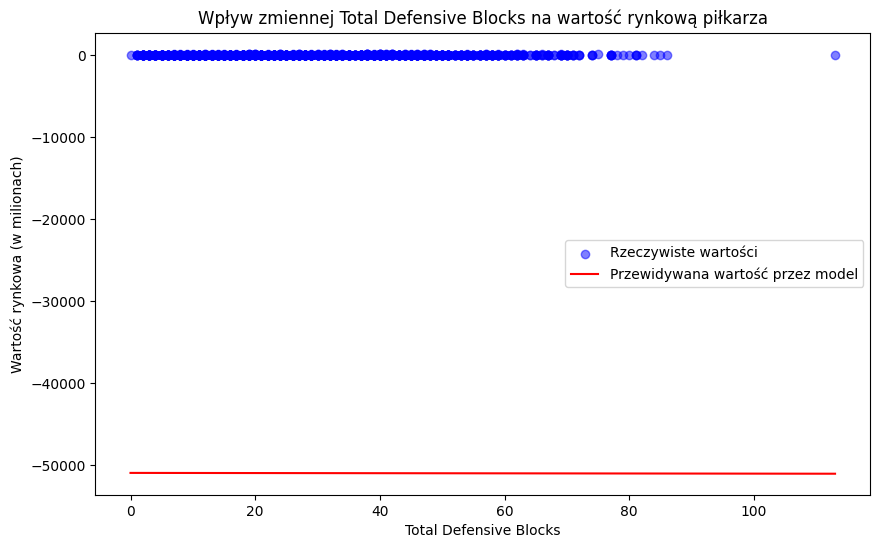

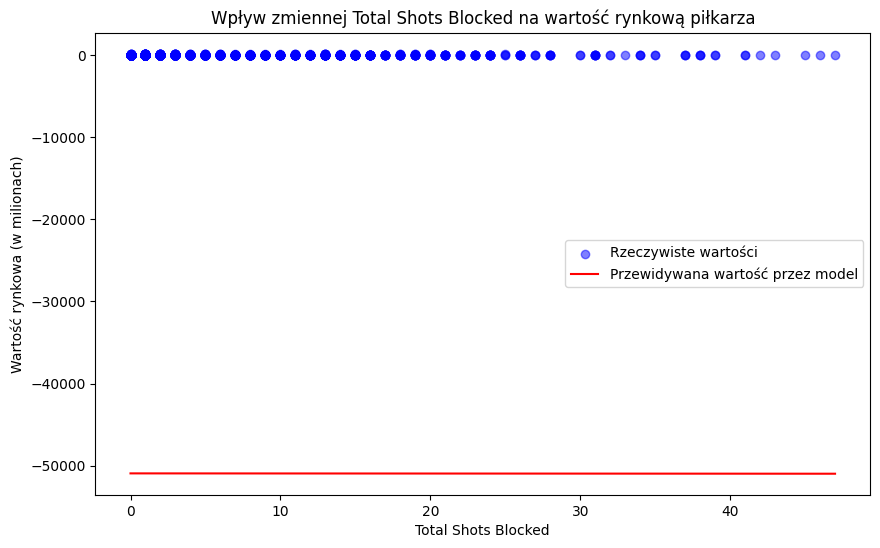

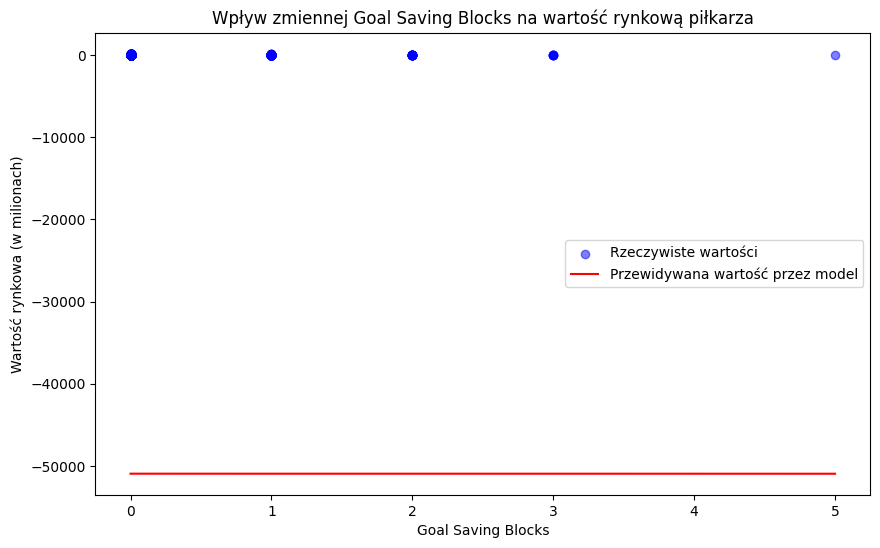

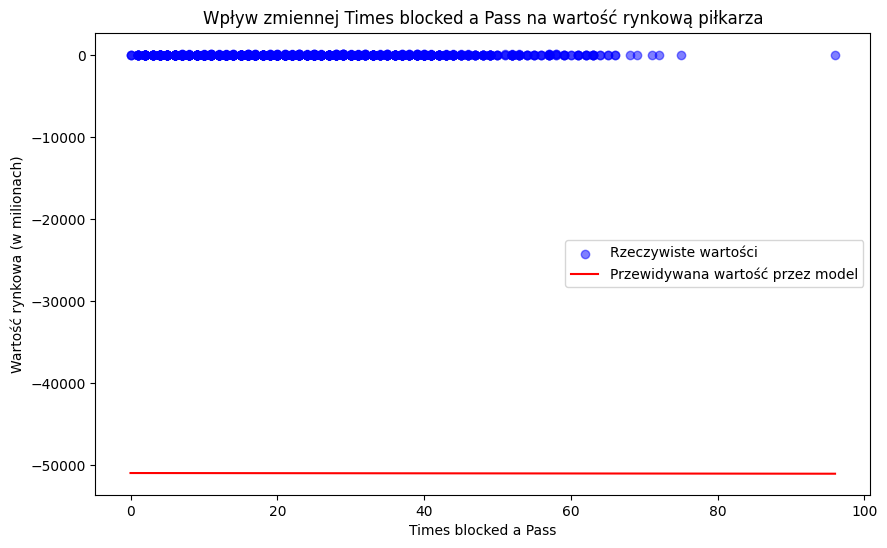

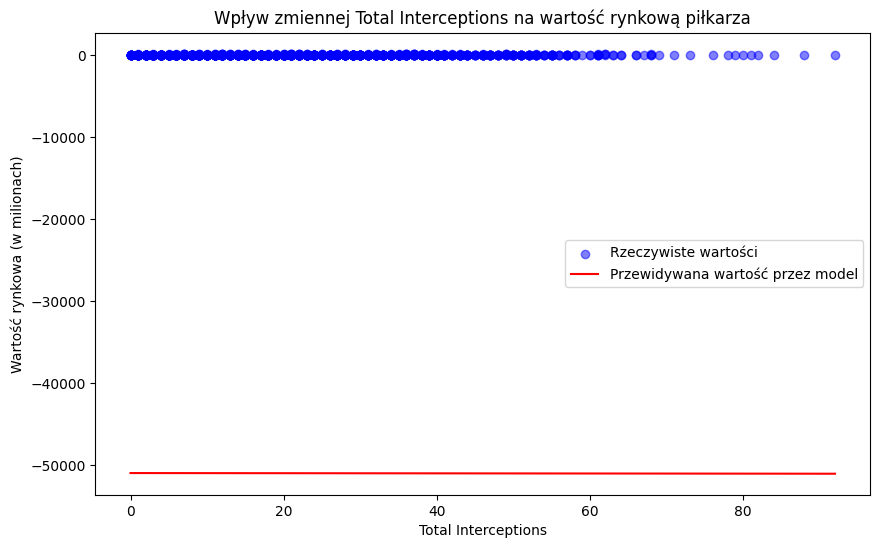

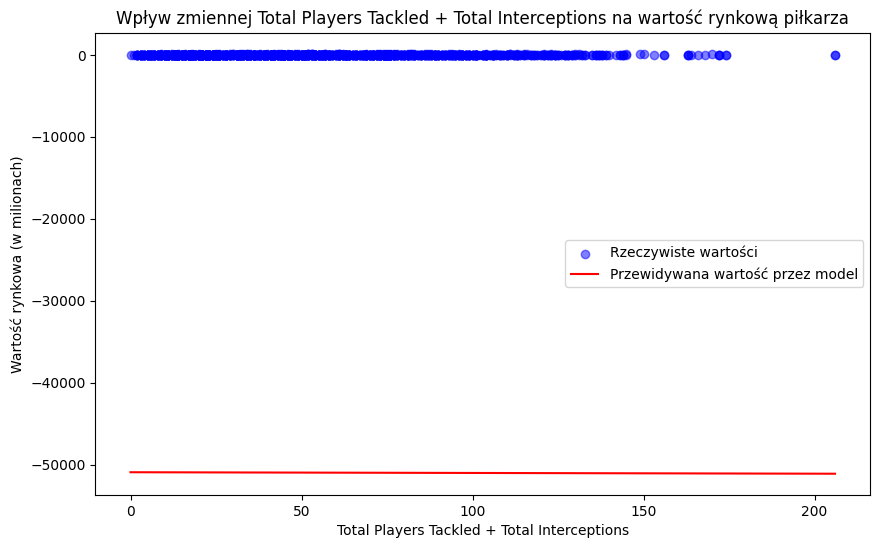

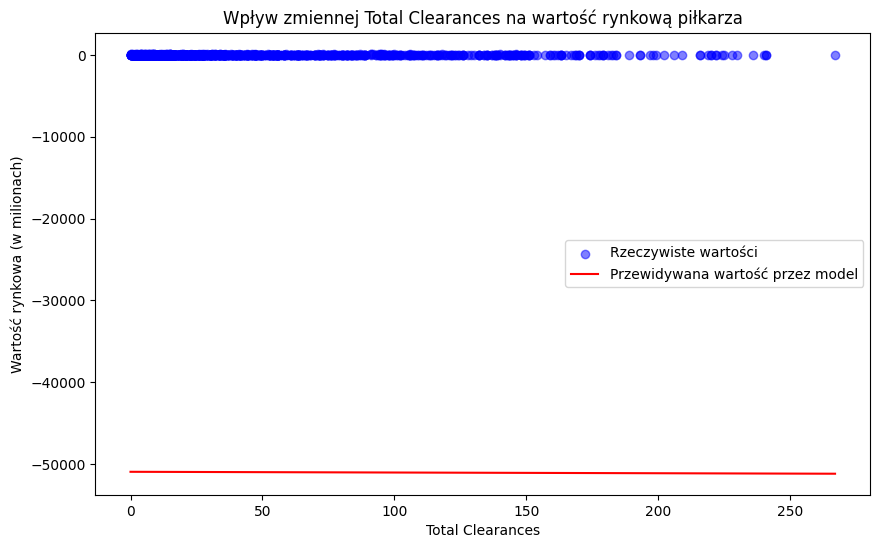

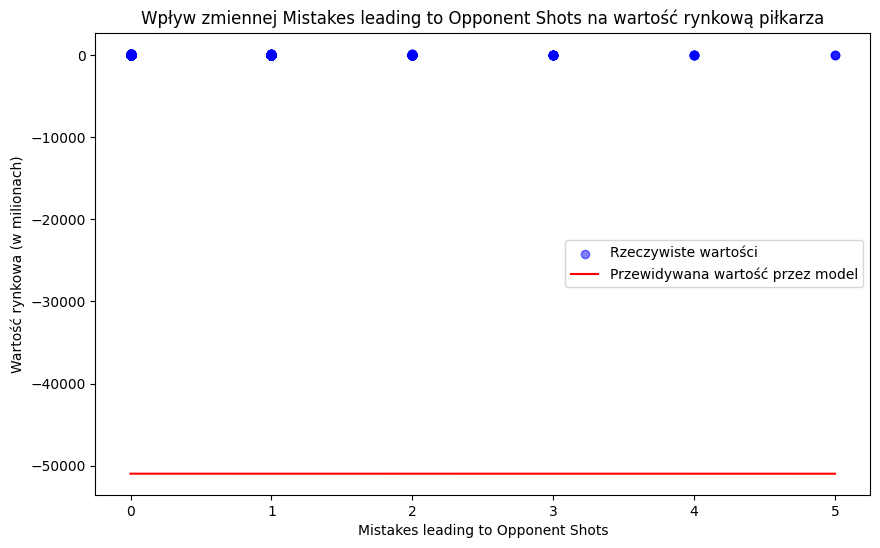

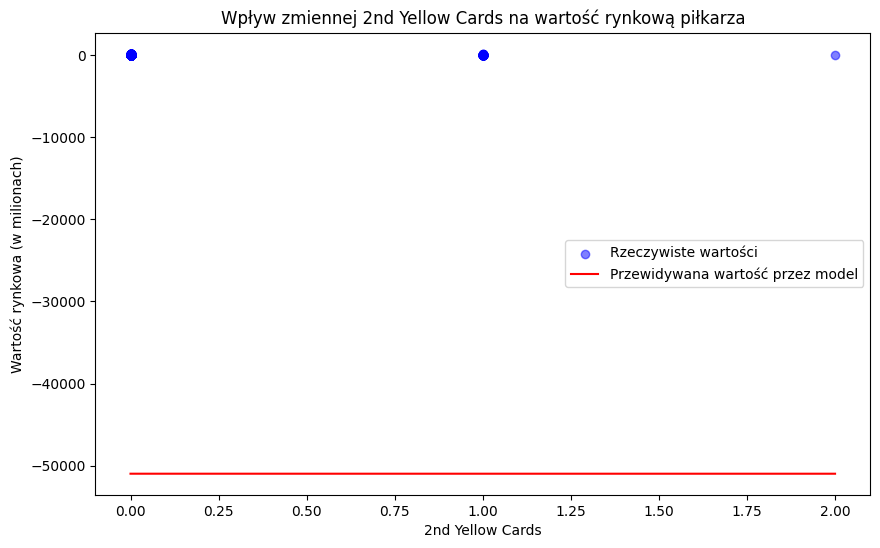

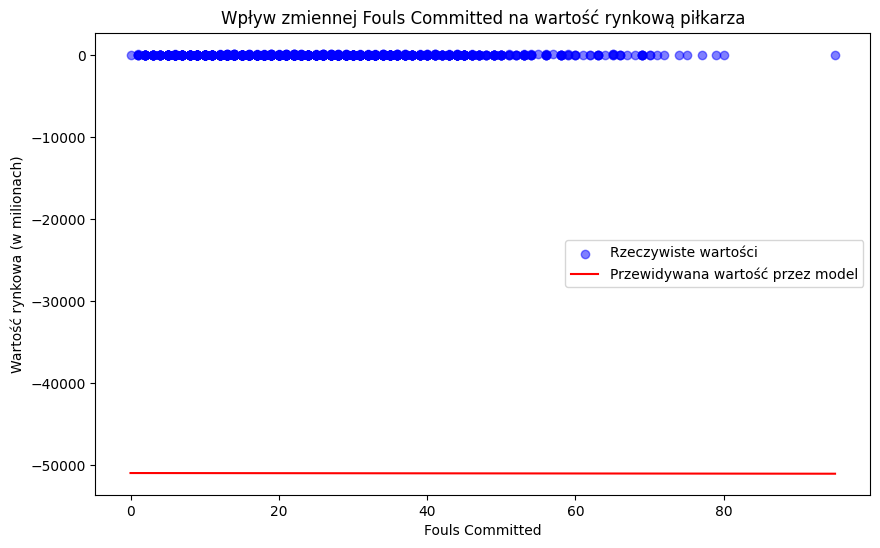

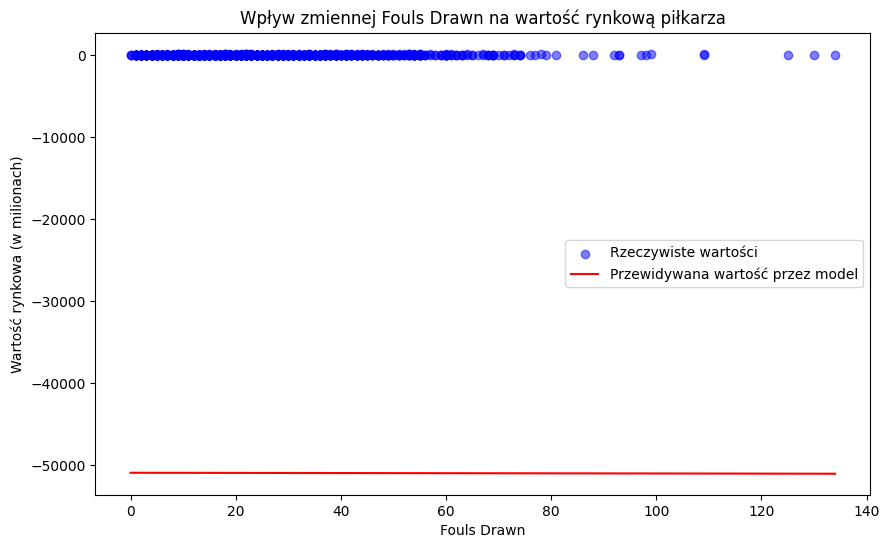

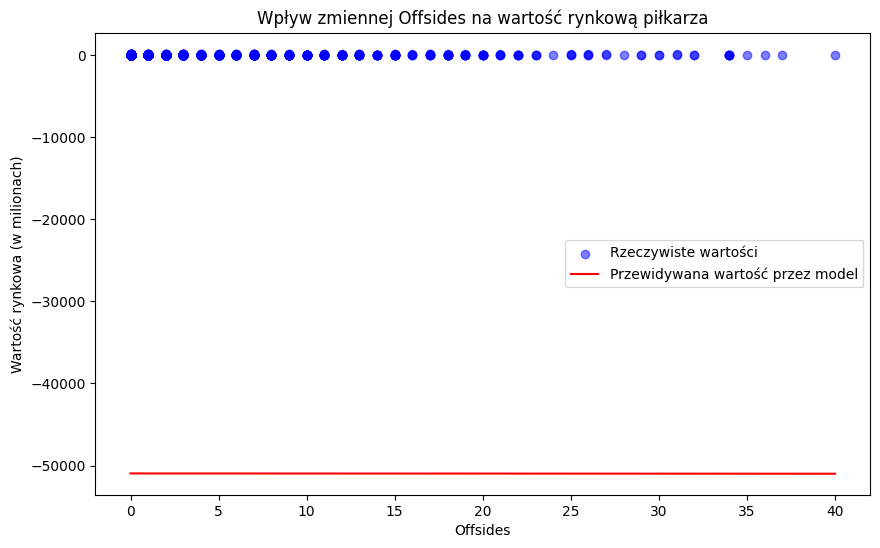

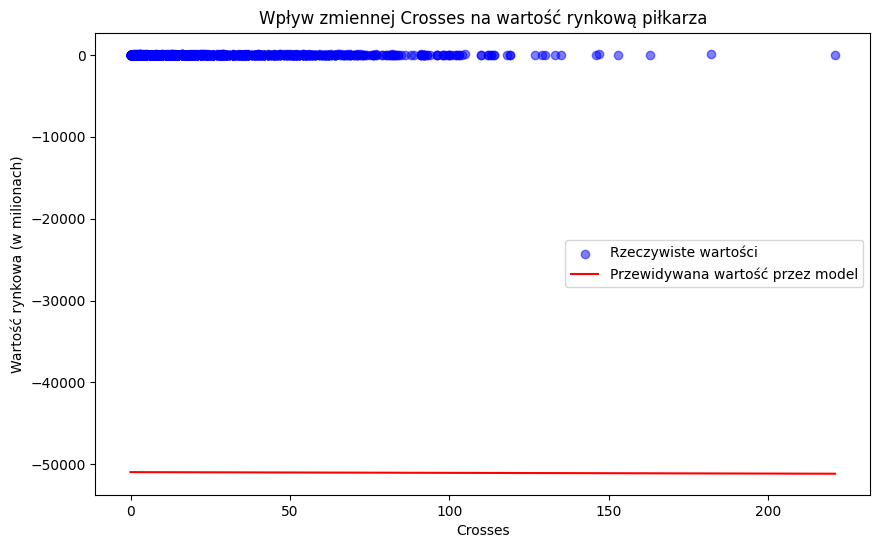

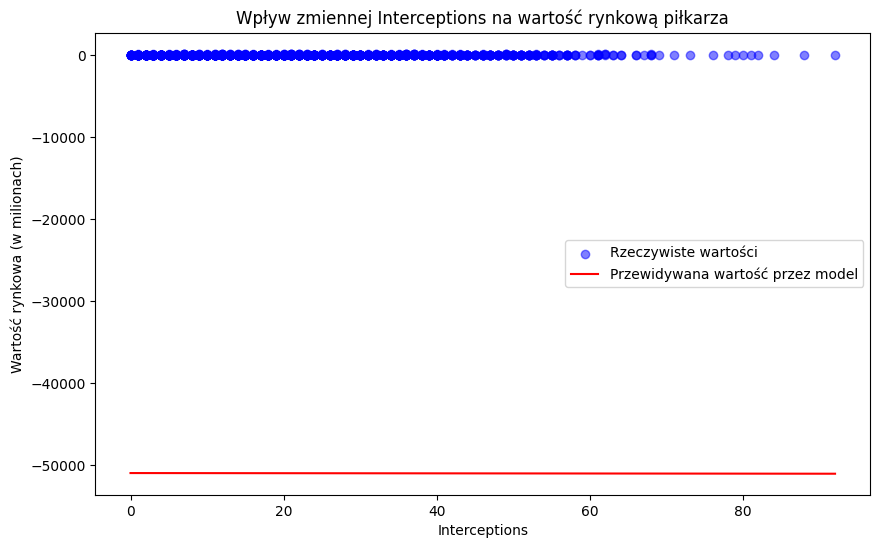

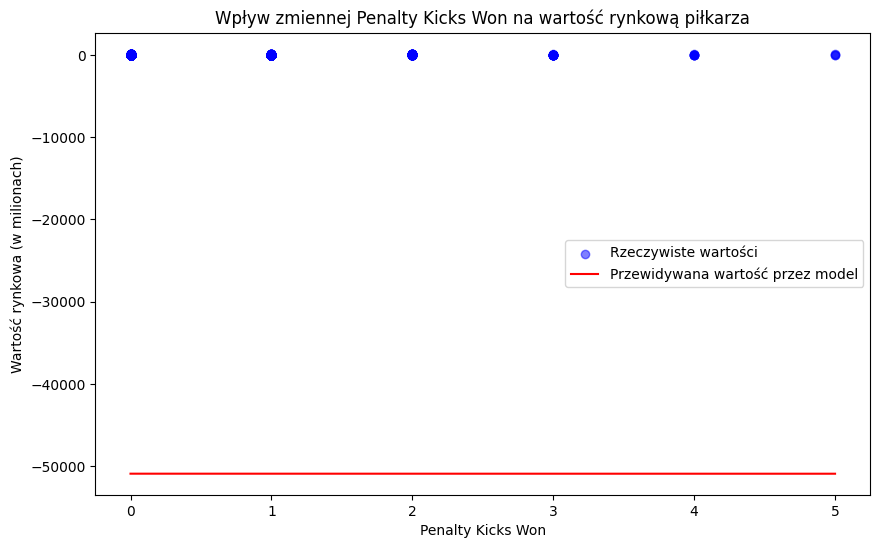

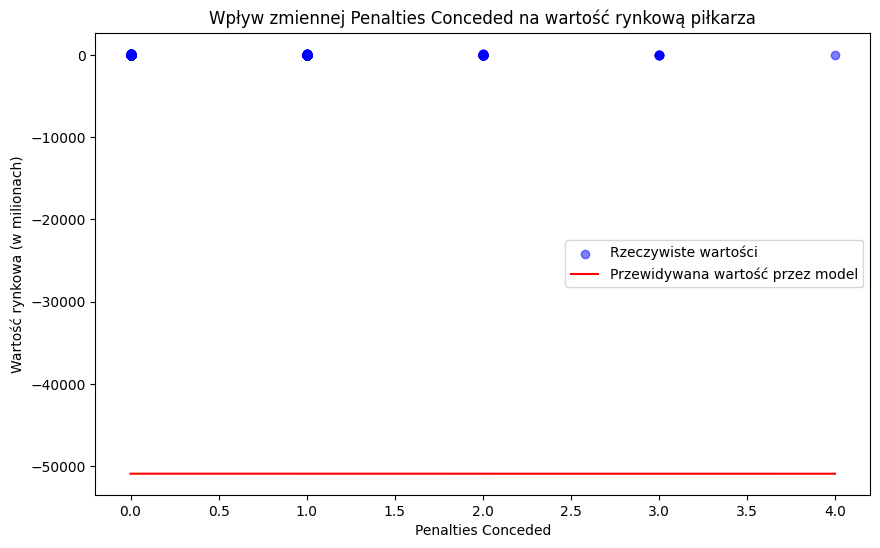

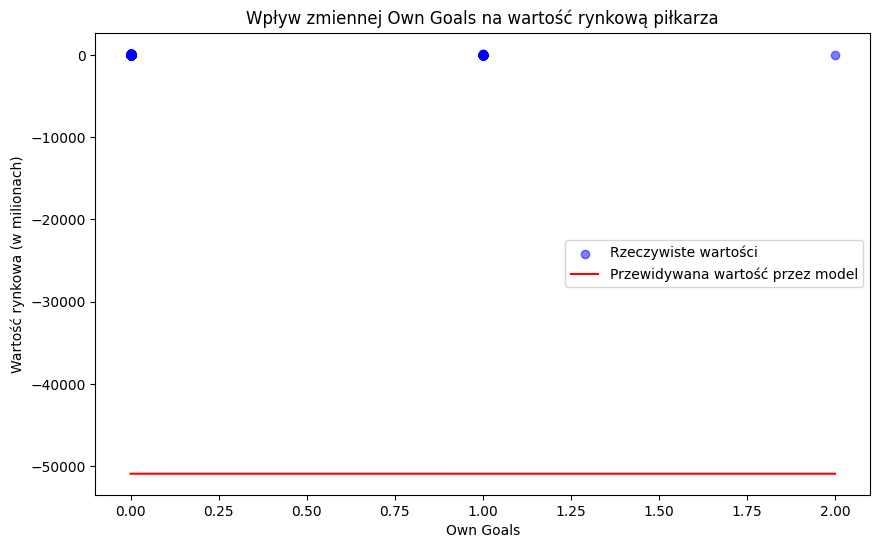

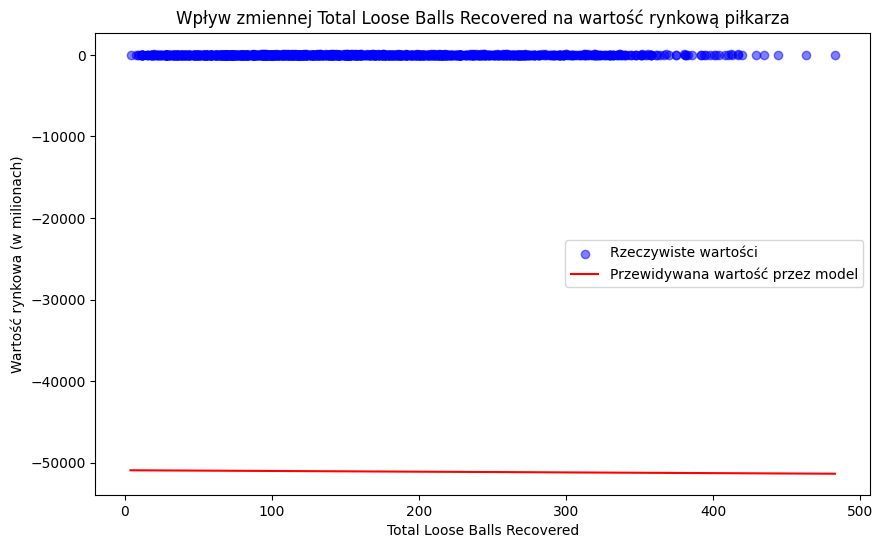

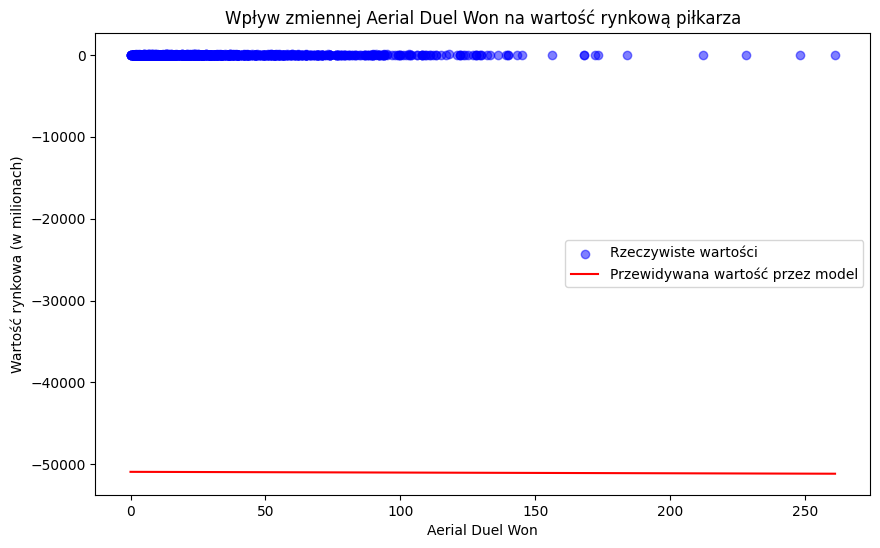

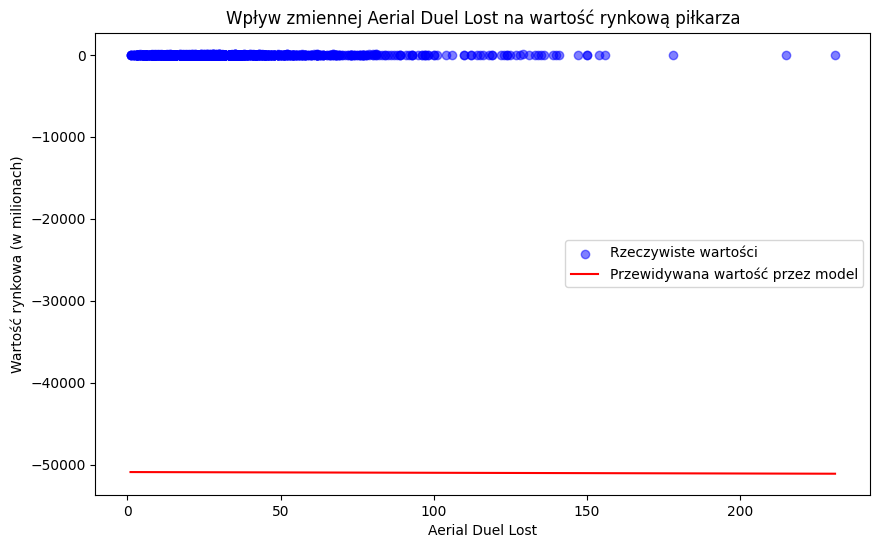

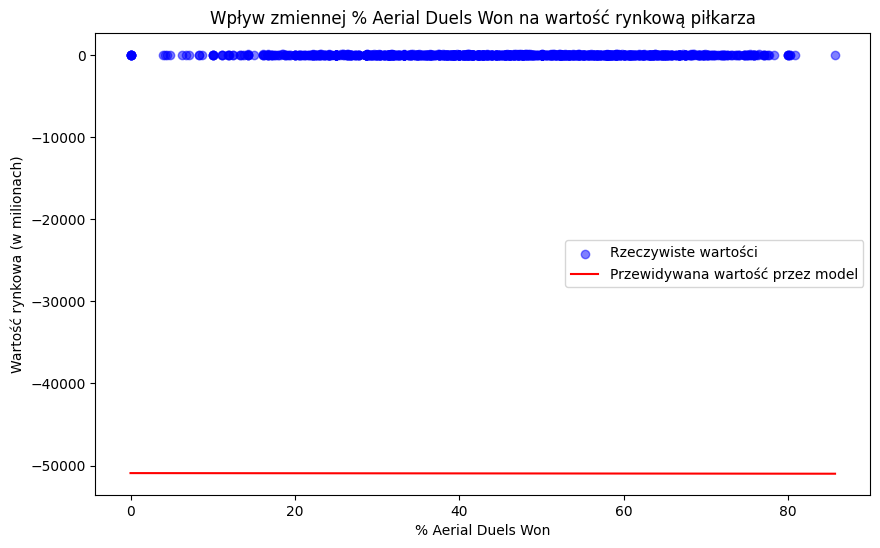

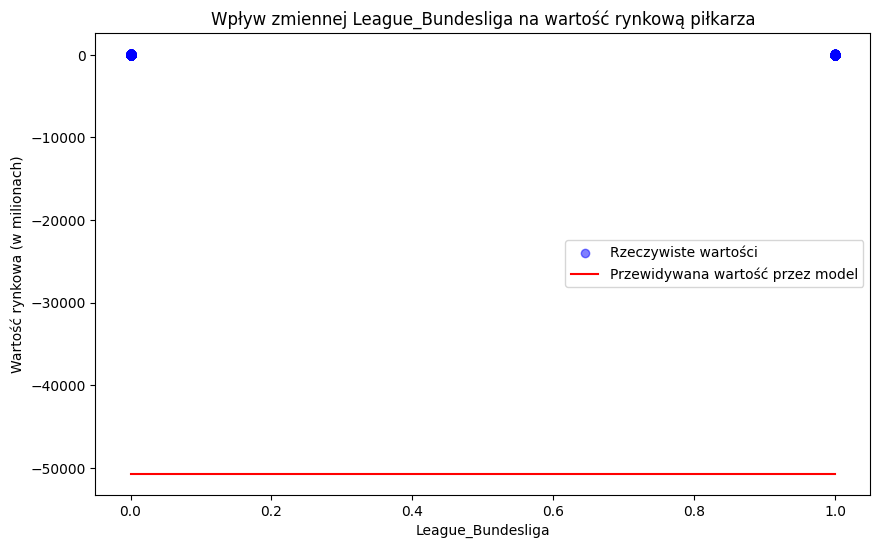

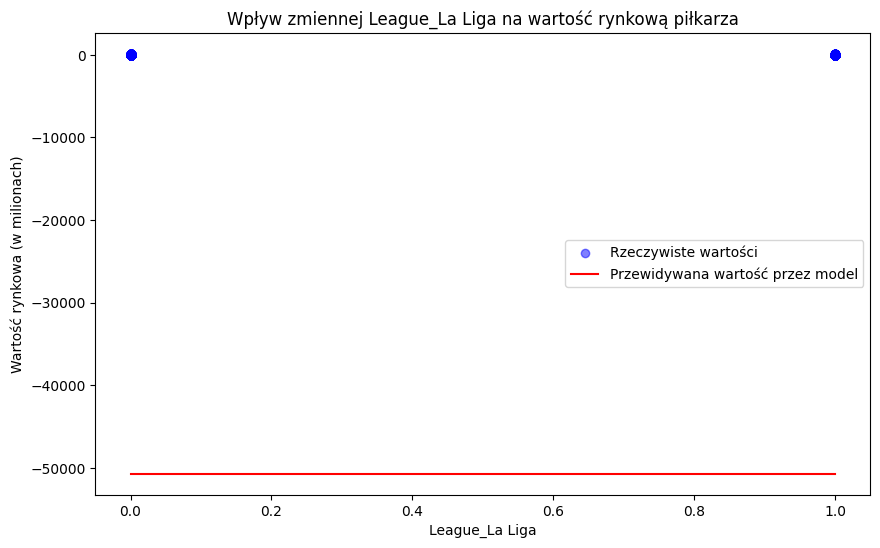

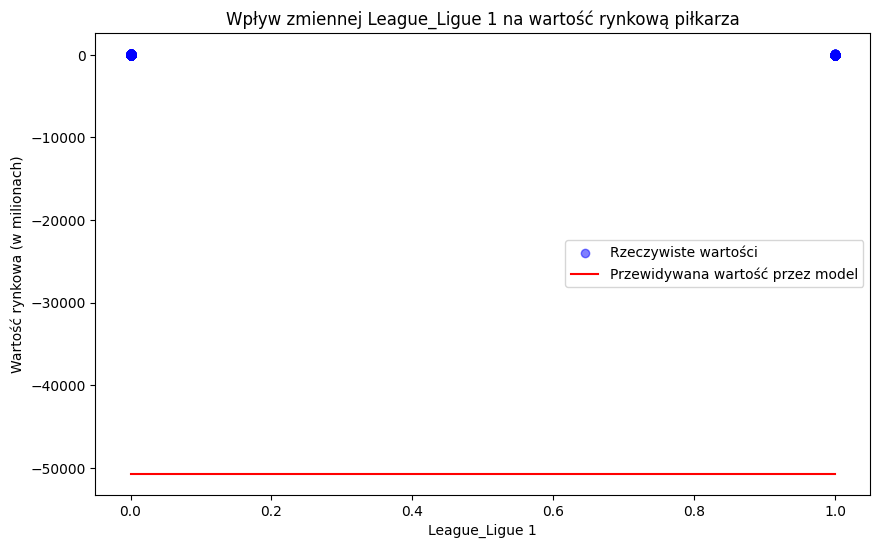

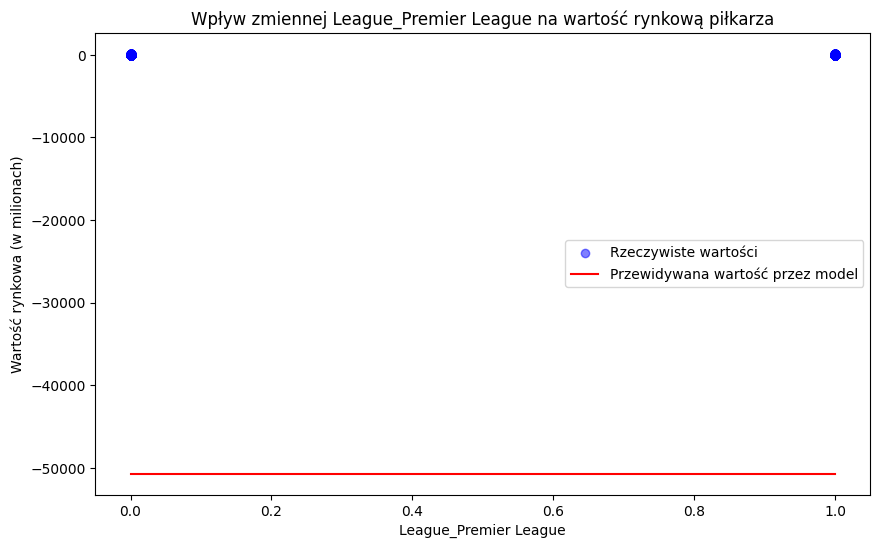

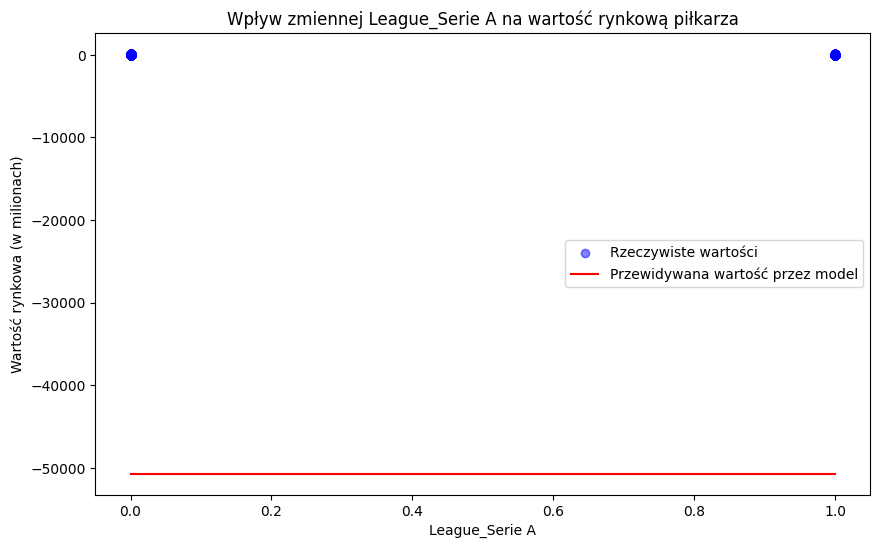

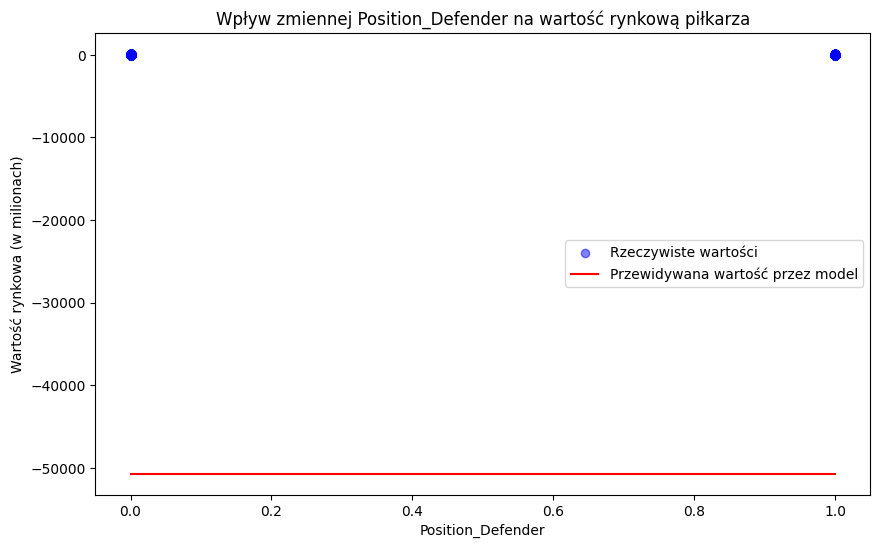

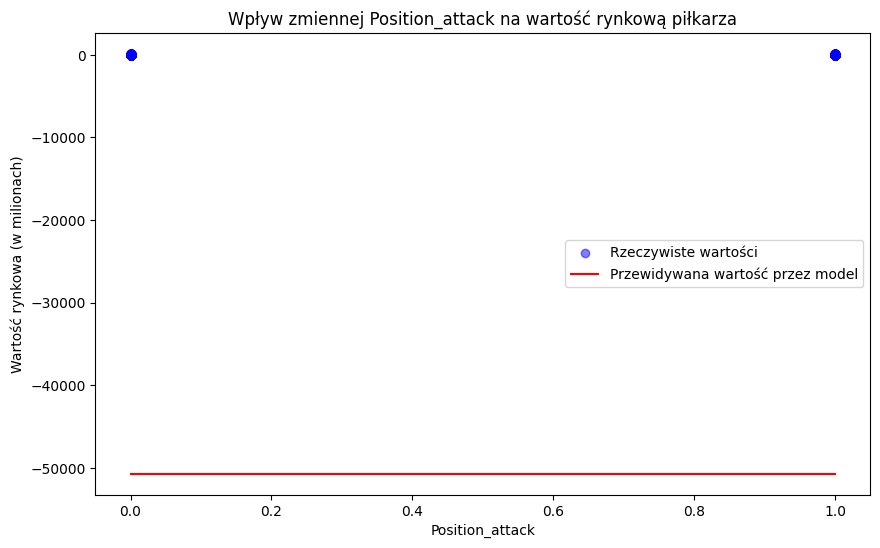

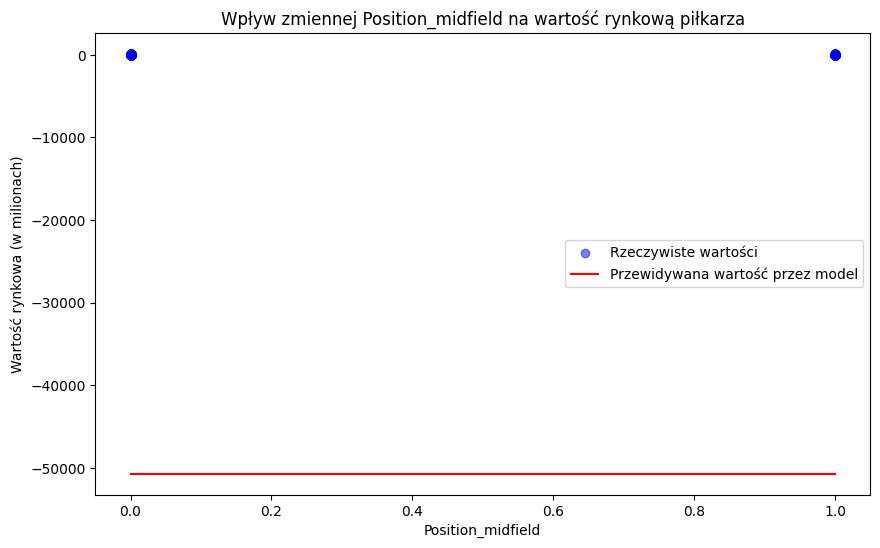

In [8]:
for col in X.columns:
    if col != 'const':  
       
        X_pred = pd.DataFrame({'const': 1, col: np.linspace(X[col].min(), X[col].max(), 100)})

       
        for other_col in X.columns:
            if other_col not in ['const', col]:
                X_pred[other_col] = X[other_col].mean()

      
        predicted_values = model.predict(X_pred)

        
        plt.figure(figsize=(10, 6))
        plt.scatter(X[col], y, color='blue', alpha=0.5, label='Rzeczywiste wartości')
        plt.plot(X_pred[col], predicted_values, color='red', label='Przewidywana wartość przez model')
        plt.title(f'Wpływ zmiennej {col} na wartość rynkową piłkarza')
        plt.xlabel(col)
        plt.ylabel('Wartość rynkowa (w milionach)')
        plt.legend()
        plt.show()

Sklearn regresja

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df_useful = df_useful[df_useful["Position"] !='Goalkeeper']
df_numeric = df_useful.select_dtypes(include=[np.number])
df_categorical = df_useful[['League', 'Position']]

encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(df_categorical).toarray()
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out())

df_final = pd.concat([df_numeric, categorical_encoded_df], axis=1)
df_final = df_final.dropna()

X = df_final.drop('Value', axis=1)
y = df_final['Value']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R^2: {r2}')


print('Intercept:', model.intercept_)
print('Coefficients:', pd.Series(model.coef_, index=X_train.columns))

MSE: 118.07839054152947
R^2: 0.40488743351043577
Intercept: 30.298096101314236
Coefficients: Age                                                                    -0.856382
Contract Years Left                                                     1.375836
MP                                                                     -0.375490
Starts                                                                 -0.392325
Min                                                                     0.313425
Total Mins/90                                                         -28.015224
Gls                                                                     0.458926
Ast                                                                     2.031070
Non-Penalty Goals                                                       4.307188
Penalties Scored                                                       -3.848261
Penalties Attempted                                                     6.476547
Yellow Cards    

random forest

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df_useful = df_useful[df_useful["Position"] != 'Goalkeeper']
df_numeric = df_useful.select_dtypes(include=[np.number])
df_categorical = df_useful[['League', 'Position']]

encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(df_categorical).toarray()
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out())

df_final = pd.concat([df_numeric, categorical_encoded_df], axis=1)
df_final = df_final.dropna()

X = df_final.drop('Value', axis=1)
y = df_final['Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


forest_model = RandomForestRegressor(n_estimators=100, random_state=42)


forest_model.fit(X_train, y_train)

y_pred = forest_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R^2: {r2}')


feature_importances = pd.DataFrame(forest_model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)


MSE: 113.8456076438298
R^2: 0.4262205689138798
                                                    importance
Goal Creating Actions                                 0.082254
Total Carries in Forward Direction                    0.058955
Number of Times Player was Pass Target                0.056312
Passes Leading to Shot Attempt                        0.052726
Age                                                   0.050213
Non-penalty xG+ xA                                    0.042176
Touches in Attacking Penalty Box                      0.036275
Touches in Attacking 3rd                              0.032540
Passes Leading to Goals                               0.021989
Carries into Attacking Penalty Box                    0.020890
Contract Years Left                                   0.020209
xG                                                    0.019368
Pass Completion % (All pass-types)                    0.019266
(G+A)/90                                              0.018932
Number o

Oddzielne modele LR dla pozycji

In [11]:

defenders = df_final[df_final['Position_Defender'] == 1]


attackers = df_final[df_final['Position_attack'] == 1]


midfielders = df_final[df_final['Position_midfield'] == 1]

# Funkcja do budowania modelu
def build_ols(data):
    X = data.drop(['Value', 'Position_Defender', 'Position_attack', 'Position_midfield'], axis=1)
    y = data['Value']
    X = sm.add_constant(X) 
    model = sm.OLS(y, X).fit()
    return model


model_defenders = build_ols(defenders)
model_attackers = build_ols(attackers)
model_midfielders = build_ols(midfielders)

In [12]:
print("OLS Summary for Defenders:")
print(model_defenders.summary())

print("\n\n\n\nOLS Summary for Attackers:")
print(model_attackers.summary())

print("\n\n\n\nOLS Summary for Midfielders:")
print(model_midfielders.summary())

OLS Summary for Defenders:
                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     5.939
Date:                Tue, 14 May 2024   Prob (F-statistic):           1.11e-43
Time:                        20:07:01   Log-Likelihood:                -1882.5
No. Observations:                 545   AIC:                             4019.
Df Residuals:                     418   BIC:                             4565.
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------